# Load data

## load functions

In [54]:
import pandas as pd
import numpy as np
import os
import sys
import re
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import io
from pptx import Presentation
from PIL import Image, ImageDraw, ImageFont
from matplotlib.backends.backend_pdf import PdfPages
import re
from Bio.Seq import Seq
from itertools import product
from scipy.odr import ODR, Model, Data
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
import random
# !pip install biopython
# !pip install logomaker
import logomaker
plt.rcParams['pdf.fonttype'] = 42
original_path = os.getcwd()
pip freeze > requirements.txt

## load Msn2, Msn2 DBD OE and Msn2 non-DBD OE data

In [ ]:
''' for Msn2 samples '''
# os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
# Get the absolute path of the current script
curr_data_path = os.path.join(original_path, 'STR_data_for_code','data_context_step_3')
os.chdir( curr_data_path )

''' functions '''

# path for rm_samples function .csv
rm_samples_path = os.path.join(curr_data_path, 'data')
def rm_samples(tf, lib_num, exp_num, res_table):
    '''This function removes from the result table the samples classified as bad. It gets the result table
    (before or after normalization) and the relevant tf, library number and experiment number.'''
    exp_num = int(exp_num)
    samples_to_remove = pd.read_csv(os.path.join(rm_samples_path, 'samples_to_remove.csv'))
    # read csv containing info about samples to remove
    curr_samples_to_rm = samples_to_remove.loc[(samples_to_remove['Lib_number'] == str(lib_num)) &
                                               (samples_to_remove['Exp_number'] == exp_num) &
                                               (samples_to_remove['TF'] == tf)]

    # get the names of samples to remove relevant to the input
    max_tech_rep_num = max(
        [int(name.split('_')[-1]) for name in res_table.columns])  # number of time point repeats in the experiment
    var_num = len(res_table)  # number of variants
    samples_to_rm_names = curr_samples_to_rm['Sample_name']  # the sample names that will be removed
    
    sample_bio_rep = np.array(
        [int(name.split('_')[0]) for name in samples_to_rm_names])  # the bio repeats of the bad samples
    sample_tps = np.array(
        [int(name.split('_')[1]) for name in samples_to_rm_names])  # the time point of the bad samples

    bad_bio_rep = ''
    for i, samp in enumerate(samples_to_rm_names):  # iterate over the names of samples to remove
        curr_tp = sample_tps[i]  # current time point
        curr_bio_rep = sample_bio_rep[i]  # current bio repeat
        np.unique(res_table.columns.str.split('_')[0])
        curr_biorep_tp = str(curr_bio_rep) + '_' + str(curr_tp) + '_'
        same_tp_biorep_samples_rm = [s for i, s in enumerate(samples_to_rm_names.values) if
                                     curr_biorep_tp in samples_to_rm_names.values[i]]
        # get all sample names to remove with the current tp and bio repeat
        all_bio_rep_tp_samples = res_table.columns[res_table.columns.str.contains(curr_biorep_tp)]
        # get all sample names (good and bad samples) from same tp and bio repeat as current sample
        good_samples = [s for s in all_bio_rep_tp_samples if sum(samples_to_rm_names.str.contains(s)) == 0]
        # returns only samples from the same time point and bio repeat that are good

        if (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 2):
            # when removing only one tp repeat of the bio repeat and there are 2 time point repeats
            res_table[samp] = res_table[good_samples]  # change bad sample values to the other good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 2):
            # when removing 2 tp repeats of the bio repeat and there are 2 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]  # change bad sample values to nans
            bad_bio_rep = str(curr_bio_rep)  # in case one bio repeat has an entire tp to remove - save the bio repeat number
        elif (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 3):
            # when removing only one tp repeat of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[res_table.columns.intersection(good_samples)].mean(axis=1)
            # change bad sample values to the mean of the other good time point repeats
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 3):
            # when removing 2 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[good_samples]
            # change bad sample values to the one good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 3) & (max_tech_rep_num == 3):
            # when removing 3 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]
            # change bad sample values to nans (no such scenario so far)
            bad_bio_rep = str(curr_bio_rep)
            # in case one bio repeat has an entire tp to remove - save the bio repeat number

    res_table_scatter = res_table.copy()  # copy the result table
    if bad_bio_rep:  # when one bio repeat has an entire tp to remove
        all_bio_rep = res_table_scatter.columns.str.split('_').str[0]  # get all the bio repeat sample names
        res_table_scatter[res_table_scatter.columns[all_bio_rep == bad_bio_rep]] = res_table_scatter[
            res_table_scatter.columns[all_bio_rep != bad_bio_rep]]
        # copy the "good" bio repeat instead of the "bad" ones
    return res_table, res_table_scatter

def all_combinations(length):
    bases = "ACGT"
    combinations = product(bases, repeat=length)

    return pd.Series(combinations).apply(lambda x: ''.join(x))

def get_rev_comp(sequnce_list):
    past_seqs = []
    for seq in sequnce_list:
        seq_obj = Seq(seq)
        search_string = str(seq_obj.reverse_complement())
        if  search_string in past_seqs or seq in past_seqs:
            continue
        else:
            past_seqs.extend([seq,search_string])
    return past_seqs

def count_patterns(vector, index):      #count patterns of di nucleotides
        pattern_counts = np.zeros((len(vector), 16), dtype=int)  # Initialize a matrix to store pattern counts
        for i, string in enumerate(vector):
            string = string+string[0]  # add the first nucleotide to the end and create another bond
            # Count the occurrences of each pattern in the current string
            pattern_counts[i, 0] = len(re.findall(r'(?=AA)', string))
            pattern_counts[i, 1] = len(re.findall(r'(?=AC)', string))
            pattern_counts[i, 2] = len(re.findall(r'(?=AG)', string))
            pattern_counts[i, 3] = len(re.findall(r'(?=AT)', string))
            pattern_counts[i, 4] = len(re.findall(r'(?=CA)', string))
            pattern_counts[i, 5] = len(re.findall(r'(?=CC)', string))
            pattern_counts[i, 6] = len(re.findall(r'(?=CG)', string))
            pattern_counts[i, 7] = len(re.findall(r'(?=CT)', string))
            pattern_counts[i, 8] = len(re.findall(r'(?=GA)', string))
            pattern_counts[i, 9] = len(re.findall(r'(?=GC)', string))
            pattern_counts[i, 10] = len(re.findall(r'(?=GG)', string))
            pattern_counts[i, 11] = len(re.findall(r'(?=GT)', string))
            pattern_counts[i, 12] = len(re.findall(r'(?=TA)', string))
            pattern_counts[i, 13] = len(re.findall(r'(?=TC)', string))
            pattern_counts[i, 14] = len(re.findall(r'(?=TG)', string))
            pattern_counts[i, 15] = len(re.findall(r'(?=TT)', string))
        pattern_counts = pd.DataFrame(pattern_counts)
        pattern_counts.columns = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
        pattern_counts.index = index
        return pattern_counts
    
    
def count_tri_patterns(vector, index):                # count tri nucleotides occurances
    """ input a vector of dna sequence and its index\noutput is a df with the same index of input, columns are all 64 trinucs and the values are the count of a trinuc in a dna sequnce
    \ncount of trinuc in sequence only, not in the reverse compliment of the sequences """
    trinucs = [
        'AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT',
        'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT',
        'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT',
        'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC', 'CTG', 'CTT',
        'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT',
        'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT',
        'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT',
        'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT'
    ]
    pattern_counts = np.zeros((len(vector), 64), dtype=int)
    
    for i, string in enumerate(vector):
        string = string + string[0:2]  # add the first nucleotide to the end and create another bond

        for j, trinuc in enumerate(trinucs):
            pattern_counts[i, j] = len(re.findall(rf'(?={trinuc})', string))

    pattern_counts = pd.DataFrame(pattern_counts)
    pattern_counts.columns = trinucs
    pattern_counts.index = index
    return pattern_counts

def count_di_patterns(vector, index):                # count tri nucleotides occurances
    """ input a vector of dna sequence and its index\noutput is a df with the same index of input, columns are all 64 trinucs and the values are the count of a trinuc in a dna sequnce
    \ncount of trinuc in sequence only, not in the reverse compliment of the sequences"""
    dinucs = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    pattern_counts = np.zeros((len(vector), 16), dtype=int)
    
    for i, string in enumerate(vector):
        string = string + string[0:1]  # add the first nucleotide to the end and create another bond

        for j, dinuc in enumerate(dinucs):
            pattern_counts[i, j] = len(re.findall(rf'(?={dinuc})', string))

    pattern_counts = pd.DataFrame(pattern_counts)
    pattern_counts.columns = dinucs
    pattern_counts.index = index
    return pattern_counts
    
    

def create_nucleotide_count_matrix(df, sequence_col, score_col):
    """
    Create a nucleotide count matrix from a DataFrame containing sequences and their read scores.

    Parameters:
        df (pandas.DataFrame): The input DataFrame with 'sequence' and 'score' columns.

    Returns:
        pandas.DataFrame: The nucleotide count matrix where rows are sequences and columns are nucleotides.
    """
    # Create an empty dictionary to store the counts for each sequence
    sequence_counts = {}

    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        sequence = row[str(sequence_col)]
        score = row[str(score_col)]

        # Count the nucleotides in the sequence
        count = {}
        for nucleotide in sequence:
            count[nucleotide] = count.get(nucleotide, 0) + score

        # Add the counts to the sequence_counts dictionary
        sequence_counts[sequence] = count

    # Convert the dictionary into a DataFrame
    count_df = pd.DataFrame(sequence_counts).fillna(0).transpose()

    # Reorder columns alphabetically for clarity
    count_df = count_df.reindex(sorted(count_df.columns), axis=1)

    return count_df

# Example usage:
# Assuming you have a DataFrame named 'df' with 'sequence' and 'score' columns
# nucleotide_count_matrix = create_nucleotide_count_matrix(df)



def calculate_probabilities(df,delta_col):
    positions = df['nuc_comb'][:-2].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[str(delta_col)].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        freq = row[str(delta_col)]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += freq
    
    probabilities /= total_freq
    
    return probabilities

# here I take all sequences, including last 2 in the column, which is usually the 'genome' sequenece
def calculate_probabilities1(df,delta_col):
    positions = df['nuc_comb'].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[str(delta_col)].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        freq = row[str(delta_col)]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += freq
    probabilities /= total_freq
    
    return probabilities

def calculate_probabilities_rank(df, rank_col):
    positions = df['nuc_comb'].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[rank_col].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        rank = row[rank_col]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += rank
    probabilities /= total_freq
    
    return probabilities



def find_key_by_value(my_dict, random_value):
    """ input a dict where keys are nucleotide combinations and values are all sequences that map to that key. \n enter the sequence you want to find the key of. 
    """
    keys = []
    for key, values in my_dict.items():
        if random_value in values:
            keys.append(key)
    if len(keys)>0:
        return keys
    else:
        return None  # Return None if the random_value is not found in any key's values
    
def get_cyclic_seq(sequence):
    """ input a [sequence] and get all cyclic combiantions of it as a set
    """
    cyc_seqs = []
    seq_len = len(sequence)
    for i in range(seq_len):
        cyc_seqs.append(sequence[i+1:]+sequence[:i+1])
    return set(cyc_seqs)

def get_seq_set(sequence):
    """ emter a [sequence] and get all posiible cyclic and reverse compliments of it as a set
    """
    seq_set = []
    seq_len = len(sequence)
    seq_set.extend( get_rev_comp([ str(sequence) ]) )
    if seq_set[0] == seq_set[1]:
        seq_set.remove(seq_set[1])
        seq_set.extend(get_cyclic_seq(seq_set[0]))
    else:
        seq_set.extend(get_cyclic_seq(seq_set[0]))
        seq_set.extend(get_cyclic_seq(seq_set[1]))
    return set(seq_set)

def create_seq_set_dict(sequences):
    """ create a dictionary, the keys are all sequences in the input [sequence] and values are all possible cyclic and reverse compliment of the key \n see find_key_by_value function to use with the created dict. 
    \n output is a dict
    """
    out_dict = {}
    for seq in sequences:
        val =  get_seq_set(str(seq))
        out_dict[list(val)[0]] = val
    return out_dict

def motif_expand(motif, target_length):
    x = target_length - len(motif)
    if x>0:
        return motif+motif[:x]
    else:
        return 'target_length should be longer then motif length'



def calculate_partial_score(motif, sequence):
    max_score = 0
    for i in range(len(motif)):
        for j in range(i, len(motif)):
            if motif[i:j+1] in sequence:
                score = j - i + 1
                max_score = max(max_score, score)
    return max_score

def find_motif_in_sequences(motif, sequences):
    results = []
    for sequence in sequences:
        score = calculate_partial_score(motif, sequence)
        results.append(score / len(motif))
    return results

def screen_for_threshold(lib_df, threshold):
    """ input is lib_df and a threshold (number) \noutput is the lib_df, after samples that their time point 0 median is below the threshold were removed"""
    res_df = pd.DataFrame()
    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i, value in enumerate(med_0) if (i % 2 == 0 and med_0[i]>threshold and med_0[i+1]>threshold) or (i % 2 == 1 and med_0[i-1]>threshold and med_0[i]>threshold)]
    indices_to_keep = list(np.unique(indices_to_keep))
    return lib_df.iloc[indices_to_keep,:]

def modify_sequence(seq, discard_agg=False):
    """ input is a DNA sequences, output is a DNA sequence but:\nif A was in the original seq, it now comes first (use for cyclic sequences)\nif the seq has only T, the seq is reversed complimented and then A coems first\nelse, the original sequences is the output"""
    cyclic_seq = seq+seq[:2]
    if 'AGG' in cyclic_seq:
        # If 'AGG' is present, shift it to the beginning
        while seq[:3] != 'AGG':
            seq = seq[-1] + seq[:-1]
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
    if 'A' in seq and 'CCT' not in cyclic_seq:
        # If 'A' is present, shift it to the beginning
        while seq[0] != 'A':
            seq = seq[-1] + seq[:-1]
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
    elif 'T' in seq:
        # If 'T' is present but not 'A', reverse complement and put 'A' first
        complement = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
        rev_comp = ''.join(complement[base] for base in reversed(seq))
        return modify_sequence(rev_comp)
    else:
        # If neither 'A' nor 'T', return the sequence as is
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
def median_zscoring(vector_i):
    curr_median = np.median(vector_i)
    mad = np.median(np.abs(vector_i - curr_median))
    z_scores = (vector_i - curr_median) / mad
    return z_scores

def mad(vector_i):
    c_median = np.median(vector_i)
    return np.median(np.abs(vector_i - c_median))
    
def calculate_gc_content(nucleotide_combination):
    """ input a sequence to get its GC content as fraction of GC count / sequence length * 100 """
    gc_count = sum(char in 'GC' for char in nucleotide_combination)
    gc_content = (gc_count / len(nucleotide_combination)) * 100
    return gc_content
  
    
def find_combined_key(seq, dataframe):
    """ for a sequecne, find its key in a given dataframe 
    return 0 if no key was found """
    seq_set = get_seq_set(seq)
    keys = [x for x in seq_set if x in dataframe.index ]
    if keys == []:
        return 0
    else:
        return keys[0]           
    
    
def rotate_sequence_to_start_with_nuc(sequence, nuc):
    """ enter a sequence (cyclic seqeucne) and a nucleotide and get the rotation of that sequence until 'nuc' comes first """
    cyc_sequence = sequence + sequence[:len(nuc)-1]
    if nuc in cyc_sequence:
        g_index = cyc_sequence.index(nuc)
        return sequence[g_index:] + sequence[:g_index]
    elif get_rev_comp([nuc])[1] in cyc_sequence:
        g_index = cyc_sequence.index( get_rev_comp([nuc])[1] )
        return sequence[g_index:] + sequence[:g_index]
    else:
        return sequence
    
    
def count_patterns_vector(vector):
    pattern_counts = pd.DataFrame(np.zeros((len(vector), 4), dtype=float), columns=['A-G','A-C','T-A','T-C'] )  # Initialize a matrix to store pattern counts
    for i, string in enumerate(vector):
        string = string+string[0]  # add the first nucleotide to the end and create another bond
        # Count the occurrences of each pattern in the current string
        pattern_counts.loc[i, 'A-G'] = len(re.findall(r'(?=(AG|GA|AA|GG))', string))/(len(string)-1)  # A or G followed by G or A
        pattern_counts.loc[i, 'A-C'] = len(re.findall(r'(?=(AT|GT|AC|GC))', string))/(len(string)-1)  # A or G followed by T or C
        pattern_counts.loc[i, 'T-A'] = len(re.findall(r'(?=(TA|TG|CA|CG))', string))/(len(string)-1)  # T or C followed by A or G
        pattern_counts.loc[i, 'T-C'] = len(re.findall(r'(?=(TC|CT|CC|TT))', string))/(len(string)-1)  # T or C followed by T or C
        pattern_counts.loc[i, 'pur_pur'] =  pattern_counts.loc[i, 'A-G'] + pattern_counts.loc[i, 'T-C']
        pattern_counts.loc[i, 'pur_pyr'] =  pattern_counts.loc[i, 'A-C'] + pattern_counts.loc[i, 'T-A']
    return pattern_counts

def count_patterns_seq(vector):
   
    string = vector+vector[0]  # add the first nucleotide to the end and create another bond
    # Count the occurrences of each pattern in the current string
    count_AG = len(re.findall(r'(?=(AG|GA|AA|GG))', string))/(len(string)-1)  # A or G followed by G or A
    count_AC = len(re.findall(r'(?=(AT|GT|AC|GC))', string))/(len(string)-1)  # A or G followed by T or C
    count_TA = len(re.findall(r'(?=(TA|TG|CA|CG))', string))/(len(string)-1)  # T or C followed by A or G
    count_TC = len(re.findall(r'(?=(TC|CT|CC|TT))', string))/(len(string)-1)  # T or C followed by T or C
    pur_pur =  count_AG + count_TC
    pur_pyr =  count_AC + count_TA
    return pur_pyr
        
def count_stretch_seq(vector, dinuc):
    """ input a seq and a dinuc out of [AA, AT, GG, GC] to get the count of consecutive occurences of that dinuc. works for cyclic sequences """
    res_dict = {}
    string = vector+vector[0]  # add the first nucleotide to the end and create another bond
    # Count the occurrences of each pattern in the current string
    res_dict['AA'] = len(re.findall(r'(?=(AA|TT))', string))        # AA or TT
    res_dict['AT'] = len(re.findall(r'(?=(AT|TA))', string))        # AT or TA
    res_dict['GG'] = len(re.findall(r'(?=(GG|CC))', string))        # GG or CC
    res_dict['GC'] = len(re.findall(r'(?=(GC|CG))', string))        # GC or CG

    return res_dict[dinuc]
    
    

def count_purines_and_pyrimidines(dna_sequence):
    """ count stretch of purines (A/G) and pyrimidines (C/T) in cyclical sequenes of maximal length 5\n output is [0] max purine count and [1] max pyrimidnes count """
    # Extend the DNA sequence to a length of 5
    extended_sequence = dna_sequence * ((5 // len(dna_sequence)) + 1)
    extended_sequence = extended_sequence[:5]  # Trim to length 5 if necessary

    # Initialize counters for purines and pyrimidines
    max_purine_count = 0
    max_pyrimidine_count = 0

    # Iterate through the extended sequence
    for i in range(len(extended_sequence)):
        base = extended_sequence[i]

        # Check for consecutive purines
        purine_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in 'AG':
                purine_count += 1
            else:
                break

        max_purine_count = max(max_purine_count, purine_count)

        # Check for consecutive pyrimidines
        pyrimidine_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in 'CT':
                pyrimidine_count += 1
            else:
                break

        max_pyrimidine_count = max(max_pyrimidine_count, pyrimidine_count)

    return max_purine_count, max_pyrimidine_count


def count_nuc_strech(dna_sequence, nuc_list):
    """ count stretch of selected nucleotides in cyclical sequenes of maximal length 5\n output is max nucleotide count\n input nuc_list as: ['A', 'T', 'G', 'C'] for chosen nucleotides """
    # Extend the DNA sequence to a length of 5
    extended_sequence = dna_sequence * ((5 // len(dna_sequence)) + 1)
    extended_sequence = extended_sequence[:5]  # Trim to length 5 if necessary

    # Initialize counter for nucleotide stretch
    max_nuc_count = 0

    # Iterate through the extended sequence
    for i in range(len(extended_sequence)):
        base = extended_sequence[i]

        # Check for consecutive nucleotides
        nuc_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in nuc_list:
                nuc_count += 1
            else:
                break

        max_nuc_count = max(max_nuc_count, nuc_count)

    return max_nuc_count

def count_coherent_triplets(dna_sequence):
    if not 2 <= len(dna_sequence) <= 5:
        raise ValueError("Input DNA sequence must have a length between 2 and 5")

    coherent_triplets = 0

    # Create a cyclic DNA sequence
    cyclic_sequence = dna_sequence + dna_sequence[0:2]

    # Iterate through the cyclic sequence and count coherent triplets
    for i in range(len(dna_sequence)):
        triplet = cyclic_sequence[i:i + 3]
        if all(nucleotide in 'AG' for nucleotide in triplet) or all(nucleotide in 'CT' for nucleotide in triplet):
            coherent_triplets += 1

    return coherent_triplets/len(dna_sequence)


def assign_seq_group(sequence):
    ''' get a sequence as a string and assign it to 1 of 4 sequence groups:\n1. AGG\n2. A/T + 3[G,C] + A/T\n3. %AT >= 75%\n4. general sequences
    function will look for the sequenece pattern and its reverse compliment (not the cyclic pattern) in the input sequence and in its cyclic options '''
#     build  a decision tree
#     a sequences can be assigned to more than one group, so it has to be put in the tree in different starting points
    group = []
    agggt_pattern = re.compile(r'[AT](GGG|CCC|GCG|CGC|GGC|CGG|CCG|GCC)[AT]')
    cyc_seq = sequence + sequence
    if 'AGG' in cyc_seq or 'CCT' in cyc_seq:
        group.append('AGG')
    if bool(agggt_pattern.search(cyc_seq)):
        group.append('3G')
    if calculate_gc_content(cyc_seq) < 26:
        group.append('AT_rich')
    if len(group)==0:
        group.append('general_sequence')
    return group

    

    
def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean or median, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():
        curr_patt = line[1]['Pool name']+'_S[0-9]{1,2}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)
    
    lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = lib_df.drop_duplicates()
    
    if threshold == 0:
        # remove rows where all tp0 or all tp180 samples are nan
        # tp0_remove = lib_df[['1_0_1', '1_0_2', '1_0_3']].isna().any(axis=1)
        # tp180_remove = lib_df[['1_180_1', '1_180_2', '1_180_3']].isna().any(axis=1)
        # lib_df = lib_df[~(tp0_remove | tp180_remove)]
        
        # remove rows with at least 1 nan
        lib_df.dropna(inplace=True)


        
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1
    
    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
        
    return lib_df, on_rows, off_rows




''' load data of 3 Msn2 strains, Mot3, Cbf1 and Reb1
    use a function to load and a function to combine sequences '''

Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]
strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


libs = Msn2_libs
strains = Msn2_strains
norm_to = 10**6
exp_num = 29
res_dict = {}
threshold = 8
mean_or_median = 'median'

for strain_i, strain in enumerate(strains):
    for lib_i, lib in enumerate(libs[strain_i]):
        
        thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len(libs[strain_i])] * len(strains)] 
        thsld = thsld_list_8[strain_i][lib_i]
        lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, zscoring= mean_or_median, flip_zscore=False)

        grouped = lib_df.groupby(lib_df.index)
        for index, group in grouped:
            if len(group) > 2:  # Check if there are multiple rows with the same index
                print(f"Index '{index}' has the following rows:")
                print(group)
        
        if strain+'_on' not in res_dict.keys():
            res_dict[strain] = lib_df
            res_dict[strain+'_on'] = on_rows
            res_dict[strain+'_off'] =  off_rows
        else:
            res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
            res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
            res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])
            



## load Mot3, Cbf1 and Reb1 data

In [ ]:
''' functions '''
# os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
# Get the absolute path of the current script
curr_data_path = os.path.join(original_path, 'STR_data_for_code','data_context_step_3')
os.chdir( curr_data_path )


# path for rm_samples function .csv
rm_samples_path = os.path.join(curr_data_path, 'data')
def rm_samples(tf, lib_num, exp_num, res_table):
    '''This function removes from the result table the samples classified as bad. It gets the result table
    (before or after normalization) and the relevant tf, library number and experiment number.'''
    exp_num = int(exp_num)
    samples_to_remove = pd.read_csv(os.path.join(rm_samples_path, 'samples_to_remove.csv'))
    # read csv containing info about samples to remove
    curr_samples_to_rm = samples_to_remove.loc[(samples_to_remove['Lib_number'] == str(lib_num)) &
                                               (samples_to_remove['Exp_number'] == exp_num) &
                                               (samples_to_remove['TF'] == tf)]

    # get the names of samples to remove relevant to the input
    max_tech_rep_num = max(
        [int(name.split('_')[-1]) for name in res_table.columns])  # number of time point repeats in the experiment
    var_num = len(res_table)  # number of variants
    samples_to_rm_names = curr_samples_to_rm['Sample_name']  # the sample names that will be removed
    
    sample_bio_rep = np.array(
        [int(name.split('_')[0]) for name in samples_to_rm_names])  # the bio repeats of the bad samples
    sample_tps = np.array(
        [int(name.split('_')[1]) for name in samples_to_rm_names])  # the time point of the bad samples

    bad_bio_rep = ''
    for i, samp in enumerate(samples_to_rm_names):  # iterate over the names of samples to remove
        curr_tp = sample_tps[i]  # current time point
        curr_bio_rep = sample_bio_rep[i]  # current bio repeat
        np.unique(res_table.columns.str.split('_')[0])
        curr_biorep_tp = str(curr_bio_rep) + '_' + str(curr_tp) + '_'
        same_tp_biorep_samples_rm = [s for i, s in enumerate(samples_to_rm_names.values) if
                                     curr_biorep_tp in samples_to_rm_names.values[i]]
        # get all sample names to remove with the current tp and bio repeat
        all_bio_rep_tp_samples = res_table.columns[res_table.columns.str.contains(curr_biorep_tp)]
        # get all sample names (good and bad samples) from same tp and bio repeat as current sample
        good_samples = [s for s in all_bio_rep_tp_samples if sum(samples_to_rm_names.str.contains(s)) == 0]
        # returns only samples from the same time point and bio repeat that are good

        if (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 2):
            # when removing only one tp repeat of the bio repeat and there are 2 time point repeats
            res_table[samp] = res_table[good_samples]  # change bad sample values to the other good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 2):
            # when removing 2 tp repeats of the bio repeat and there are 2 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]  # change bad sample values to nans
            bad_bio_rep = str(curr_bio_rep)  # in case one bio repeat has an entire tp to remove - save the bio repeat number
        elif (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 3):
            # when removing only one tp repeat of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[res_table.columns.intersection(good_samples)].mean(axis=1)
            # change bad sample values to the mean of the other good time point repeats
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 3):
            # when removing 2 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[good_samples]
            # change bad sample values to the one good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 3) & (max_tech_rep_num == 3):
            # when removing 3 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]
            # change bad sample values to nans (no such scenario so far)
            bad_bio_rep = str(curr_bio_rep)
            # in case one bio repeat has an entire tp to remove - save the bio repeat number

    res_table_scatter = res_table.copy()  # copy the result table
    if bad_bio_rep:  # when one bio repeat has an entire tp to remove
        all_bio_rep = res_table_scatter.columns.str.split('_').str[0]  # get all the bio repeat sample names
        res_table_scatter[res_table_scatter.columns[all_bio_rep == bad_bio_rep]] = res_table_scatter[
            res_table_scatter.columns[all_bio_rep != bad_bio_rep]]
        # copy the "good" bio repeat instead of the "bad" ones
    return res_table, res_table_scatter

def all_combinations(length):
    bases = "ACGT"
    combinations = product(bases, repeat=length)

    return pd.Series(combinations).apply(lambda x: ''.join(x))

def get_rev_comp(sequnce_list):
    past_seqs = []
    for seq in sequnce_list:
        seq_obj = Seq(seq)
        search_string = str(seq_obj.reverse_complement())
        if  search_string in past_seqs or seq in past_seqs:
            continue
        else:
            past_seqs.extend([seq,search_string])
    return past_seqs

def count_patterns(vector, index):      #count patterns of di nucleotides
        pattern_counts = np.zeros((len(vector), 16), dtype=int)  # Initialize a matrix to store pattern counts
        for i, string in enumerate(vector):
            string = string+string[0]  # add the first nucleotide to the end and create another bond
            # Count the occurrences of each pattern in the current string
            pattern_counts[i, 0] = len(re.findall(r'(?=AA)', string))
            pattern_counts[i, 1] = len(re.findall(r'(?=AC)', string))
            pattern_counts[i, 2] = len(re.findall(r'(?=AG)', string))
            pattern_counts[i, 3] = len(re.findall(r'(?=AT)', string))
            pattern_counts[i, 4] = len(re.findall(r'(?=CA)', string))
            pattern_counts[i, 5] = len(re.findall(r'(?=CC)', string))
            pattern_counts[i, 6] = len(re.findall(r'(?=CG)', string))
            pattern_counts[i, 7] = len(re.findall(r'(?=CT)', string))
            pattern_counts[i, 8] = len(re.findall(r'(?=GA)', string))
            pattern_counts[i, 9] = len(re.findall(r'(?=GC)', string))
            pattern_counts[i, 10] = len(re.findall(r'(?=GG)', string))
            pattern_counts[i, 11] = len(re.findall(r'(?=GT)', string))
            pattern_counts[i, 12] = len(re.findall(r'(?=TA)', string))
            pattern_counts[i, 13] = len(re.findall(r'(?=TC)', string))
            pattern_counts[i, 14] = len(re.findall(r'(?=TG)', string))
            pattern_counts[i, 15] = len(re.findall(r'(?=TT)', string))
        pattern_counts = pd.DataFrame(pattern_counts)
        pattern_counts.columns = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
        pattern_counts.index = index
        return pattern_counts
    
    
def count_tri_patterns(vector, index):                # count tri nucleotides occurances
    """ input a vector of dna sequence and its index\noutput is a df with the same index of input, columns are all 64 trinucs and the values are the count of a trinuc in a dna sequnce
    \ncount of trinuc in sequence only, not in the reverse compliment of the sequences """
    trinucs = [
        'AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT',
        'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT',
        'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT',
        'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC', 'CTG', 'CTT',
        'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT',
        'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT',
        'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT',
        'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT'
    ]
    pattern_counts = np.zeros((len(vector), 64), dtype=int)
    
    for i, string in enumerate(vector):
        string = string + string[0:2]  # add the first nucleotide to the end and create another bond

        for j, trinuc in enumerate(trinucs):
            pattern_counts[i, j] = len(re.findall(rf'(?={trinuc})', string))

    pattern_counts = pd.DataFrame(pattern_counts)
    pattern_counts.columns = trinucs
    pattern_counts.index = index
    return pattern_counts

def count_di_patterns(vector, index):                # count tri nucleotides occurances
    """ input a vector of dna sequence and its index\noutput is a df with the same index of input, columns are all 64 trinucs and the values are the count of a trinuc in a dna sequnce
    \ncount of trinuc in sequence only, not in the reverse compliment of the sequences"""
    dinucs = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    pattern_counts = np.zeros((len(vector), 16), dtype=int)
    
    for i, string in enumerate(vector):
        string = string + string[0:1]  # add the first nucleotide to the end and create another bond

        for j, dinuc in enumerate(dinucs):
            pattern_counts[i, j] = len(re.findall(rf'(?={dinuc})', string))

    pattern_counts = pd.DataFrame(pattern_counts)
    pattern_counts.columns = dinucs
    pattern_counts.index = index
    return pattern_counts
    
    

def create_nucleotide_count_matrix(df, sequence_col, score_col):
    """
    Create a nucleotide count matrix from a DataFrame containing sequences and their read scores.

    Parameters:
        df (pandas.DataFrame): The input DataFrame with 'sequence' and 'score' columns.

    Returns:
        pandas.DataFrame: The nucleotide count matrix where rows are sequences and columns are nucleotides.
    """
    # Create an empty dictionary to store the counts for each sequence
    sequence_counts = {}

    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        sequence = row[str(sequence_col)]
        score = row[str(score_col)]

        # Count the nucleotides in the sequence
        count = {}
        for nucleotide in sequence:
            count[nucleotide] = count.get(nucleotide, 0) + score

        # Add the counts to the sequence_counts dictionary
        sequence_counts[sequence] = count

    # Convert the dictionary into a DataFrame
    count_df = pd.DataFrame(sequence_counts).fillna(0).transpose()

    # Reorder columns alphabetically for clarity
    count_df = count_df.reindex(sorted(count_df.columns), axis=1)

    return count_df

# Example usage:
# Assuming you have a DataFrame named 'df' with 'sequence' and 'score' columns
# nucleotide_count_matrix = create_nucleotide_count_matrix(df)



def calculate_probabilities(df,delta_col):
    positions = df['nuc_comb'][:-2].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[str(delta_col)].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        freq = row[str(delta_col)]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += freq
    
    probabilities /= total_freq
    
    return probabilities

# here I take all sequences, including last 2 in the column, which is usually the 'genome' sequenece
def calculate_probabilities1(df,delta_col):
    positions = df['nuc_comb'].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[str(delta_col)].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        freq = row[str(delta_col)]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += freq
    probabilities /= total_freq
    
    return probabilities

def calculate_probabilities_rank(df, rank_col):
    positions = df['nuc_comb'].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[rank_col].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        rank = row[rank_col]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += rank
    probabilities /= total_freq
    
    return probabilities



def find_key_by_value(my_dict, random_value):
    """ input a dict where keys are nucleotide combinations and values are all sequences that map to that key. \n enter the sequence you want to find the key of. 
    """
    keys = []
    for key, values in my_dict.items():
        if random_value in values:
            keys.append(key)
    if len(keys)>0:
        return keys
    else:
        return None  # Return None if the random_value is not found in any key's values
    
def get_cyclic_seq(sequence):
    """ input a [sequence] and get all cyclic combiantions of it as a set
    """
    cyc_seqs = []
    seq_len = len(sequence)
    for i in range(seq_len):
        cyc_seqs.append(sequence[i+1:]+sequence[:i+1])
    return set(cyc_seqs)

def get_seq_set(sequence):
    """ emter a [sequence] and get all posiible cyclic and reverse compliments of it as a set
    """
    seq_set = []
    seq_len = len(sequence)
    seq_set.extend( get_rev_comp([ str(sequence) ]) )
    if seq_set[0] == seq_set[1]:
        seq_set.remove(seq_set[1])
        seq_set.extend(get_cyclic_seq(seq_set[0]))
    else:
        seq_set.extend(get_cyclic_seq(seq_set[0]))
        seq_set.extend(get_cyclic_seq(seq_set[1]))
    return set(seq_set)

def create_seq_set_dict(sequences):
    """ create a dictionary, the keys are all sequences in the input [sequence] and values are all possible cyclic and reverse compliment of the key \n see find_key_by_value function to use with the created dict. 
    \n output is a dict
    """
    out_dict = {}
    for seq in sequences:
        val =  get_seq_set(str(seq))
        out_dict[list(val)[0]] = val
    return out_dict

def motif_expand(motif, target_length):
    x = target_length - len(motif)
    if x>0:
        return motif+motif[:x]
    else:
        return 'target_length should be longer then motif length'



def calculate_partial_score(motif, sequence):
    max_score = 0
    for i in range(len(motif)):
        for j in range(i, len(motif)):
            if motif[i:j+1] in sequence:
                score = j - i + 1
                max_score = max(max_score, score)
    return max_score

def find_motif_in_sequences(motif, sequences):
    results = []
    for sequence in sequences:
        score = calculate_partial_score(motif, sequence)
        results.append(score / len(motif))
    return results

def screen_for_threshold(lib_df, threshold):
    """ input is lib_df and a threshold (number) \noutput is the lib_df, after samples that their time point 0 median is below the threshold were removed\n
    checks for pairs of samples, so if sample in 'on state' was bad, it removes both the 'on' and the 'off state' samples."""
    res_df = pd.DataFrame()
    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i, value in enumerate(med_0) if (i % 2 == 0 and med_0[i]>threshold and med_0[i+1]>threshold) or 
                       (i % 2 == 1 and med_0[i-1]>threshold and med_0[i]>threshold)]
    indices_to_keep = list(np.unique(indices_to_keep))
    return lib_df.iloc[indices_to_keep,:]

def screen_for_nan(lib_df):
    """ input is lib_df \noutput is the lib_df, after samples that have nan in their time point 0 or 180 were removed\n
    checks for pairs of samples, so if sample in 'on state' was bad, it removes both the 'on' and the 'off state' samples. """

    sub_df = lib_df.loc[:,lib_df.columns.str.contains('_0_|_180_')]
    indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i in range(sub_df.shape[0]) if (i % 2 == 0 and ~np.isnan(sub_df.iloc[i]).any(axis=0) and ~np.isnan(sub_df.iloc[i+1]).any(axis=0)) or 
                       (i % 2 == 1 and ~np.isnan(sub_df.iloc[i-1]).any(axis=0) and ~np.isnan(sub_df.iloc[i]).any(axis=0))]
    indices_to_keep = list(np.unique(indices_to_keep))
    return lib_df.iloc[indices_to_keep,:]


def modify_sequence(seq, discard_agg=False):
    """ input is a DNA sequences, output is a DNA sequence but:\nif A was in the original seq, it now comes first (use for cyclic sequences)\n
    if the seq has only T, the seq is reversed complimented and then A coems first\nelse, the original sequences is the output"""
    cyclic_seq = seq+seq[:2]
    if 'AGG' in cyclic_seq:
        # If 'AGG' is present, shift it to the beginning
        while seq[:3] != 'AGG':
            seq = seq[-1] + seq[:-1]
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
    if 'A' in seq and 'CCT' not in cyclic_seq:
        # If 'A' is present, shift it to the beginning
        while seq[0] != 'A':
            seq = seq[-1] + seq[:-1]
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
    elif 'T' in seq:
        # If 'T' is present but not 'A', reverse complement and put 'A' first
        complement = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
        rev_comp = ''.join(complement[base] for base in reversed(seq))
        return modify_sequence(rev_comp)
    else:
        # If neither 'A' nor 'T', return the sequence as is
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
def median_zscoring(vector_i):
    curr_median = np.median(vector_i)
    mad = np.median(np.abs(vector_i - curr_median))
    z_scores = (vector_i - curr_median) / mad
    return z_scores

def mad(vector_i):
    c_median = np.median(vector_i)
    return np.median(np.abs(vector_i - c_median))
    
def calculate_gc_content(nucleotide_combination):
    """ input a sequence to get its GC content as fraction of GC count / sequence length * 100 """
    gc_count = sum(char in 'GC' for char in nucleotide_combination)
    gc_content = (gc_count / len(nucleotide_combination)) * 100
    return gc_content
  
    
def find_combined_key(seq, dataframe):
    """ for a sequecne, find its key in a given dataframe 
    return 0 if no key was found """
    seq_set = get_seq_set(seq)
    keys = [x for x in seq_set if x in dataframe.index ]
    if keys == []:
        return 0
    else:
        return keys[0]           
    
    
def rotate_sequence_to_start_with_nuc(sequence, nuc):
    """ enter a sequence (cyclic seqeucne) and a nucleotide and get the rotation of that sequence until 'nuc' comes first """
    cyc_sequence = sequence + sequence[:len(nuc)-1]
    if nuc in cyc_sequence:
        g_index = cyc_sequence.index(nuc)
        return sequence[g_index:] + sequence[:g_index]
    elif get_rev_comp([nuc])[1] in cyc_sequence:
        g_index = cyc_sequence.index( get_rev_comp([nuc])[1] )
        return sequence[g_index:] + sequence[:g_index]
    else:
        return sequence
    
    
def count_patterns_vector(vector):
    pattern_counts = pd.DataFrame(np.zeros((len(vector), 4), dtype=float), columns=['A-G','A-C','T-A','T-C'] )  # Initialize a matrix to store pattern counts
    for i, string in enumerate(vector):
        string = string+string[0]  # add the first nucleotide to the end and create another bond
        # Count the occurrences of each pattern in the current string
        pattern_counts.loc[i, 'A-G'] = len(re.findall(r'(?=(AG|GA|AA|GG))', string))/(len(string)-1)  # A or G followed by G or A
        pattern_counts.loc[i, 'A-C'] = len(re.findall(r'(?=(AT|GT|AC|GC))', string))/(len(string)-1)  # A or G followed by T or C
        pattern_counts.loc[i, 'T-A'] = len(re.findall(r'(?=(TA|TG|CA|CG))', string))/(len(string)-1)  # T or C followed by A or G
        pattern_counts.loc[i, 'T-C'] = len(re.findall(r'(?=(TC|CT|CC|TT))', string))/(len(string)-1)  # T or C followed by T or C
        pattern_counts.loc[i, 'pur_pur'] =  pattern_counts.loc[i, 'A-G'] + pattern_counts.loc[i, 'T-C']
        pattern_counts.loc[i, 'pur_pyr'] =  pattern_counts.loc[i, 'A-C'] + pattern_counts.loc[i, 'T-A']
    return pattern_counts

def count_patterns_seq(vector):
   
    string = vector+vector[0]  # add the first nucleotide to the end and create another bond
    # Count the occurrences of each pattern in the current string
    count_AG = len(re.findall(r'(?=(AG|GA|AA|GG))', string))/(len(string)-1)  # A or G followed by G or A
    count_AC = len(re.findall(r'(?=(AT|GT|AC|GC))', string))/(len(string)-1)  # A or G followed by T or C
    count_TA = len(re.findall(r'(?=(TA|TG|CA|CG))', string))/(len(string)-1)  # T or C followed by A or G
    count_TC = len(re.findall(r'(?=(TC|CT|CC|TT))', string))/(len(string)-1)  # T or C followed by T or C
    pur_pur =  count_AG + count_TC
    pur_pyr =  count_AC + count_TA
    return pur_pyr
        
def count_stretch_seq(vector, dinuc):
    """ input a seq and a dinuc out of [AA, AT, GG, GC] to get the count of consecutive occurences of that dinuc. works for cyclic sequences """
    res_dict = {}
    string = vector+vector[0]  # add the first nucleotide to the end and create another bond
    # Count the occurrences of each pattern in the current string
    res_dict['AA'] = len(re.findall(r'(?=(AA|TT))', string))        # AA or TT
    res_dict['AT'] = len(re.findall(r'(?=(AT|TA))', string))        # AT or TA
    res_dict['GG'] = len(re.findall(r'(?=(GG|CC))', string))        # GG or CC
    res_dict['GC'] = len(re.findall(r'(?=(GC|CG))', string))        # GC or CG

    return res_dict[dinuc]
    
    

def count_purines_and_pyrimidines(dna_sequence):
    """ count stretch of purines (A/G) and pyrimidines (C/T) in cyclical sequenes of maximal length 5\n output is [0] max purine count and [1] max pyrimidnes count """
    # Extend the DNA sequence to a length of 5
    extended_sequence = dna_sequence * ((5 // len(dna_sequence)) + 1)
    extended_sequence = extended_sequence[:5]  # Trim to length 5 if necessary

    # Initialize counters for purines and pyrimidines
    max_purine_count = 0
    max_pyrimidine_count = 0

    # Iterate through the extended sequence
    for i in range(len(extended_sequence)):
        base = extended_sequence[i]

        # Check for consecutive purines
        purine_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in 'AG':
                purine_count += 1
            else:
                break

        max_purine_count = max(max_purine_count, purine_count)

        # Check for consecutive pyrimidines
        pyrimidine_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in 'CT':
                pyrimidine_count += 1
            else:
                break

        max_pyrimidine_count = max(max_pyrimidine_count, pyrimidine_count)

    return max_purine_count, max_pyrimidine_count


def count_nuc_strech(dna_sequence, nuc_list):
    """ count stretch of selected nucleotides in cyclical sequenes of maximal length 5\n output is max nucleotide count\n input nuc_list as: ['A', 'T', 'G', 'C'] for chosen nucleotides """
    # Extend the DNA sequence to a length of 5
    extended_sequence = dna_sequence * ((5 // len(dna_sequence)) + 1)
    extended_sequence = extended_sequence[:5]  # Trim to length 5 if necessary

    # Initialize counter for nucleotide stretch
    max_nuc_count = 0

    # Iterate through the extended sequence
    for i in range(len(extended_sequence)):
        base = extended_sequence[i]

        # Check for consecutive nucleotides
        nuc_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in nuc_list:
                nuc_count += 1
            else:
                break

        max_nuc_count = max(max_nuc_count, nuc_count)

    return max_nuc_count


def assign_seq_group(sequence):
    ''' get a sequence as a string and assign it to 1 of 4 sequence groups:\n1. AGG\n2. A/T + 3[G,C] + A/T\n3. %AT >= 75%\n4. general sequences
    function will look for the sequenece pattern and its reverse compliment (not the cyclic pattern) in the input sequence and in its cyclic options '''
#     build  a decision tree
#     a sequences can be assigned to more than one group, so it has to be put in the tree in different starting points
    group = []
    agggt_pattern = re.compile(r'[AT](GGG|CCC|GCG|CGC|GGC|CGG|CCG|GCC)[AT]')
    cyc_seq = sequence + sequence
    if 'AGG' in cyc_seq or 'CCT' in cyc_seq:
        group.append('AGG')
    if bool(agggt_pattern.search(cyc_seq)):
        group.append('3G')
    if calculate_gc_content(cyc_seq) < 26:
        group.append('AT_rich')
    if len(group)==0:
        group.append('general_sequence')
    return group


    
def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
    
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)

    lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

    
    if threshold == 0:
        # remove rows where all tp0 or all tp180 samples are nan
#         tp0_remove = lib_df[['2_0_1', '2_0_2', '2_0_3']].isna().any(axis=1)
#         tp180_remove = lib_df[['2_180_1', '2_180_2', '2_180_3']].isna().any(axis=1)
#         lib_df = lib_df[~(tp0_remove | tp180_remove)]
        
        # remove rows with at least 1 nan
        lib_df.dropna(inplace=True)


        
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    # lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows






def combine_sequences(res_df, drop_singlets=False):
    """ input a df where indices are DNA sequences and has a column for z-score. Output is two dfs, one for on and one for off, with values after combining reverse compliment and cyclic sequences.
    input df must have index of DNA sequence, z_score column and on_state column"""
    dict_5432_nuc = create_seq_set_dict( pd.concat([all_combinations(5),all_combinations(4),all_combinations(3),all_combinations(2)]) )
    seq_array = pd.concat([all_combinations(5), all_combinations(4), all_combinations(3), all_combinations(2)]).apply(lambda x: find_key_by_value(dict_5432_nuc, x)[0])
    seq_array = seq_array.drop_duplicates()
    combined_seq_dict_func = {}

    curr_df = res_df
    combined_seq_dict_func['on'] = pd.DataFrame(np.zeros((len(seq_array), 7)), index=seq_array, columns=(['delta_mean', 'std', 'std_error', 'seq_count', 'on_state', 'delta_median', 'mad']))
    combined_seq_dict_func['off'] = pd.DataFrame(np.zeros((len(seq_array), 7)), index=seq_array, columns=(['delta_mean', 'std', 'std_error', 'seq_count', 'on_state', 'delta_median', 'mad']))
    for row_i, row in curr_df.iterrows():
        curr_nuc_comb =  row_i
        if curr_nuc_comb != 'genome':
            curr_set = get_seq_set(find_key_by_value(dict_5432_nuc, curr_nuc_comb)[0])
            curr_key = find_key_by_value(dict_5432_nuc, curr_nuc_comb)[0]
        else:
            curr_set = ['genome']
            curr_key = 'genome'

        for c_on in ['on', 'off']:
            subset_df = curr_df[curr_df.index.isin(curr_set)].query("on_state==@c_on")

            delta_mean = subset_df.z_score.mean()
            delta_std = np.std(subset_df.z_score)
            delta_std_error = stats.sem(subset_df.z_score)
            seq_count = subset_df.shape[0]
            delta_med = subset_df.z_score.median()
            delta_mad = mad(subset_df.z_score)
            delta_var = subset_df.z_score.var()
            # reads_sum = subset_df.reads_sum.sum()
            # reads_median = subset_df.reads_sum.median()
            # z_tp0 = pd.concat([subset_df.z_score_tp0_1, subset_df.z_score_tp0_2, subset_df.z_score_tp0_3], axis=0).mean()
            # z_tp0_1 = subset_df.z_score_tp0_1.mean()
            # z_tp0_2 = subset_df.z_score_tp0_2.mean()
            # z_tp0_3 = subset_df.z_score_tp0_3.mean()
            # z_tp180 = pd.concat([subset_df.z_score_tp180_1, subset_df.z_score_tp180_2, subset_df.z_score_tp180_3], axis=0).mean()
            # z_tp180_1 = subset_df.z_score_tp180_1.mean()
            # z_tp180_2 = subset_df.z_score_tp180_2.mean()
            # z_tp180_3 = subset_df.z_score_tp180_3.mean()
                
            if drop_singlets == True and seq_count>1:
                # combined_seq_dict_func[c_on].loc[curr_key, 'delta_mean'] = delta_mean
                # combined_seq_dict_func[c_on].loc[curr_key, 'std'] = delta_std
                combined_seq_dict_func[c_on].loc[curr_key, 'std_error'] = delta_std_error
                combined_seq_dict_func[c_on].loc[curr_key, 'seq_count'] = seq_count
                combined_seq_dict_func[c_on].loc[curr_key, 'on_state'] = str(c_on)
                combined_seq_dict_func[c_on].loc[curr_key, 'delta_median'] = delta_med
                combined_seq_dict_func[c_on].loc[curr_key, 'nuc_comb_len'] = len(curr_key)
                combined_seq_dict_func[c_on].loc[curr_key, 'mad'] = delta_mad
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_sum'] = reads_sum
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_median'] = reads_median
                # combined_seq_dict_func[c_on].loc[curr_key, 'var'] = delta_var
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0'] = z_tp0
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_1'] = z_tp0_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_2'] = z_tp0_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_3'] = z_tp0_3
                
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180'] = z_tp180
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_1'] = z_tp180_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_2'] = z_tp180_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_3'] = z_tp180_3
    
            elif drop_singlets == False:
                # combined_seq_dict_func[c_on].loc[curr_key, 'delta_mean'] = delta_mean
                # combined_seq_dict_func[c_on].loc[curr_key, 'std'] = delta_std
                combined_seq_dict_func[c_on].loc[curr_key, 'std_error'] = delta_std_error
                combined_seq_dict_func[c_on].loc[curr_key, 'seq_count'] = seq_count
                combined_seq_dict_func[c_on].loc[curr_key, 'on_state'] = str(c_on)
                combined_seq_dict_func[c_on].loc[curr_key, 'delta_median'] = delta_med
                combined_seq_dict_func[c_on].loc[curr_key, 'nuc_comb_len'] = len(curr_key)
                combined_seq_dict_func[c_on].loc[curr_key, 'mad'] = delta_mad
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_sum'] = reads_sum
                # combined_seq_dict_func[c_on].loc[curr_key, 'reads_median'] = reads_median
                # combined_seq_dict_func[c_on].loc[curr_key, 'var'] = delta_var
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0'] = z_tp0
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_1'] = z_tp0_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_2'] = z_tp0_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_3'] = z_tp0_3
                
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180'] = z_tp180
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_1'] = z_tp180_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_2'] = z_tp180_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_3'] = z_tp180_3

    for c_on in ['on', 'off']:
        combined_seq_dict_func[c_on] = pd.concat([combined_seq_dict_func[c_on] , count_tri_patterns(combined_seq_dict_func[c_on].index, combined_seq_dict_func[c_on].index)], axis=1)
        combined_seq_dict_func[c_on] = pd.concat([combined_seq_dict_func[c_on] , count_di_patterns(combined_seq_dict_func[c_on].index, combined_seq_dict_func[c_on].index)], axis=1)
    return combined_seq_dict_func['on'], combined_seq_dict_func['off']
    
def screen_for_trinuc(res_df, trinuc):
    """ input is a trinuc and a df where indices are DNA sequences and columns count occurences of all trinucs in these sequences (see function "count_tri_patterns"),
    output is the original df with additional column "is_TRINUC" which holds True or Flase for that row DNA sequence having that trinuc.\nIndices are modified so A comes first and TC only sequenecs are reverse complimented to GA. """
    func_df = res_df.copy()
    trinuc_comb_list = get_rev_comp([trinuc])
    # Filter columns in df1 based on the current sequences
    filtered_df = func_df[trinuc_comb_list]
    # Filter rows that have 0 in their values
    positive_rows = filtered_df[(filtered_df > 0).any(axis=1)]

    func_df['is_'+trinuc] = func_df.index.isin(positive_rows.index)

    return func_df



''' load data of free Mnase '''


Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]
strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]

libs = libs_2
strains = strains_2
norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
# res_dict = {}
threshold = 8

for strain_i, strain in enumerate(strains):
    for lib_i, lib in enumerate(libs[strain_i]):
        
        thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len(libs[strain_i])] * len(strains)] 
        thsld = thsld_list_8[strain_i][lib_i]
        lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')
    
        if strain+'_on' not in res_dict.keys():
            res_dict[strain] = lib_df
            res_dict[strain+'_on'] = on_rows
            res_dict[strain+'_off'] =  off_rows

        else:
            res_dict[strain] = pd.concat( [res_dict[strain], lib_df])
            res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows])
            res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows])
            




## load free Mnase data

In [ ]:
''' functions '''
# os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
# Get the absolute path of the current script
curr_data_path = os.path.join(original_path, 'STR_data_for_code','data_mnase_x_context')
os.chdir( curr_data_path )

# path for rm_samples function .csv
rm_samples_path = os.path.join(curr_data_path, 'data')
def rm_samples(tf, lib_num, exp_num, res_table):
    '''This function removes from the result table the samples classified as bad. It gets the result table
    (before or after normalization) and the relevant tf, library number and experiment number.'''
    exp_num = int(exp_num)
    samples_to_remove = pd.read_csv(os.path.join(rm_samples_path, 'samples_to_remove.csv'))
    # read csv containing info about samples to remove
    curr_samples_to_rm = samples_to_remove.loc[(samples_to_remove['Lib_number'] == str(lib_num)) &
                                               (samples_to_remove['Exp_number'] == exp_num) &
                                               (samples_to_remove['TF'] == tf)]

    # get the names of samples to remove relevant to the input
    max_tech_rep_num = max(
        [int(name.split('_')[-1]) for name in res_table.columns])  # number of time point repeats in the experiment
    var_num = len(res_table)  # number of variants
    samples_to_rm_names = curr_samples_to_rm['Sample_name']  # the sample names that will be removed
    
    sample_bio_rep = np.array(
        [int(name.split('_')[0]) for name in samples_to_rm_names])  # the bio repeats of the bad samples
    sample_tps = np.array(
        [int(name.split('_')[1]) for name in samples_to_rm_names])  # the time point of the bad samples

    bad_bio_rep = ''
    for i, samp in enumerate(samples_to_rm_names):  # iterate over the names of samples to remove
        curr_tp = sample_tps[i]  # current time point
        curr_bio_rep = sample_bio_rep[i]  # current bio repeat
        np.unique(res_table.columns.str.split('_')[0])
        curr_biorep_tp = str(curr_bio_rep) + '_' + str(curr_tp) + '_'
        same_tp_biorep_samples_rm = [s for i, s in enumerate(samples_to_rm_names.values) if
                                     curr_biorep_tp in samples_to_rm_names.values[i]]
        # get all sample names to remove with the current tp and bio repeat
        all_bio_rep_tp_samples = res_table.columns[res_table.columns.str.contains(curr_biorep_tp)]
        # get all sample names (good and bad samples) from same tp and bio repeat as current sample
        good_samples = [s for s in all_bio_rep_tp_samples if sum(samples_to_rm_names.str.contains(s)) == 0]
        # returns only samples from the same time point and bio repeat that are good

        if (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 2):
            # when removing only one tp repeat of the bio repeat and there are 2 time point repeats
            res_table[samp] = res_table[good_samples]  # change bad sample values to the other good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 2):
            # when removing 2 tp repeats of the bio repeat and there are 2 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]  # change bad sample values to nans
            bad_bio_rep = str(curr_bio_rep)  # in case one bio repeat has an entire tp to remove - save the bio repeat number
        elif (len(same_tp_biorep_samples_rm) == 1) & (max_tech_rep_num == 3):
            # when removing only one tp repeat of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[res_table.columns.intersection(good_samples)].mean(axis=1)
            # change bad sample values to the mean of the other good time point repeats
        elif (len(same_tp_biorep_samples_rm) == 2) & (max_tech_rep_num == 3):
            # when removing 2 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = res_table[good_samples]
            # change bad sample values to the one good time point repeat
        elif (len(same_tp_biorep_samples_rm) == 3) & (max_tech_rep_num == 3):
            # when removing 3 tp repeats of the bio repeat and there are 3 time point repeats
            res_table[samp] = np.nan * np.ones(shape=(1, var_num))[0]
            # change bad sample values to nans (no such scenario so far)
            bad_bio_rep = str(curr_bio_rep)
            # in case one bio repeat has an entire tp to remove - save the bio repeat number

    res_table_scatter = res_table.copy()  # copy the result table
    if bad_bio_rep:  # when one bio repeat has an entire tp to remove
        all_bio_rep = res_table_scatter.columns.str.split('_').str[0]  # get all the bio repeat sample names
        res_table_scatter[res_table_scatter.columns[all_bio_rep == bad_bio_rep]] = res_table_scatter[
            res_table_scatter.columns[all_bio_rep != bad_bio_rep]]
        # copy the "good" bio repeat instead of the "bad" ones
    return res_table, res_table_scatter

def all_combinations(length):
    bases = "ACGT"
    combinations = product(bases, repeat=length)

    return pd.Series(combinations).apply(lambda x: ''.join(x))

def get_rev_comp(sequnce_list):
    past_seqs = []
    for seq in sequnce_list:
        seq_obj = Seq(seq)
        search_string = str(seq_obj.reverse_complement())
        if  search_string in past_seqs or seq in past_seqs:
            continue
        else:
            past_seqs.extend([seq,search_string])
    return past_seqs

def count_patterns(vector, index):      #count patterns of di nucleotides
        pattern_counts = np.zeros((len(vector), 16), dtype=int)  # Initialize a matrix to store pattern counts
        for i, string in enumerate(vector):
            string = string+string[0]  # add the first nucleotide to the end and create another bond
            # Count the occurrences of each pattern in the current string
            pattern_counts[i, 0] = len(re.findall(r'(?=AA)', string))
            pattern_counts[i, 1] = len(re.findall(r'(?=AC)', string))
            pattern_counts[i, 2] = len(re.findall(r'(?=AG)', string))
            pattern_counts[i, 3] = len(re.findall(r'(?=AT)', string))
            pattern_counts[i, 4] = len(re.findall(r'(?=CA)', string))
            pattern_counts[i, 5] = len(re.findall(r'(?=CC)', string))
            pattern_counts[i, 6] = len(re.findall(r'(?=CG)', string))
            pattern_counts[i, 7] = len(re.findall(r'(?=CT)', string))
            pattern_counts[i, 8] = len(re.findall(r'(?=GA)', string))
            pattern_counts[i, 9] = len(re.findall(r'(?=GC)', string))
            pattern_counts[i, 10] = len(re.findall(r'(?=GG)', string))
            pattern_counts[i, 11] = len(re.findall(r'(?=GT)', string))
            pattern_counts[i, 12] = len(re.findall(r'(?=TA)', string))
            pattern_counts[i, 13] = len(re.findall(r'(?=TC)', string))
            pattern_counts[i, 14] = len(re.findall(r'(?=TG)', string))
            pattern_counts[i, 15] = len(re.findall(r'(?=TT)', string))
        pattern_counts = pd.DataFrame(pattern_counts)
        pattern_counts.columns = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
        pattern_counts.index = index
        return pattern_counts
    
    
def count_tri_patterns(vector, index):                # count tri nucleotides occurances
    """ input a vector of dna sequence and its index\noutput is a df with the same index of input, columns are all 64 trinucs and the values are the count of a trinuc in a dna sequnce
    \ncount of trinuc in sequence only, not in the reverse compliment of the sequences """
    trinucs = [
        'AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT',
        'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT',
        'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT',
        'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC', 'CTG', 'CTT',
        'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT',
        'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT',
        'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT',
        'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT'
    ]
    pattern_counts = np.zeros((len(vector), 64), dtype=int)
    
    for i, string in enumerate(vector):
        string = string + string[0:2]  # add the first nucleotide to the end and create another bond

        for j, trinuc in enumerate(trinucs):
            pattern_counts[i, j] = len(re.findall(rf'(?={trinuc})', string))

    pattern_counts = pd.DataFrame(pattern_counts)
    pattern_counts.columns = trinucs
    pattern_counts.index = index
    return pattern_counts

def count_di_patterns(vector, index):                # count tri nucleotides occurances
    """ input a vector of dna sequence and its index\noutput is a df with the same index of input, columns are all 64 trinucs and the values are the count of a trinuc in a dna sequnce
    \ncount of trinuc in sequence only, not in the reverse compliment of the sequences"""
    dinucs = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    pattern_counts = np.zeros((len(vector), 16), dtype=int)
    
    for i, string in enumerate(vector):
        string = string + string[0:1]  # add the first nucleotide to the end and create another bond

        for j, dinuc in enumerate(dinucs):
            pattern_counts[i, j] = len(re.findall(rf'(?={dinuc})', string))

    pattern_counts = pd.DataFrame(pattern_counts)
    pattern_counts.columns = dinucs
    pattern_counts.index = index
    return pattern_counts
    
    

def create_nucleotide_count_matrix(df, sequence_col, score_col):
    """
    Create a nucleotide count matrix from a DataFrame containing sequences and their read scores.

    Parameters:
        df (pandas.DataFrame): The input DataFrame with 'sequence' and 'score' columns.

    Returns:
        pandas.DataFrame: The nucleotide count matrix where rows are sequences and columns are nucleotides.
    """
    # Create an empty dictionary to store the counts for each sequence
    sequence_counts = {}

    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        sequence = row[str(sequence_col)]
        score = row[str(score_col)]

        # Count the nucleotides in the sequence
        count = {}
        for nucleotide in sequence:
            count[nucleotide] = count.get(nucleotide, 0) + score

        # Add the counts to the sequence_counts dictionary
        sequence_counts[sequence] = count

    # Convert the dictionary into a DataFrame
    count_df = pd.DataFrame(sequence_counts).fillna(0).transpose()

    # Reorder columns alphabetically for clarity
    count_df = count_df.reindex(sorted(count_df.columns), axis=1)

    return count_df

# Example usage:
# Assuming you have a DataFrame named 'df' with 'sequence' and 'score' columns
# nucleotide_count_matrix = create_nucleotide_count_matrix(df)



def calculate_probabilities(df,delta_col):
    positions = df['nuc_comb'][:-2].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[str(delta_col)].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        freq = row[str(delta_col)]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += freq
    
    probabilities /= total_freq
    
    return probabilities

# here I take all sequences, including last 2 in the column, which is usually the 'genome' sequenece
def calculate_probabilities1(df,delta_col):
    positions = df['nuc_comb'].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[str(delta_col)].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        freq = row[str(delta_col)]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += freq
    probabilities /= total_freq
    
    return probabilities

def calculate_probabilities_rank(df, rank_col):
    positions = df['nuc_comb'].str.len().max()  # Get the number of positions in the DNA sequence
    nucleotides = ['A', 'T', 'G', 'C']
    probabilities = pd.DataFrame(np.zeros((positions, len(nucleotides))), columns=nucleotides)
    
    total_freq = df[rank_col].sum()
    
    for _, row in df.iterrows():
        sequence = row['nuc_comb']
        rank = row[rank_col]
        
        for position, nucleotide in enumerate(sequence):
            probabilities.loc[position, nucleotide] += rank
    probabilities /= total_freq
    
    return probabilities



def find_key_by_value(my_dict, random_value):
    """ input a dict where keys are nucleotide combinations and values are all sequences that map to that key. \n enter the sequence you want to find the key of. 
    """
    keys = []
    for key, values in my_dict.items():
        if random_value in values:
            keys.append(key)
    if len(keys)>0:
        return keys
    else:
        return None  # Return None if the random_value is not found in any key's values
    
def get_cyclic_seq(sequence):
    """ input a [sequence] and get all cyclic combiantions of it as a set
    """
    cyc_seqs = []
    seq_len = len(sequence)
    for i in range(seq_len):
        cyc_seqs.append(sequence[i+1:]+sequence[:i+1])
    return set(cyc_seqs)

def get_seq_set(sequence):
    """ emter a [sequence] and get all posiible cyclic and reverse compliments of it as a set
    """
    seq_set = []
    seq_len = len(sequence)
    seq_set.extend( get_rev_comp([ str(sequence) ]) )
    if seq_set[0] == seq_set[1]:
        seq_set.remove(seq_set[1])
        seq_set.extend(get_cyclic_seq(seq_set[0]))
    else:
        seq_set.extend(get_cyclic_seq(seq_set[0]))
        seq_set.extend(get_cyclic_seq(seq_set[1]))
    return set(seq_set)

def create_seq_set_dict(sequences):
    """ create a dictionary, the keys are all sequences in the input [sequence] and values are all possible cyclic and reverse compliment of the key \n see find_key_by_value function to use with the created dict. 
    \n output is a dict
    """
    out_dict = {}
    for seq in sequences:
        val =  get_seq_set(str(seq))
        out_dict[list(val)[0]] = val
    return out_dict

def motif_expand(motif, target_length):
    x = target_length - len(motif)
    if x>0:
        return motif+motif[:x]
    else:
        return 'target_length should be longer then motif length'



def calculate_partial_score(motif, sequence):
    max_score = 0
    for i in range(len(motif)):
        for j in range(i, len(motif)):
            if motif[i:j+1] in sequence:
                score = j - i + 1
                max_score = max(max_score, score)
    return max_score

def find_motif_in_sequences(motif, sequences):
    results = []
    for sequence in sequences:
        score = calculate_partial_score(motif, sequence)
        results.append(score / len(motif))
    return results

def screen_for_threshold(lib_df, threshold):
    """ input is lib_df and a threshold (number) \noutput is the lib_df, after samples that their time point 0 median is below the threshold were removed\n
    checks for pairs of samples, so if sample in 'on state' was bad, it removes both the 'on' and the 'off state' samples."""
    res_df = pd.DataFrame()
    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i, value in enumerate(med_0) if (i % 2 == 0 and med_0[i]>threshold and med_0[i+1]>threshold) or 
                       (i % 2 == 1 and med_0[i-1]>threshold and med_0[i]>threshold)]
    indices_to_keep = list(np.unique(indices_to_keep))
    return lib_df.iloc[indices_to_keep,:]

def screen_for_nan(lib_df):
    """ input is lib_df \noutput is the lib_df, after samples that have nan in their time point 0 or 180 were removed\n
    checks for pairs of samples, so if sample in 'on state' was bad, it removes both the 'on' and the 'off state' samples. """

    sub_df = lib_df.loc[:,lib_df.columns.str.contains('_0_|_180_')]
    indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i in range(sub_df.shape[0]) if (i % 2 == 0 and ~np.isnan(sub_df.iloc[i]).any(axis=0) and ~np.isnan(sub_df.iloc[i+1]).any(axis=0)) or 
                       (i % 2 == 1 and ~np.isnan(sub_df.iloc[i-1]).any(axis=0) and ~np.isnan(sub_df.iloc[i]).any(axis=0))]
    indices_to_keep = list(np.unique(indices_to_keep))
    return lib_df.iloc[indices_to_keep,:]


def modify_sequence(seq, discard_agg=False):
    """ input is a DNA sequences, output is a DNA sequence but:\nif A was in the original seq, it now comes first (use for cyclic sequences)\n
    if the seq has only T, the seq is reversed complimented and then A coems first\nelse, the original sequences is the output"""
    cyclic_seq = seq+seq[:2]
    if 'AGG' in cyclic_seq:
        # If 'AGG' is present, shift it to the beginning
        while seq[:3] != 'AGG':
            seq = seq[-1] + seq[:-1]
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
    if 'A' in seq and 'CCT' not in cyclic_seq:
        # If 'A' is present, shift it to the beginning
        while seq[0] != 'A':
            seq = seq[-1] + seq[:-1]
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
    elif 'T' in seq:
        # If 'T' is present but not 'A', reverse complement and put 'A' first
        complement = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
        rev_comp = ''.join(complement[base] for base in reversed(seq))
        return modify_sequence(rev_comp)
    else:
        # If neither 'A' nor 'T', return the sequence as is
        if discard_agg==True:
            return seq.replace("AGG", "")
        return seq
    
def median_zscoring(vector_i):
    curr_median = np.median(vector_i)
    mad = np.median(np.abs(vector_i - curr_median))
    z_scores = (vector_i - curr_median) / mad
    return z_scores

def mad(vector_i):
    c_median = np.median(vector_i)
    return np.median(np.abs(vector_i - c_median))
    
def calculate_gc_content(nucleotide_combination):
    """ input a sequence to get its GC content as fraction of GC count / sequence length * 100 """
    gc_count = sum(char in 'GC' for char in nucleotide_combination)
    gc_content = (gc_count / len(nucleotide_combination)) * 100
    return gc_content
  
    
def find_combined_key(seq, dataframe):
    """ for a sequecne, find its key in a given dataframe 
    return 0 if no key was found """
    seq_set = get_seq_set(seq)
    keys = [x for x in seq_set if x in dataframe.index ]
    if keys == []:
        return 0
    else:
        return keys[0]           
    
    
def rotate_sequence_to_start_with_nuc(sequence, nuc):
    """ enter a sequence (cyclic seqeucne) and a nucleotide and get the rotation of that sequence until 'nuc' comes first """
    cyc_sequence = sequence + sequence[:len(nuc)-1]
    if nuc in cyc_sequence:
        g_index = cyc_sequence.index(nuc)
        return sequence[g_index:] + sequence[:g_index]
    elif get_rev_comp([nuc])[1] in cyc_sequence:
        g_index = cyc_sequence.index( get_rev_comp([nuc])[1] )
        return sequence[g_index:] + sequence[:g_index]
    else:
        return sequence
    
    
def count_patterns_vector(vector):
    pattern_counts = pd.DataFrame(np.zeros((len(vector), 4), dtype=float), columns=['A-G','A-C','T-A','T-C'] )  # Initialize a matrix to store pattern counts
    for i, string in enumerate(vector):
        string = string+string[0]  # add the first nucleotide to the end and create another bond
        # Count the occurrences of each pattern in the current string
        pattern_counts.loc[i, 'A-G'] = len(re.findall(r'(?=(AG|GA|AA|GG))', string))/(len(string)-1)  # A or G followed by G or A
        pattern_counts.loc[i, 'A-C'] = len(re.findall(r'(?=(AT|GT|AC|GC))', string))/(len(string)-1)  # A or G followed by T or C
        pattern_counts.loc[i, 'T-A'] = len(re.findall(r'(?=(TA|TG|CA|CG))', string))/(len(string)-1)  # T or C followed by A or G
        pattern_counts.loc[i, 'T-C'] = len(re.findall(r'(?=(TC|CT|CC|TT))', string))/(len(string)-1)  # T or C followed by T or C
        pattern_counts.loc[i, 'pur_pur'] =  pattern_counts.loc[i, 'A-G'] + pattern_counts.loc[i, 'T-C']
        pattern_counts.loc[i, 'pur_pyr'] =  pattern_counts.loc[i, 'A-C'] + pattern_counts.loc[i, 'T-A']
    return pattern_counts

def count_patterns_seq(vector):
   
    string = vector+vector[0]  # add the first nucleotide to the end and create another bond
    # Count the occurrences of each pattern in the current string
    count_AG = len(re.findall(r'(?=(AG|GA|AA|GG))', string))/(len(string)-1)  # A or G followed by G or A
    count_AC = len(re.findall(r'(?=(AT|GT|AC|GC))', string))/(len(string)-1)  # A or G followed by T or C
    count_TA = len(re.findall(r'(?=(TA|TG|CA|CG))', string))/(len(string)-1)  # T or C followed by A or G
    count_TC = len(re.findall(r'(?=(TC|CT|CC|TT))', string))/(len(string)-1)  # T or C followed by T or C
    pur_pur =  count_AG + count_TC
    pur_pyr =  count_AC + count_TA
    return pur_pyr
        
def count_stretch_seq(vector, dinuc):
    """ input a seq and a dinuc out of [AA, AT, GG, GC] to get the count of consecutive occurences of that dinuc. works for cyclic sequences """
    res_dict = {}
    string = vector+vector[0]  # add the first nucleotide to the end and create another bond
    # Count the occurrences of each pattern in the current string
    res_dict['AA'] = len(re.findall(r'(?=(AA|TT))', string))        # AA or TT
    res_dict['AT'] = len(re.findall(r'(?=(AT|TA))', string))        # AT or TA
    res_dict['GG'] = len(re.findall(r'(?=(GG|CC))', string))        # GG or CC
    res_dict['GC'] = len(re.findall(r'(?=(GC|CG))', string))        # GC or CG

    return res_dict[dinuc]
    
    

def count_purines_and_pyrimidines(dna_sequence):
    """ count stretch of purines (A/G) and pyrimidines (C/T) in cyclical sequenes of maximal length 5\n output is [0] max purine count and [1] max pyrimidnes count """
    # Extend the DNA sequence to a length of 5
    extended_sequence = dna_sequence * ((5 // len(dna_sequence)) + 1)
    extended_sequence = extended_sequence[:5]  # Trim to length 5 if necessary

    # Initialize counters for purines and pyrimidines
    max_purine_count = 0
    max_pyrimidine_count = 0

    # Iterate through the extended sequence
    for i in range(len(extended_sequence)):
        base = extended_sequence[i]

        # Check for consecutive purines
        purine_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in 'AG':
                purine_count += 1
            else:
                break

        max_purine_count = max(max_purine_count, purine_count)

        # Check for consecutive pyrimidines
        pyrimidine_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in 'CT':
                pyrimidine_count += 1
            else:
                break

        max_pyrimidine_count = max(max_pyrimidine_count, pyrimidine_count)

    return max_purine_count, max_pyrimidine_count


def count_nuc_strech(dna_sequence, nuc_list):
    """ count stretch of selected nucleotides in cyclical sequenes of maximal length 5\n output is max nucleotide count\n input nuc_list as: ['A', 'T', 'G', 'C'] for chosen nucleotides """
    # Extend the DNA sequence to a length of 5
    extended_sequence = dna_sequence * ((5 // len(dna_sequence)) + 1)
    extended_sequence = extended_sequence[:5]  # Trim to length 5 if necessary

    # Initialize counter for nucleotide stretch
    max_nuc_count = 0

    # Iterate through the extended sequence
    for i in range(len(extended_sequence)):
        base = extended_sequence[i]

        # Check for consecutive nucleotides
        nuc_count = 0
        for j in range(i, i + len(dna_sequence)):
            if extended_sequence[j % len(dna_sequence)] in nuc_list:
                nuc_count += 1
            else:
                break

        max_nuc_count = max(max_nuc_count, nuc_count)

    return max_nuc_count


def assign_seq_group(sequence):
    ''' get a sequence as a string and assign it to 1 of 4 sequence groups:\n1. AGG\n2. A/T + 3[G,C] + A/T\n3. %AT >= 75%\n4. general sequences
    function will look for the sequenece pattern and its reverse compliment (not the cyclic pattern) in the input sequence and in its cyclic options '''
#     build  a decision tree
#     a sequences can be assigned to more than one group, so it has to be put in the tree in different starting points
    group = []
    agggt_pattern = re.compile(r'[AT](GGG|CCC|GCG|CGC|GGC|CGG|CCG|GCC)[AT]')
    cyc_seq = sequence + sequence
    if 'AGG' in cyc_seq or 'CCT' in cyc_seq:
        group.append('AGG')
    if bool(agggt_pattern.search(cyc_seq)):
        group.append('3G')
    if calculate_gc_content(cyc_seq) < 26:
        group.append('AT_rich')
    if len(group)==0:
        group.append('general_sequence')
    return group


    
def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list

    
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)

    lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

    
    if threshold == 0:
        # remove rows where all tp0 or all tp180 samples are nan
        # tp0_remove = lib_df[['1_0_1', '1_0_2', '1_0_3']].isna().any(axis=1)
        # tp180_remove = lib_df[['1_180_1', '1_180_2', '1_180_3']].isna().any(axis=1)
        # lib_df = lib_df[~(tp0_remove | tp180_remove)]
        
        # remove rows with at least 1 nan
        lib_df.dropna(inplace=True)


        
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df['addition'] = addition.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows






def combine_sequences(res_df, drop_singlets=False):
    """ input a df where indices are DNA sequences and has a column for z-score. Output is two dfs, one for on and one for off, with values after combining reverse compliment and cyclic sequences.
    input df must have index of DNA sequence, z_score column and on_state column"""
    dict_5432_nuc = create_seq_set_dict( pd.concat([all_combinations(5),all_combinations(4),all_combinations(3),all_combinations(2)]) )
    seq_array = pd.concat([all_combinations(5), all_combinations(4), all_combinations(3), all_combinations(2)]).apply(lambda x: find_key_by_value(dict_5432_nuc, x)[0])
    seq_array = seq_array.drop_duplicates()
    combined_seq_dict_func = {}

    curr_df = res_df
    combined_seq_dict_func['on'] = pd.DataFrame(np.zeros((len(seq_array), 7)), index=seq_array, columns=(['delta_mean', 'std', 'std_error', 'seq_count', 'on_state', 'delta_median', 'mad']))
    combined_seq_dict_func['off'] = pd.DataFrame(np.zeros((len(seq_array), 7)), index=seq_array, columns=(['delta_mean', 'std', 'std_error', 'seq_count', 'on_state', 'delta_median', 'mad']))
    for row_i, row in curr_df.iterrows():
        curr_nuc_comb =  row_i
        if curr_nuc_comb != 'genome':
            curr_set = get_seq_set(find_key_by_value(dict_5432_nuc, curr_nuc_comb)[0])
            curr_key = find_key_by_value(dict_5432_nuc, curr_nuc_comb)[0]
        else:
            curr_set = ['genome']
            curr_key = 'genome'

        for c_on in ['on', 'off']:
            subset_df = curr_df[curr_df.index.isin(curr_set)].query("on_state==@c_on")

            delta_mean = subset_df.z_score.mean()
            delta_std = np.std(subset_df.z_score)
            delta_std_error = stats.sem(subset_df.z_score)
            seq_count = subset_df.shape[0]
            delta_med = subset_df.z_score.median()
            delta_mad = mad(subset_df.z_score)
            delta_var = subset_df.z_score.var()
            # z_tp0 = pd.concat([subset_df.z_score_tp0_1, subset_df.z_score_tp0_2, subset_df.z_score_tp0_3], axis=0).mean()
            # z_tp0_1 = subset_df.z_score_tp0_1.mean()
            # z_tp0_2 = subset_df.z_score_tp0_2.mean()
            # z_tp0_3 = subset_df.z_score_tp0_3.mean()
            # z_tp180 = pd.concat([subset_df.z_score_tp180_1, subset_df.z_score_tp180_2, subset_df.z_score_tp180_3], axis=0).mean()
            # z_tp180_1 = subset_df.z_score_tp180_1.mean()
            # z_tp180_2 = subset_df.z_score_tp180_2.mean()
            # z_tp180_3 = subset_df.z_score_tp180_3.mean()
                
            if drop_singlets == True and seq_count>1:
                # combined_seq_dict_func[c_on].loc[curr_key, 'delta_mean'] = delta_mean
                # combined_seq_dict_func[c_on].loc[curr_key, 'std'] = delta_std
                combined_seq_dict_func[c_on].loc[curr_key, 'std_error'] = delta_std_error
                combined_seq_dict_func[c_on].loc[curr_key, 'seq_count'] = seq_count
                combined_seq_dict_func[c_on].loc[curr_key, 'on_state'] = str(c_on)
                combined_seq_dict_func[c_on].loc[curr_key, 'delta_median'] = delta_med
                combined_seq_dict_func[c_on].loc[curr_key, 'nuc_comb_len'] = len(curr_key)
                combined_seq_dict_func[c_on].loc[curr_key, 'mad'] = delta_mad
                # combined_seq_dict_func[c_on].loc[curr_key, 'var'] = delta_var
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0'] = z_tp0
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_1'] = z_tp0_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_2'] = z_tp0_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_3'] = z_tp0_3
                
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180'] = z_tp180
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_1'] = z_tp180_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_2'] = z_tp180_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_3'] = z_tp180_3
    
            elif drop_singlets == False:
                # combined_seq_dict_func[c_on].loc[curr_key, 'delta_mean'] = delta_mean
                # combined_seq_dict_func[c_on].loc[curr_key, 'std'] = delta_std
                combined_seq_dict_func[c_on].loc[curr_key, 'std_error'] = delta_std_error
                combined_seq_dict_func[c_on].loc[curr_key, 'seq_count'] = seq_count
                combined_seq_dict_func[c_on].loc[curr_key, 'on_state'] = str(c_on)
                combined_seq_dict_func[c_on].loc[curr_key, 'delta_median'] = delta_med
                combined_seq_dict_func[c_on].loc[curr_key, 'nuc_comb_len'] = len(curr_key)
                combined_seq_dict_func[c_on].loc[curr_key, 'mad'] = delta_mad
                # combined_seq_dict_func[c_on].loc[curr_key, 'var'] = delta_var
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0'] = z_tp0
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_1'] = z_tp0_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_2'] = z_tp0_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp0_3'] = z_tp0_3
                
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180'] = z_tp180
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_1'] = z_tp180_1
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_2'] = z_tp180_2
                # combined_seq_dict_func[c_on].loc[curr_key, 'z_tp180_3'] = z_tp180_3

    for c_on in ['on', 'off']:
        combined_seq_dict_func[c_on] = pd.concat([combined_seq_dict_func[c_on] , count_tri_patterns(combined_seq_dict_func[c_on].index, combined_seq_dict_func[c_on].index)], axis=1)
        combined_seq_dict_func[c_on] = pd.concat([combined_seq_dict_func[c_on] , count_di_patterns(combined_seq_dict_func[c_on].index, combined_seq_dict_func[c_on].index)], axis=1)
    return combined_seq_dict_func['on'], combined_seq_dict_func['off']
    
def screen_for_trinuc(res_df, trinuc):
    """ input is a trinuc and a df where indices are DNA sequences and columns count occurences of all trinucs in these sequences (see function "count_tri_patterns"),
    output is the original df with additional column "is_TRINUC" which holds True or Flase for that row DNA sequence having that trinuc.\nIndices are modified so A comes first and TC only sequenecs are reverse complimented to GA. """
    func_df = res_df.copy()
    trinuc_comb_list = get_rev_comp([trinuc])
    # Filter columns in df1 based on the current sequences
    filtered_df = func_df[trinuc_comb_list]
    # Filter rows that have 0 in their values
    positive_rows = filtered_df[(filtered_df > 0).any(axis=1)]

    func_df['is_'+trinuc] = func_df.index.isin(positive_rows.index)

    return func_df



''' load data of free Mnase '''

freeMnase_strains =  ['freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C'],
              ['Msn2A','Msn2B','Msn2C'] ]
libs = Msn2_libs
strains = freeMnase_strains
norm_to = 10**6
exp_num = 30
logo_len = 5
res_df = pd.DataFrame()
# res_dict = {}
threshold = 8

for strain_i, strain in enumerate(strains):
    for lib_i, lib in enumerate(libs[strain_i]):
        
        thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len(libs[strain_i])] * len(strains)] 
        thsld = thsld_list_8[strain_i][lib_i]
        lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')
    
        if strain+'_on' not in res_dict.keys():
            res_dict[strain] = lib_df
            res_dict[strain+'_on'] = on_rows
            res_dict[strain+'_off'] =  off_rows

        else:
            res_dict[strain] = pd.concat( [res_dict[strain], lib_df])
            res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows])
            res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows])
            

# combine cyclic and reverse compliment sequences

omit sequence groups with a signle sequence

In [7]:
combined_seq_dict = {}
strains = ['Mot3', 'Cbf1', 'Reb1', 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'freeMnase']

for i, strain in enumerate( strains ):
    # combined_seq_dict[strain+'_on'], combined_seq_dict[strain+'_off'] = combine_sequences(res_dict[strain].query("nuc_comb_len!=5"), drop_singlets=True)
    combined_seq_dict[strain+'_on'], combined_seq_dict[strain+'_off'] = combine_sequences(res_dict[strain], drop_singlets=True)


/apps/RH7U2/gnu/anaconda/2021.11/python/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/apps/RH7U2/gnu/anaconda/2021.11/python/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


screen context groups for having std_error < 1
and remove outliers from Mot3 and free Mnase

In [8]:
for key_i in list(combined_seq_dict.keys())[::2]:

    key_on = key_i.split('_')[0]+'_on'
    key_off = key_i.split('_')[0]+'_off'
    combined_seq_dict[key_on+'_screened'] = combined_seq_dict[key_on].query("std_error <1 & seq_count >0")
    combined_seq_dict[key_off+'_screened'] = combined_seq_dict[key_off].query("std_error <1 & seq_count >0")

    
    for seq in combined_seq_dict[key_on+'_screened'].index:
        if seq not in combined_seq_dict[key_off+'_screened'].index:
            combined_seq_dict[key_on+'_screened'].drop(seq, inplace=True)
            
    for seq in combined_seq_dict[key_off+'_screened'].index:
        if seq not in combined_seq_dict[key_on+'_screened'].index:
            combined_seq_dict[key_off+'_screened'].drop(seq, inplace=True)

    
freeMnase_outlier = [seq for seq in get_seq_set('GCATC') if seq in combined_seq_dict['freeMnase_on'].index][0]
mot3_outlier = [ [seq for seq in get_seq_set('CGGT') if seq in combined_seq_dict['Mot3_on'].index][0] ]
mot3_outlier.append( [seq for seq in get_seq_set('GCTG') if seq in combined_seq_dict['Mot3_on'].index][0]  )


combined_seq_dict['freeMnase'+'_on'+'_screened'].drop(freeMnase_outlier, inplace=True) # remove one outlier: GCATC
combined_seq_dict['freeMnase'+'_off'+'_screened'].drop(freeMnase_outlier, inplace=True) # remove one outlier: GCATC
combined_seq_dict['Mot3'+'_on'+'_screened'].drop(mot3_outlier, inplace=True) # remove two outliers: CGGT, GCTG and GCTG
combined_seq_dict['Mot3'+'_off'+'_screened'].drop(mot3_outlier, inplace=True) # remove two outliers: CGGT, GCTG and GCTG

/apps/RH7U2/gnu/anaconda/2021.11/python/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Figure 2

## Figure 2A - correlation between Cbf1 and Reb1

Text(0.5, 1.0, 'correlation between 3 repeates in Cbf1 and Reb1  ')

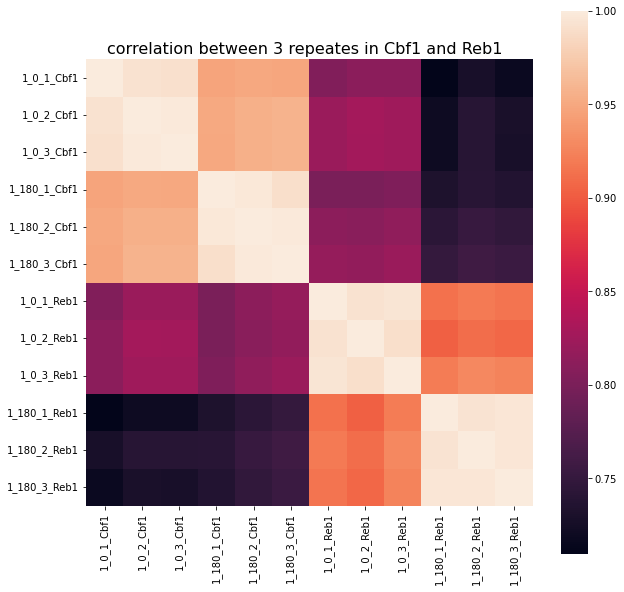

In [11]:


''' correlate Cbf1 and Reb1 together, combine on and off '''
strains = ['Mot3','Cbf1', 'Reb1']
curr_df = pd.DataFrame()
for strain_i, strain in enumerate(strains[1:]):
    if curr_df.shape[1]==0 and strain_i == 0:
        curr_df = res_dict[strain].iloc[:,:6].add_suffix('_'+strain)
        # curr_df['nuc_comb'] = curr_df.index
    
    else:
        added_df = res_dict[strain].iloc[:,:6].add_suffix('_'+strain)
        curr_df = curr_df.merge( added_df, on=('nuc_comb') )

plt.figure(figsize=(10, 10) )
sns.heatmap(curr_df.corr(), square=True)
plt.title('correlation between 3 repeates in '+strains[1]+' and '+strains[2]+'  ', fontsize=16)


## Figure 2B.1 - score vs. error in Cbf1

on GTTA
off ATCT


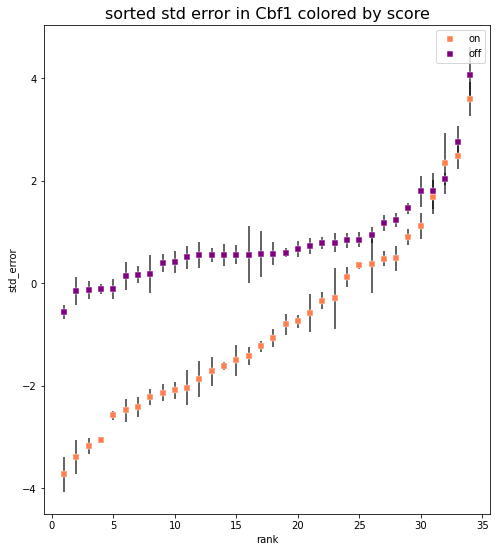

In [12]:
fig, axs = plt.subplots(1,1, figsize=(8,9) )
marker_dict = {'on':'s','off':'s'}
color_dict = {'on':'coral','off':'purple'}
strains = ['Mot3','Cbf1','Reb1']
for strain_i, strain in enumerate(strains[1:2]):
    curr_ax = np.ravel(axs)[strain_i]
    for c_on_i, c_on in enumerate(['on','off']):

        curr_y =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median
        curr_x =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median.rank()
        
        if strain == 'Cbf1':
            print(c_on,curr_y.index[2])
        curr_hue = combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').std_error
        sns.scatterplot(x= curr_x,y= curr_y, color=color_dict[c_on], marker=marker_dict[c_on], label=c_on, ax=curr_ax)
        curr_ax.errorbar(x= curr_x, y=curr_y, yerr=curr_hue, fmt='.', alpha=0.8, color='black', zorder=0)
        
        curr_ax.set_title('sorted std error in '+strain+' colored by score', fontsize=16)
        curr_ax.set_xlabel('rank')
        curr_ax.set_ylabel('std_error')



### Figure 2B.2 - score vs. error, example sequences

### make a swarm plot showing two examples of sequences from the top and bottom of Cbf11

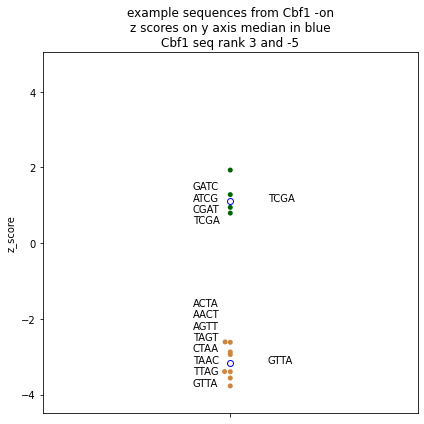

In [13]:
strain = 'Cbf1'
c_on = 'on'
sequences = ['GTTA', 'TCGA']
plt.figure(figsize=(6,6))

inds = [seq_i for seq_i in get_seq_set(sequences[0]) if seq_i in res_dict[strain].query("on_state==@c_on").index]
ind_for_combined_df = [seq_i for seq_i in get_seq_set(sequences[0]) if seq_i in combined_seq_dict[strain+'_'+c_on+'_screened'].index][0]
sns.swarmplot(y=res_dict[strain].query("on_state==@c_on").loc[inds,'z_score'], color='peru')
curr_y = combined_seq_dict[strain+'_'+c_on+'_screened'].loc[ind_for_combined_df].delta_median
curr_x = 0
plt.scatter(x=curr_x , y=curr_y, color='seashell', edgecolor='blue', zorder=3 )
plt.ylim(-4.496128168345136, 5.041307360294333)
plt.text(0.1,curr_y, sequences[0])
for i, ind in enumerate(res_dict[strain].query("on_state==@c_on").loc[inds,'z_score'].index):
    plt.text(-0.1,curr_y-0.6+0.3*i, ind)


inds = [seq_i for seq_i in get_seq_set(sequences[1]) if seq_i in res_dict[strain].query("on_state==@c_on").index]
ind_for_combined_df = [seq_i for seq_i in get_seq_set(sequences[1]) if seq_i in combined_seq_dict[strain+'_'+c_on+'_screened'].index][0]
sns.swarmplot(y=res_dict[strain].query("on_state==@c_on").loc[inds,'z_score'], color='darkgreen')
curr_y = combined_seq_dict[strain+'_'+c_on+'_screened'].loc[ind_for_combined_df].delta_median
curr_x = 0
plt.scatter(x=curr_x , y=curr_y, color='seashell', edgecolor='blue', zorder=3 )
plt.ylim(-4.496128168345136, 5.041307360294333)

plt.text(0.1,curr_y, sequences[1])
for i, ind in enumerate(res_dict[strain].query("on_state==@c_on").loc[inds,'z_score'].index):
    plt.text(-0.1,curr_y-0.6+0.3*i, ind)


plt.title('example sequences from Cbf1 -'+c_on+'\nz scores on y axis median in blue\nCbf1 seq rank 3 and -5',fontsize=12)
plt.tight_layout()


## Figure 2C - Mot3, Cbf1 and Reb1 violins

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Mot3 0.14546629567266992
Cbf1 0.561301143435891


No handles with labels found to put in legend.


Reb1 0.9757611527497394


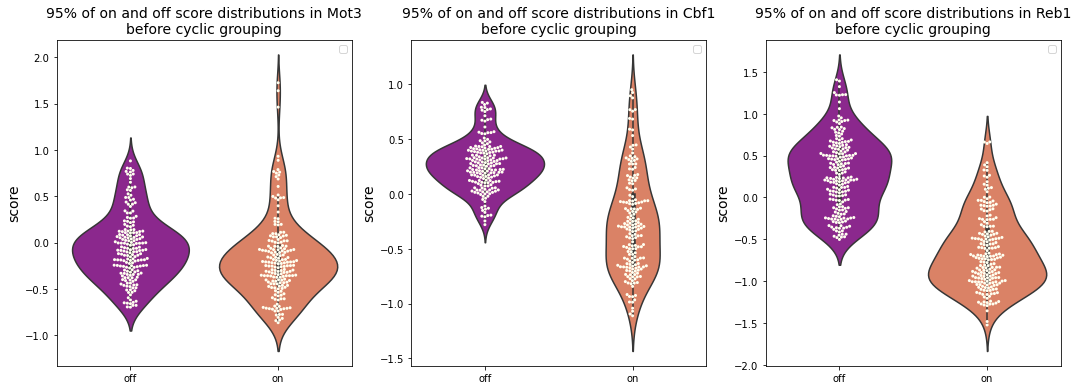

In [14]:
''' show dist before cyclic grouping '''
strains = ['Mot3', 'Cbf1', 'Reb1']
fig, axs = plt.subplots(1,3, figsize=(18,6) )
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]
    curr_x = res_dict[strain].query("on_state=='on'").delta_med180_med0.values
    curr_y = res_dict[strain].query("on_state=='off'").delta_med180_med0.values

    ''' make a sworm plot '''
    curr_df = pd.DataFrame()
   
    mn, mx = np.percentile(res_dict[strain].query("on_state=='off'").delta_med180_med0, [2.5,97.5])
    curr_off = res_dict[strain].query("on_state=='off' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0

    mn, mx = np.percentile(res_dict[strain].query("on_state=='on'").delta_med180_med0, [2.5,97.5])
    curr_on= res_dict[strain].query("on_state=='on' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0

    curr_df = pd.concat( [curr_off, curr_on ] )
    groups = ['off'] * len(curr_off) + ['on'] * len(curr_on)
    
    sns.violinplot(y=curr_df, x=groups, ax=curr_ax, palette='plasma')
    
    sns.swarmplot(y=curr_df, x=groups, ax=curr_ax, color='ivory', s=3, zorder=3)
    
    med_off = curr_off.median()
    med_on = curr_on.median()
    print(strain, med_off-med_on)

    

    curr_ax.legend()
    curr_ax.set_ylabel('score',fontsize=14)
    curr_ax.set_title('95% of on and off score distributions in '+ strain+'\nbefore cyclic grouping', fontsize=14)


## Figure 2D + 2F - on vs. off scatters with groups colored


/apps/RH7U2/gnu/anaconda/2021.11/python/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/apps/RH7U2/gnu/anaconda/2021.11/python/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/apps/RH7U2/gnu/anaconda/2021.11/python/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

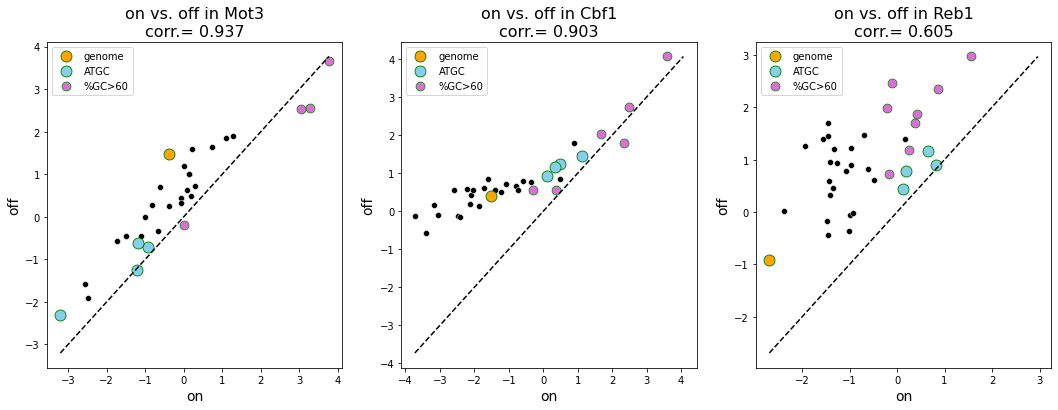

In [15]:
strains = ['Mot3','Cbf1', 'Reb1']
fig, axs = plt.subplots(1,3, figsize=(18,6) )
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]
    curr_x = combined_seq_dict[strain+'_'+'on'+'_screened'].delta_median
    curr_y = combined_seq_dict[strain+'_'+'off'+'_screened'].delta_median
    curr_corr = np.round(pd.concat([curr_x,curr_y],axis=1).corr().iloc[-0,1],3)
    genome_df = pd.DataFrame()
    genome_df.loc['genome','on'] = curr_x.genome
    genome_df.loc['genome','off'] = curr_y.genome
    
    atgc_index = []
    for seq in curr_x.index:
        for cyc_seq in get_seq_set(seq):
            pattern = re.compile(r'(ATGC|ATCG|TAGC|TACG)')
            matches = pattern.findall(cyc_seq)
            if matches:
                atgc_index.append(seq)
    atgc_x = curr_x[atgc_index]
    atgc_y = curr_y[atgc_index]

    gc_x = curr_x[ curr_x.index.map(lambda x: calculate_gc_content(x))>60 ]
    gc_y = curr_y[ curr_y.index.map(lambda x: calculate_gc_content(x))>60 ]

    sns.scatterplot(curr_x, curr_y, ax=curr_ax, color='black', palette='magma')
    sns.scatterplot(x=genome_df['on'], y=genome_df['off'], color='orange', edgecolor='green', s=120, ax=curr_ax, zorder=1, legend=False, label='genome')
    sns.scatterplot(x=atgc_x, y=atgc_y,                   color='skyblue', edgecolor='green', s=120, ax=curr_ax, zorder=1, legend=False, label='ATGC')
    sns.scatterplot(x=gc_x, y=gc_y,                   color='orchid', edgecolor='green', s=80, ax=curr_ax, zorder=1, legend=False, label='%GC>60')
    min_val = min(np.nanmin(curr_x), np.nanmin(curr_y))
    max_val = max(np.nanmax(curr_x), np.nanmax(curr_y))
    curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
    curr_ax.set_title('on vs. off in '+ strain+'\ncorr.= '+str(curr_corr),fontsize=16)
    curr_ax.set_xlabel('on',fontsize=14)
    curr_ax.set_ylabel('off',fontsize=14)
    curr_ax.legend()


## Figure 2E - scatter Reb1 vs. Cbf1 intact

/apps/RH7U2/gnu/anaconda/2021.11/python/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


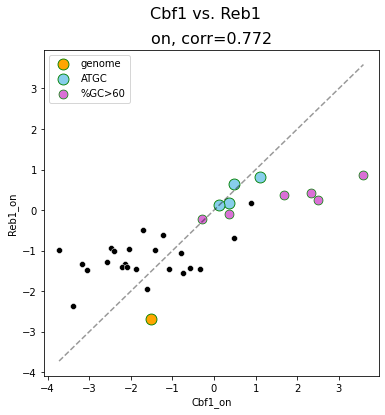

In [16]:
strain1 = 'Cbf1'
strain2= 'Reb1'
fig, axs = plt.subplots(1,1, figsize=(6,6) )
fig.suptitle(strain1+' vs. '+strain2, fontsize=16)
for c_on_i, c_on in enumerate(['on', 'off'][:1]):
    curr_ax = np.ravel(axs)[c_on_i]
    curr_x = combined_seq_dict[strain1+'_'+c_on+'_screened'].delta_median
    curr_y = combined_seq_dict[strain2+'_'+c_on+'_screened'].delta_median
    curr_corr = np.round(pd.concat([curr_x,curr_y],axis=1).corr().iloc[-0,1], 3)
    genome_df = pd.DataFrame()
    genome_df.loc['genome','on'] = curr_x.genome
    genome_df.loc['genome','off'] = curr_y.genome

    atgc_index = []
    for seq in curr_x.index:
        for cyc_seq in get_seq_set(seq):
            pattern = re.compile(r'(ATGC|ATCG|TAGC|TACG)')
            matches = pattern.findall(cyc_seq)
            if matches:
                atgc_index.append(seq)
    atgc_x = curr_x[atgc_index]
    atgc_y = curr_y[atgc_index]

    gc_x = curr_x[ curr_x.index.map(lambda x: calculate_gc_content(x))>60 ]
    gc_y = curr_y[ curr_y.index.map(lambda x: calculate_gc_content(x))>60 ]

    sns.scatterplot(curr_x, curr_y, ax=curr_ax, color='black', palette='magma')
    sns.scatterplot(x=genome_df['on'], y=genome_df['off'], color='orange', edgecolor='green', s=120, ax=curr_ax, zorder=1, legend=False, label='genome')
    sns.scatterplot(x=atgc_x, y=atgc_y,                   color='skyblue', edgecolor='green', s=120, ax=curr_ax, zorder=1, legend=False, label='ATGC')
    sns.scatterplot(x=gc_x, y=gc_y,                   color='orchid', edgecolor='green', s=80, ax=curr_ax, zorder=1, legend=False, label='%GC>60')
    
    min_val = min(np.nanmin(curr_x), np.nanmin(curr_y))
    max_val = max(np.nanmax(curr_x), np.nanmax(curr_y))
    curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', alpha=0.4)
    
    curr_ax.set_xlabel(strain1+'_'+c_on)
    curr_ax.set_ylabel(strain2+'_'+c_on)
    curr_ax.set_title(c_on+', corr='+str(curr_corr),fontsize=16)
    curr_ax.legend()


## Figure 2G - Correlation between Mot3, Cbf1 and Reb1
 plot correlation of all samples, on and off seperately

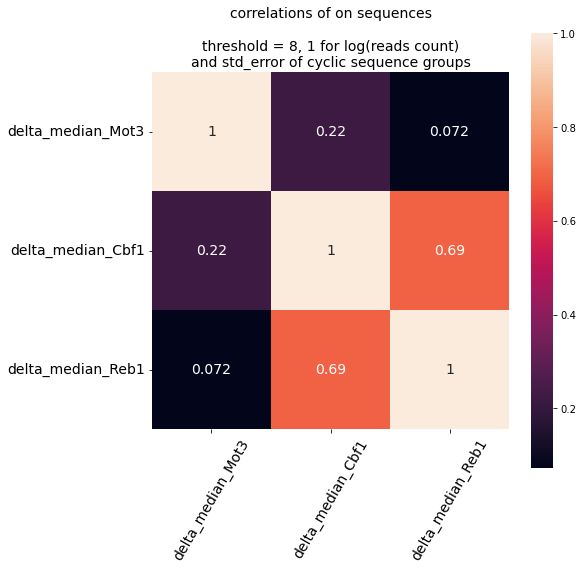

In [17]:
''' plot all samples together, on and off seperately '''

for i, c_on in enumerate(['on','off'][:1]):

    df5 = combined_seq_dict['Mot3'+'_'+c_on+'_screened'].rename_axis('nuc_comb').add_suffix('_Mot3')
    df6 = combined_seq_dict['Cbf1'+'_'+c_on+'_screened'].rename_axis('nuc_comb').add_suffix('_Cbf1')
    df7 = combined_seq_dict['Reb1'+'_'+c_on+'_screened'].rename_axis('nuc_comb').add_suffix('_Reb1')

    # show only Mot3, Cbf1 and Reb1
    df_merged = df5.merge(df6, suffixes=('',''), on=['nuc_comb'])
    df_merged = df_merged.merge(df7, suffixes=('',''), on=['nuc_comb'])

    plt.figure(figsize=(8,8))
    curr_fig = sns.heatmap(df_merged.loc[:,df_merged.columns.str.contains('delta_median_')].corr(),annot=True,square=True, annot_kws={'size': 14})
    plt.title('correlations of '+c_on+' sequences\n\nthreshold = 8, 1 for log(reads count)\nand std_error of cyclic sequence groups', fontsize=14)
    curr_fig.set_xticklabels(curr_fig.get_xticklabels(), rotation=60, size=14)  # Adjust the font size as needed
    curr_fig.set_yticklabels(curr_fig.get_yticklabels(), rotation=0, size=14)  # Adjust the font size as needed


# Figure 3

## figure 3B - Msn2 correlation between 3 repeats of time point 0 (not - activated) and time point 180 (activated)

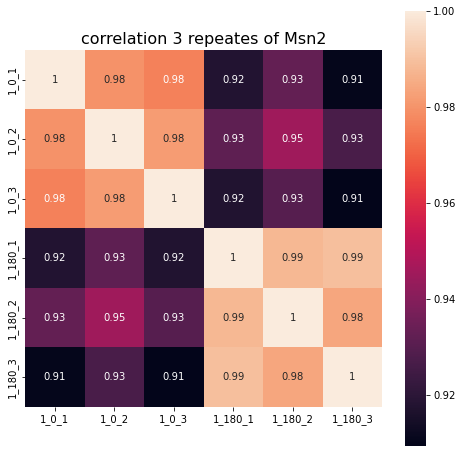

In [18]:
''' correlate 1 TF, its 3 repeates '''
strains = ['Mot3', 'Cbf1', 'Reb1', 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'freeMnase']
for strain_i, strain in enumerate(strains[3:4]):
    curr_df = pd.DataFrame()
    curr_df = res_dict[strain].iloc[:,:6]
    plt.figure(figsize=(8, 8) )
    sns.heatmap(curr_df.corr(), annot=True, square=True)
    plt.title('correlation 3 repeates of ' +strain, fontsize=16)

    # plt.savefig('/home/labs/barkailab/matanv/CCCA/data_context_step_3/plots/figures/figure_3/'+strain+'_all_seq_on_and_off_correlation.pdf')
    plt.show()

## Figure 3C - score vs. error in Msn2

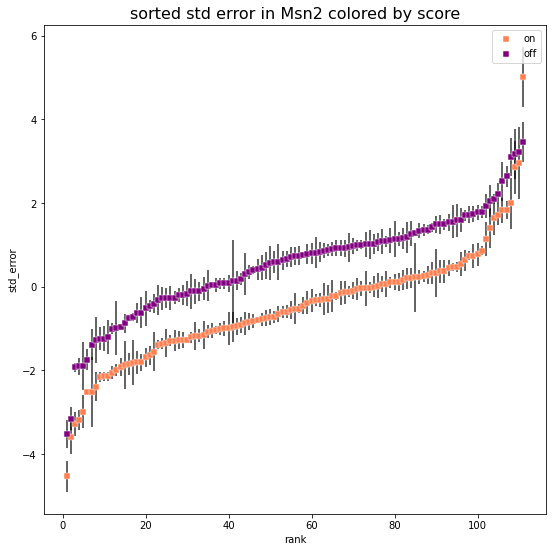

In [19]:
fig, axs = plt.subplots(1,1, figsize=(9,9) )
strains = ['Mot3', 'Cbf1', 'Reb1', 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'freeMnase']
marker_dict = {'on':'s','off':'s'}
color_dict = {'on':'coral','off':'purple'}

for strain_i, strain in enumerate(strains[3:4]):
    curr_ax = np.ravel(axs)[strain_i]
    for c_on_i, c_on in enumerate(['on','off']):
        
        curr_y =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median
        curr_x =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median.rank()
        

        
        curr_hue = combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').std_error
        sns.scatterplot(x= curr_x, y= curr_y, color=color_dict[c_on], marker=marker_dict[c_on], label=c_on, ax=curr_ax)
        curr_ax.errorbar(x= curr_x, y=curr_y, yerr=curr_hue, fmt='.', alpha=0.8, color='black', zorder=0)
        
        curr_ax.set_title('sorted std error in '+strain+' colored by score', fontsize=16)
        curr_ax.set_xlabel('rank')
        curr_ax.set_ylabel('std_error')


## Figure 3D - Msn2 vs. free Mnase

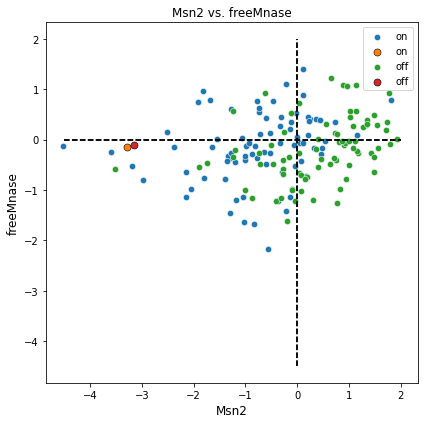

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(6,6) )
strains = ['Mot3', 'Cbf1', 'Reb1', 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'freeMnase']
strain1 = 3
strain2 = 6
for c_on in ['on','off']:
    curr_df = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened']
    samp_on = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened'].delta_median
    samp_off = combined_seq_dict[strains[strain2]+'_'+c_on+'_screened'].delta_median

    genome_df = pd.DataFrame()
    genome_df.loc['genome','on'] = samp_on.genome
    genome_df.loc['genome','off'] = samp_off.genome

    # plot a scatter Tf 1 vs. TF 2
    curr_ax = np.ravel(axs)[0]
    curr_corr = np.round(pd.concat([samp_on,samp_off],axis=1).corr().iloc[0,1],3)
    sns.scatterplot(x=samp_on, y=samp_off, s=40,  ax=curr_ax, label=c_on, legend=False)
    sns.scatterplot(x=genome_df['on'], y=genome_df['off'], edgecolor='black', s=50, ax=curr_ax, label=c_on, zorder=1, legend=False)


    min_val = min(np.nanmin(samp_on), np.nanmin(samp_off))
    max_val = max(np.nanmax(samp_on), np.nanmax(samp_off))

    min_val = -4.5
    max_val = 2
    
    curr_ax.plot([min_val, max_val], [0, 0], linestyle='--', color='black')
    curr_ax.plot([0, 0], [min_val, max_val], linestyle='--', color='black')
    curr_ax.set_title(strains[strain1]+' vs. '+strains[strain2], fontsize=12 )
    curr_ax.set_xlabel(strains[strain1],fontsize=12)
    curr_ax.set_ylabel(strains[strain2],fontsize=12)
    curr_ax.legend()
    plt.tight_layout()

## Figure 3E - Msn2 mutated vs. intact scatter
grouped sequences

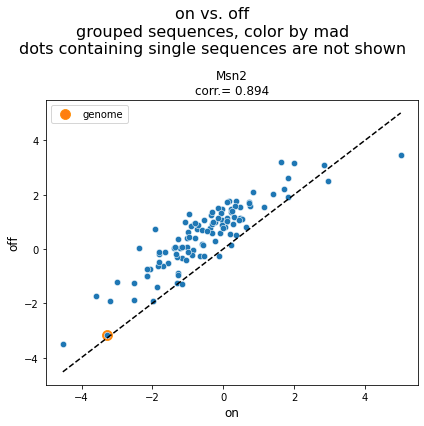

In [21]:
strains = ['Mot3', 'Cbf1', 'Reb1', 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'freeMnase']
fig, axs = plt.subplots(1, 1, figsize=(6,6) )
fig.suptitle('on vs. off\ngrouped sequences, color by mad\ndots containing single sequences are not shown', fontsize=16)

for strain_i, strain in enumerate(strains[3:4]):    
    curr_df = combined_seq_dict[strain+'_on'+'_screened']
    samp_on = combined_seq_dict[strain+'_on'+'_screened'].delta_median
    samp_off = combined_seq_dict[strain+'_off'+'_screened'].delta_median
    genome_df = pd.DataFrame()
    genome_df.loc['genome','on'] = samp_on.genome
    genome_df.loc['genome','off'] = samp_off.genome
    
    # plot a scatter on vs. off
    curr_ax = np.ravel(axs)[strain_i]
    curr_corr = np.round(pd.concat([samp_on,samp_off],axis=1).corr().iloc[-0,1],3)
    sns.scatterplot(x=samp_on, y=samp_off, s=40,  ax=curr_ax, zorder=2, legend=False)
    sns.scatterplot(x=genome_df['on'], y=genome_df['off'], edgecolor='darkorange', s=100, ax=curr_ax, zorder=1, label='genome', legend=False)
    # color sepcial sequences
    # ATGC sequences
    # atgc_index = []
    # for seq in samp_on.index:
    #     for cyc_seq in get_seq_set(seq):
    #         pattern = re.compile(r'(ATGC|ATCG|TAGC|TACG)')
    #         matches = pattern.findall(cyc_seq)
    #         if matches:
    #             atgc_index.append(seq)
    # atgc_x = samp_on[atgc_index]
    # atgc_y = samp_off[atgc_index]
    # # high GC content sequences
    # gc_x = samp_on[ samp_on.index.map(lambda x: calculate_gc_content(x))>60 ]
    # gc_y = samp_off[ samp_off.index.map(lambda x: calculate_gc_content(x))>60 ]
    # sns.scatterplot(x=atgc_x, y=atgc_y, color='skyblue', edgecolor='green', s=120, ax=curr_ax, zorder=1, legend=False, label='ATGC')
    # sns.scatterplot(x=gc_x, y=gc_y,     color='red', edgecolor='orange', s=80, alpha=0.4, ax=curr_ax, zorder=2, legend=False, label='%GC>60')   
    # draw a x=y line
    min_val = min(np.nanmin(samp_on), np.nanmin(samp_off))
    max_val = max(np.nanmax(samp_on), np.nanmax(samp_off))
    curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
    
    curr_ax.set_title(strain+'\ncorr.= '+str(curr_corr), fontsize=12 )
    curr_ax.set_xlabel('on',fontsize=12)
    curr_ax.set_ylabel('off',fontsize=12)
    curr_ax.legend()
plt.tight_layout()
# fig.savefig('/home/labs/barkailab/matanv/CCCA/data_context_step_3/plots/figures/figure_3/msn2_on_vs_off_scatter.pdf')

## Figure 3G - Motif and Context effect in Msn2 and free Mnase

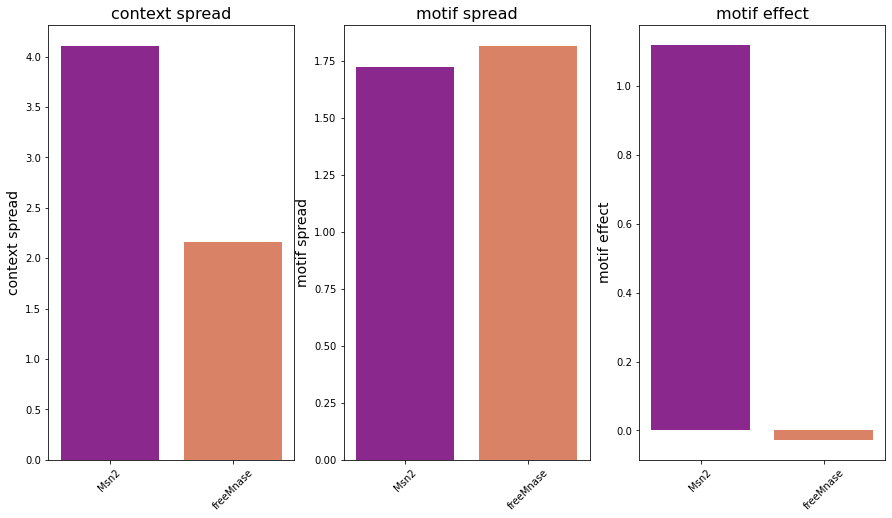

In [22]:
dist_df = pd.DataFrame(columns=['on_spread','off_spread', 'mean_spread','on_d_off_spread','bias'])
strains = ['Msn2', 'freeMnase']
for strain in strains:
    vec_on = combined_seq_dict[strain+'_on'+'_screened'].delta_median
    vec_off = combined_seq_dict[strain+'_off'+'_screened'].delta_median
    dist_df.loc[strain,'on_spread'] =  np.percentile(vec_on,95) - np.percentile(vec_on,5)
    dist_df.loc[strain,'off_spread'] =  np.percentile(vec_off,95) - np.percentile(vec_off,5)
    dist_df.loc[strain,'mean_spread'] =  np.mean([dist_df.loc[strain,'on_spread'], dist_df.loc[strain,'off_spread']])
    dist_df.loc[strain,'on_d_off_spread'] =  np.percentile((vec_on - vec_off),95) - np.percentile((vec_on - vec_off),5)
    dist_df.loc[strain,'bias'] =  (vec_off - vec_on).median(axis=0)
    dist_df.loc[strain,'on_off_corr'] =  pd.concat([vec_on,vec_off],axis=1).corr().iloc[0,1]

fig, axs = plt.subplots(1,3,figsize=(15,8))
titles = ['context spread', 'motif spread', 'motif effect']

# Customize the plot
for col_i, curr_col in enumerate(['mean_spread', 'on_d_off_spread', 'bias']):
    curr_ax = np.ravel(axs)[col_i]
    sns.barplot(x=dist_df.index, y=dist_df.loc[:,curr_col], ax=curr_ax, palette='plasma')
    curr_ax.set_title(titles[col_i], fontsize=16)
    curr_ax.tick_params(axis='x', rotation=45)
    curr_ax.set_ylabel(titles[col_i], fontsize=14)



# Figure 4

## Figure 4B - sequence distribution: Msn2 DBD and Msn2 non DBD violins

Msn2DBDOE 0.39329746138192867


No handles with labels found to put in legend.


Msn2NONDBDOE 0.15570959234701026


No handles with labels found to put in legend.


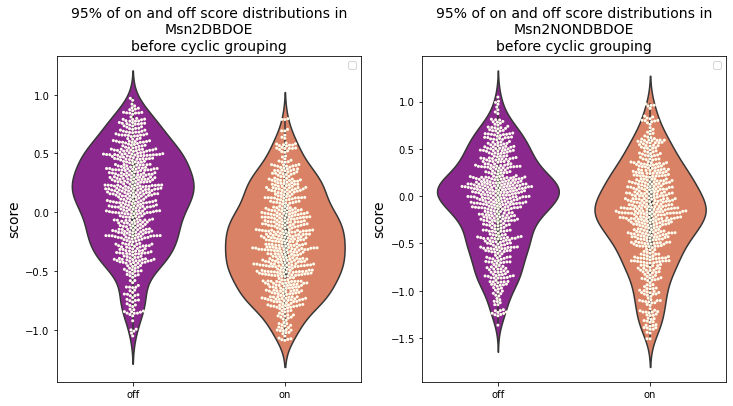

In [23]:
''' show dist before cyclic grouping '''
strains = [ 'Msn2DBDOE', 'Msn2NONDBDOE']
fig, axs = plt.subplots(1,2, figsize=(12,6) )
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]

    
    ''' make a sworm plot '''
    curr_df = pd.DataFrame()
    min_percent = 2.5
    max_percent = 97.5
    mn, mx = np.percentile(res_dict[strain].query("on_state=='off'").delta_med180_med0, [min_percent, max_percent])
    curr_off = res_dict[strain].query("on_state=='off' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0        # use when showing 95 percent of results

    mn, mx = np.percentile(res_dict[strain].query("on_state=='on'").delta_med180_med0, [min_percent, max_percent])
    curr_on= res_dict[strain].query("on_state=='on' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0
    
    curr_df = pd.concat( [curr_off, curr_on ] )
    groups = ['off'] * len(curr_off) + ['on'] * len(curr_on)
    
    med_off = curr_off.median()
    med_on = curr_on.median()
    print(strain, med_off-med_on)
    
    sns.violinplot(y=curr_df, x=groups, ax=curr_ax, palette='plasma')
    sns.swarmplot(y=curr_df, x=groups, ax=curr_ax, color='ivory', s=3, zorder=3)

   

    curr_ax.legend()
    curr_ax.set_ylabel('score',fontsize=14)
    curr_ax.set_title('95% of on and off score distributions in\n'+ strain+'\nbefore cyclic grouping', fontsize=14)


## Figure 4C - Msn2 DBD OE and Msn2 non-DBD OE mutated vs. intact scatter

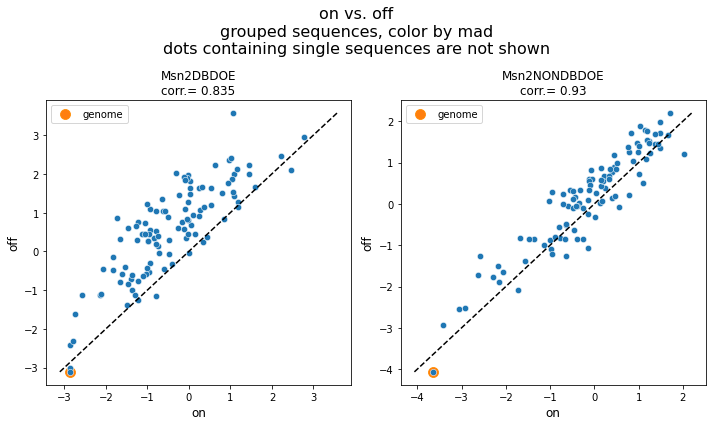

In [24]:
''' plot on vs. off, hide dots with a signle sequence '''
strains = ['Msn2DBDOE','Msn2NONDBDOE']
fig, axs = plt.subplots(1, 2, figsize=(10,6) )
fig.suptitle('on vs. off\ngrouped sequences, color by mad\ndots containing single sequences are not shown', fontsize=16)

for strain_i, strain in enumerate(strains):    
    curr_df = combined_seq_dict[strain+'_on'+'_screened']
    samp_on = combined_seq_dict[strain+'_on'+'_screened'].delta_median
    samp_off = combined_seq_dict[strain+'_off'+'_screened'].delta_median
    genome_df = pd.DataFrame()
    genome_df.loc['genome','on'] = samp_on.genome
    genome_df.loc['genome','off'] = samp_off.genome
    
    # plot a scatter on vs. off

    curr_ax = np.ravel(axs)[strain_i]
    curr_corr = np.round(pd.concat([samp_on,samp_off],axis=1).corr().iloc[-0,1],3)
    sns.scatterplot(x=samp_on, y=samp_off, s=40,  ax=curr_ax, zorder=2, legend=False)
    sns.scatterplot(x=genome_df['on'], y=genome_df['off'], edgecolor='darkorange', s=100, ax=curr_ax, zorder=1, label='genome', legend=False)

    
    min_val = min(np.nanmin(samp_on), np.nanmin(samp_off))
    max_val = max(np.nanmax(samp_on), np.nanmax(samp_off))

    
    curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
    curr_ax.set_title(strain+'\ncorr.= '+str(curr_corr), fontsize=12 )
    curr_ax.set_xlabel('on',fontsize=12)
    curr_ax.set_ylabel('off',fontsize=12)
    curr_ax.legend()
plt.tight_layout()


## Figure 4D - motif and context effect in Msn2 FL, Msn2 DBD OE, Msn2 non-DBD OE and free Mnase

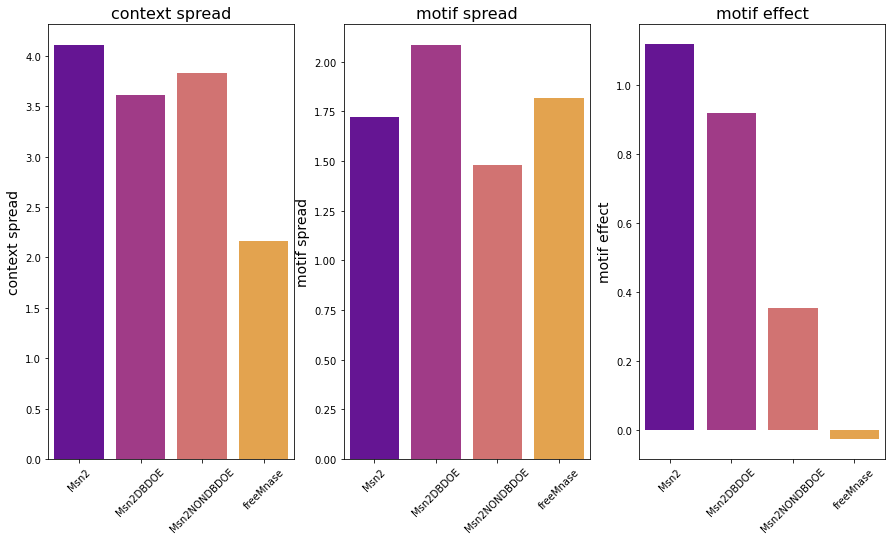

In [25]:
dist_df = pd.DataFrame(columns=['on_spread','off_spread', 'mean_spread','on_d_off_spread','bias'])
strains = ['Msn2', 'Msn2DBDOE','Msn2NONDBDOE','freeMnase']
for strain in strains:
    vec_on = combined_seq_dict[strain+'_on'+'_screened'].delta_median
    vec_off = combined_seq_dict[strain+'_off'+'_screened'].delta_median
    dist_df.loc[strain,'on_spread'] =  np.percentile(vec_on,95) - np.percentile(vec_on,5)
    dist_df.loc[strain,'off_spread'] =  np.percentile(vec_off,95) - np.percentile(vec_off,5)
    dist_df.loc[strain,'mean_spread'] =  np.mean([dist_df.loc[strain,'on_spread'], dist_df.loc[strain,'off_spread']])
    dist_df.loc[strain,'on_d_off_spread'] =  np.percentile((vec_on - vec_off),95) - np.percentile((vec_on - vec_off),5)
    dist_df.loc[strain,'bias'] =  (vec_off - vec_on).median(axis=0)
    dist_df.loc[strain,'on_off_corr'] =  pd.concat([vec_on,vec_off],axis=1).corr().iloc[0,1]

fig, axs = plt.subplots(1,3,figsize=(15,8))
titles = ['context spread', 'motif spread', 'motif effect']

# Customize the plot
for col_i, curr_col in enumerate(['mean_spread', 'on_d_off_spread', 'bias']):
    curr_ax = np.ravel(axs)[col_i]
    sns.barplot(x=dist_df.index, y=dist_df.loc[:,curr_col], ax=curr_ax, palette='plasma')
    curr_ax.set_title(titles[col_i], fontsize=16)
    curr_ax.tick_params(axis='x', rotation=45)
    curr_ax.set_ylabel(titles[col_i], fontsize=14)



## Figure 4E - scatteres of Msn2 FL vs. Msn2 DBD OE vs. Msn2 non-DBD OE

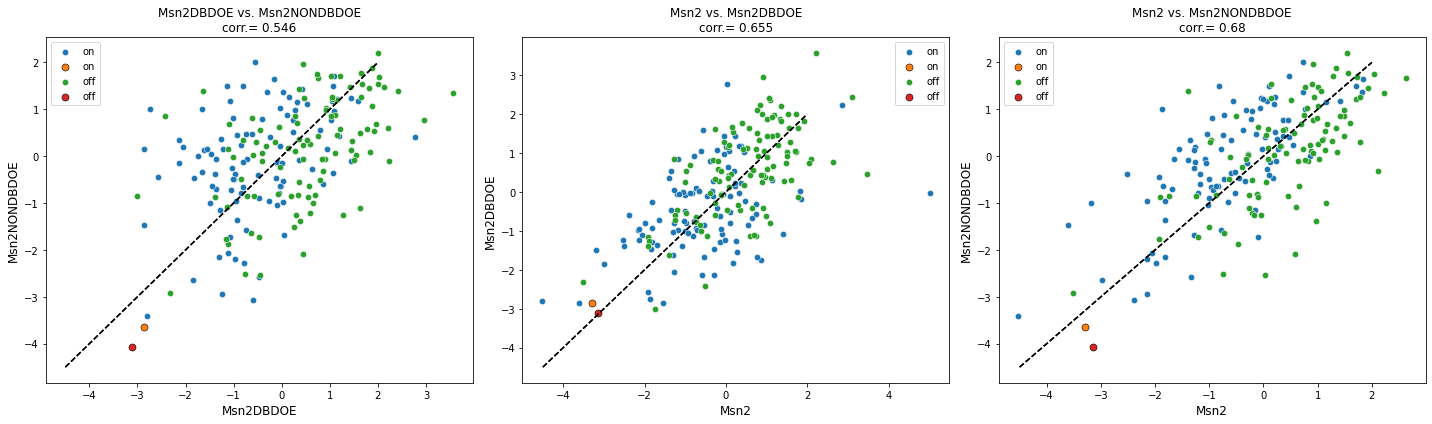

In [26]:
''' plot TF 1 vs. TF 2, hide dots with a signle sequence '''

strains = ['Msn2','Msn2DBDOE','Msn2NONDBDOE', 'freeMnase']
fig, axs = plt.subplots(1, 3, figsize=(20,6) )

strain_combos = [(1,2),(0,1),(0,2)]
for comb_i, strain_comb in enumerate(strain_combos):
    strain1 = strain_comb[0]
    strain2 = strain_comb[1]
    curr_ax = np.ravel(axs)[comb_i]
    for c_on in ['on','off']:
        curr_df = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened']
        samp_on = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened'].delta_median
        samp_off = combined_seq_dict[strains[strain2]+'_'+c_on+'_screened'].delta_median

        genome_df = pd.DataFrame()
        genome_df.loc['genome','on'] = samp_on.genome
        genome_df.loc['genome','off'] = samp_off.genome

        # plot a scatter Tf 1 vs. TF 2
        curr_corr = np.round(pd.concat([samp_on,samp_off],axis=1).corr().iloc[0,1],3)
        sns.scatterplot(x=samp_on, y=samp_off, s=40,  ax=curr_ax, label=c_on, legend=False)
        sns.scatterplot(x=genome_df['on'], y=genome_df['off'], edgecolor='black', s=50, ax=curr_ax, label=c_on, zorder=1, legend=False)

        min_val = min(np.nanmin(samp_on), np.nanmin(samp_off))
        max_val = max(np.nanmax(samp_on), np.nanmax(samp_off))

        min_val = -4.5
        max_val = 2

        curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
        curr_ax.set_title(strains[strain1]+' vs. '+strains[strain2]+'\ncorr.= '+str(curr_corr), fontsize=12 )
        curr_ax.set_xlabel(strains[strain1],fontsize=12)
        curr_ax.set_ylabel(strains[strain2],fontsize=12)
        curr_ax.legend()
        plt.tight_layout()


# Figure 5

## Figure 5B - top 15 bound STRs in Msn2 DBD OE

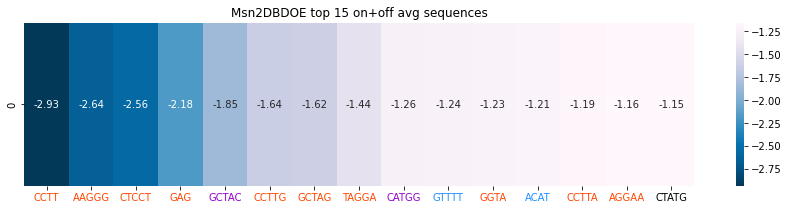

In [27]:
''' top sequences for on+off avg '''
strains = ['Msn2DBDOE']
for strain_i, strain in enumerate(strains):
    curr_df = combined_seq_dict[strain+'_'+'on'+'_screened'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'+'_screened'].query("index!='genome'"), how='inner', suffixes=('_on','_off'), left_index=True, right_index=True )
    curr_df = curr_df.loc[:,curr_df.columns.str.contains('delta_median')]
    curr_df['avg_delta_median'] = curr_df.mean(axis=1)
    curr_df = curr_df.sort_values(by='avg_delta_median')
    curr_df['group'] = curr_df.index.map(lambda x: assign_seq_group(x))
    curr_df['group_color'] = curr_df['group'].map(lambda x: 'orangered' if x[0] == 'AGG' else 'dodgerblue' if x[0] == 'AT_rich' else 'darkviolet' if x[0] == '3G' else 'black')
    
    plt.figure(figsize=(15,3))
    plt.title(strain+' top 15 '+'on+off avg'+' sequences')
    ax = sns.heatmap(curr_df.avg_delta_median[:15].values.reshape(1, -1), annot=True, fmt=".2f", xticklabels=curr_df.index[:15], cmap='PuBu_r')
    for tick_label, color in zip(ax.get_xticklabels(), curr_df['group_color'][:15]):
        tick_label.set_color(color)
    
    plt.show()


## Figure 5D - scatter of triplet contatinig groups, mutated vs. intact

/apps/RH7U2/gnu/anaconda/2021.11/python/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No handles with labels found to put in legend.


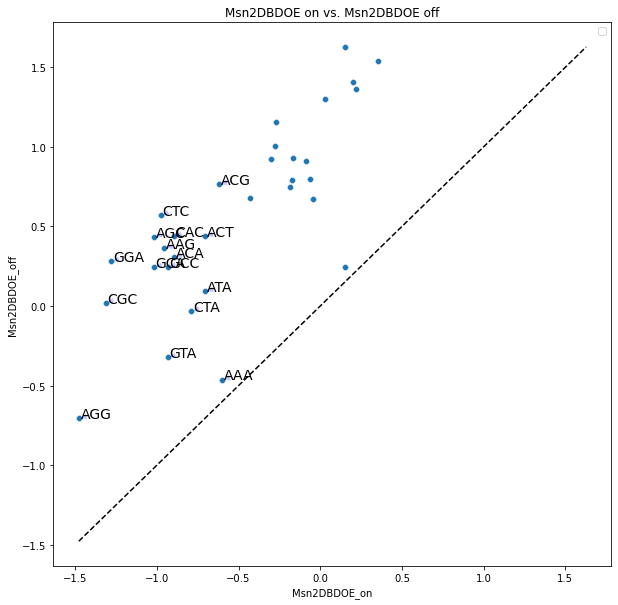

In [28]:
''' plot the mean of all sequences having a trinuc in them '''

trinucs = [
    'AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT',
        'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT',
        'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT',
        'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC', 'CTG', 'CTT',
        'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT',
        'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT',
        'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT',
        'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT'   ]
res_df = pd.DataFrame(index=trinucs)

for strain in ['Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE']:
    for c_on in ['on', 'off']:
        curr_df = combined_seq_dict[strain+'_'+c_on+'_screened'].query("index!='genome'")
        for trinuc in trinucs:
            trinuc_comb_list = get_rev_comp([trinuc])
            # Filter columns in twofactors_tri_df based on the current sequences
            tri_rows_df = curr_df[trinuc_comb_list]
            # Filter for positive rows
            positive_rows = tri_rows_df[(tri_rows_df > 0).any(axis=1)]

            filtered_df = curr_df.loc[positive_rows.index, 'delta_median']
            res_df.loc[trinuc,strain+'_'+c_on] = filtered_df.median()


tri_list = []
for tri in trinucs:
    if get_rev_comp([tri])[1] not in tri_list:
        tri_list.append(tri)

        
plt.figure(figsize=(10, 10))

strain = 'Msn2DBDOE'
for c_on in ['on']:
    curr_x  = res_df[strain+'_'+'on']
    curr_y  = res_df[strain+'_'+'off']
    sns.scatterplot(curr_x, curr_y)

    x_text_on = curr_x
    y_text_on = curr_y
    for seq_i, seq in enumerate(curr_x.index):
        x_text_cor = x_text_on[seq_i]
        y_text_cor = y_text_on[seq_i]
        if seq in tri_list and (x_text_cor<-0.5 or y_text_cor<-0.4):
            plt.annotate(seq,  # Text to display on the dot
                         xy=(x_text_cor, y_text_cor),  # Coordinates of the dot
                         textcoords="data",  # Text position relative to the dot
                         xytext=(x_text_cor+0.01, y_text_cor),  # Offset (in points) from the dot for placing the text
                         ha='left',  # Horizontal alignment of the text
                         color='black' ,
                         arrowprops=dict(arrowstyle='-|>', lw=0.2, color='blue',alpha=0.2), fontsize=14)
            
    min_val = min(np.nanmin(curr_x), np.nanmin(curr_y))
    max_val = max(np.nanmax(curr_x), np.nanmax(curr_y))
    
    plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
    plt.title(strain+' on vs. '+strain+' off')
plt.legend()


# Figure 6

## Figure 6A - top bound sequences in Msn2 FL and Msn2 non-DBD OE

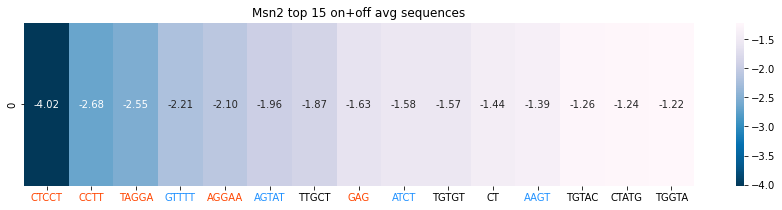

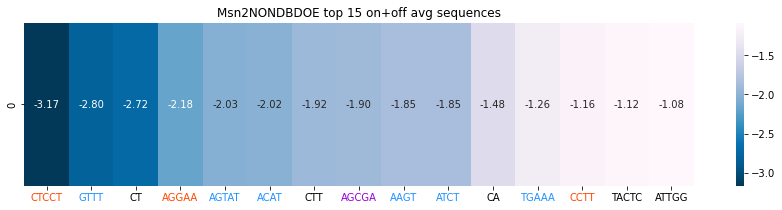

In [29]:
''' top sequences for on+off avg '''
strains = ['Msn2', 'Msn2NONDBDOE']
for strain_i, strain in enumerate(strains):
    curr_df = combined_seq_dict[strain+'_'+'on'+'_screened'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'+'_screened'].query("index!='genome'"), how='inner', suffixes=('_on','_off'), left_index=True, right_index=True )
    curr_df = curr_df.loc[:,curr_df.columns.str.contains('delta_median')]
    curr_df['avg_delta_median'] = curr_df.mean(axis=1)
    curr_df = curr_df.sort_values(by='avg_delta_median')
    curr_df['group'] = curr_df.index.map(lambda x: assign_seq_group(x))
    curr_df['group_color'] = curr_df['group'].map(lambda x: 'orangered' if x[0] == 'AGG' else 'dodgerblue' if x[0] == 'AT_rich' else 'darkviolet' if x[0] == '3G' else 'black')
    
    plt.figure(figsize=(15,3))
    plt.title(strain+' top 15 '+'on+off avg'+' sequences')
    ax = sns.heatmap(curr_df.avg_delta_median[:15].values.reshape(1, -1), annot=True, fmt=".2f", xticklabels=curr_df.index[:15], cmap='PuBu_r')
    for tick_label, color in zip(ax.get_xticklabels(), curr_df['group_color'][:15]):
        tick_label.set_color(color)
    
    plt.show()


## Figure 6B - scatter of sequences colored by sequence features, Msn2 DBD OE vs. Msn2 non-DBD OE

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


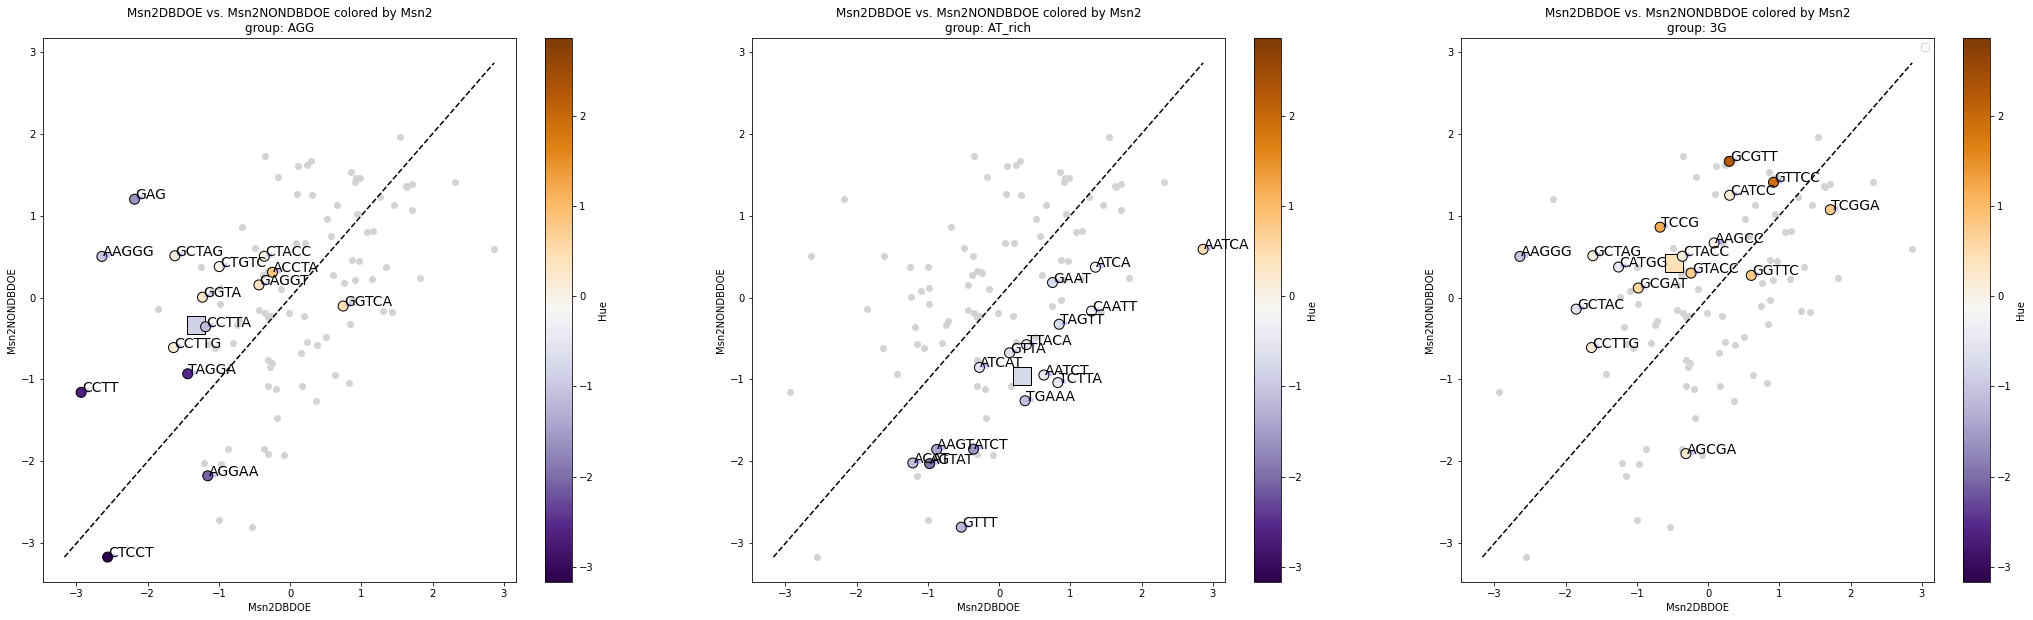

In [33]:
def assign_seq_group(sequence):
    ''' get a sequence as a string and assign it to 1 of 6 sequence groups:\n1. AGG\n2. A/T + 3[G,C] + A/T\n3. %AT >= 75%
        \n4.at least 4 purines - no AGG\n5.at least 4 purines - with AGG\n6. general sequences
    function will look for the sequenece pattern and its reverse compliment (not the cyclic pattern) in the input sequence and in its cyclic options '''
#     build  a decision tree
#     a sequences can be assigned to more than one group, so it has to be put in the tree in different starting points
    group = []
    agggt_pattern = re.compile(r'[AT](GGG|CCC|GCG|CGC|GGC|CGG|CCG|GCC)[AT]')
    cyc_seq = sequence + sequence + sequence
    pur_pyr_count = count_purines_and_pyrimidines(sequence)

    # AGG group
    if 'AGG' in cyc_seq or 'CCT' in cyc_seq:
        group.append('AGG')
    # [AT][GC][GC][GC][AT] group
    if bool(agggt_pattern.search(cyc_seq)):
        group.append('3G')
    # AT rich group
    if calculate_gc_content(cyc_seq) < 26:
        group.append('AT_rich')
    
    if len(group)==0:
        group.append('general_sequence')
    return group


strains = ['Msn2','Msn2DBDOE','Msn2NONDBDOE']
x_strain   = 'Msn2DBDOE'
y_strain   = 'Msn2NONDBDOE'
hue_strain = 'Msn2'
curr_dict = {}
for strain in strains:
    curr_dict[strain] = combined_seq_dict[strain+'_'+'on'+'_screened'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'+'_screened'].query("index!='genome'"), how='inner', suffixes=('_on','_off'), left_index=True, right_index=True )
    curr_dict[strain] = curr_dict[strain].loc[:, curr_dict[strain].columns.str.contains('delta_median')]
    curr_dict[strain]['avg_delta_median'] = curr_dict[strain].mean(axis=1)
    curr_dict[strain]['group'] = curr_dict[strain].index.map(lambda x: assign_seq_group(x))
    curr_dict[strain]['group_color'] = curr_dict[strain]['group'].map(lambda x: 'red' if 'AGG' in x else ('blue' if '3G' in x else ('gold' if 'AT_rich' in x else 'white' ) ) )

    
curr_df  = curr_dict[x_strain].merge(curr_dict[y_strain], how='inner', suffixes=('_'+x_strain,'_'+y_strain), left_index=True, right_index=True )
curr_df2 = curr_dict[hue_strain].merge(curr_dict[hue_strain], how='inner', suffixes=('_'+hue_strain,'_'+hue_strain), left_index=True, right_index=True )
curr_df  = curr_df.merge(curr_df2, how='inner', suffixes=('',''), left_index=True, right_index=True )
duplicated_columns = curr_df.columns[curr_df.columns.duplicated()]
# # Filter DataFrame to keep only non-duplicated columns
curr_df = curr_df.loc[:, ~curr_df.columns.duplicated()]
overall_min = min( curr_df.loc[:, curr_df.columns.str.contains('avg_delta_median')].iloc[:, 0].min(), curr_df.loc[:, curr_df.columns.str.contains('avg_delta_median')].iloc[:, 1].min() )
overall_max = max( curr_df.loc[:, curr_df.columns.str.contains('avg_delta_median')].iloc[:, 0].max(), curr_df.loc[:, curr_df.columns.str.contains('avg_delta_median')].iloc[:, 1].max() )


''' scatter x_strain vs. y_strain, color by hue_strain '''    
fig, axs = plt.subplots(1,3,figsize=(36,10))
for condition_i, condition in enumerate( ['AGG','AT_rich','3G'] ): 

    curr_ax = np.ravel(axs)[condition_i]
    curr_x   = curr_df.loc[:,curr_df.columns.str.contains('avg_delta_median')].iloc[:,0]
    curr_y   = curr_df.loc[:,curr_df.columns.str.contains('avg_delta_median')].iloc[:,1]
    curr_hue = curr_df.loc[:,curr_df.columns.str.contains('avg_delta_median')].iloc[:,2]
    curr_ax.scatter(x = curr_x, y= curr_y, color='lightgray')
    min_val = min(np.nanmin(curr_x), np.nanmin(curr_y))
    max_val = max(np.nanmax(curr_x), np.nanmax(curr_y))
    curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

    curr_x    = curr_df[curr_df['group_Msn2'].apply(lambda x: condition in x )].loc[:,curr_df.columns.str.contains('avg_delta_median')].iloc[:,0]
    curr_y    = curr_df[curr_df['group_Msn2'].apply(lambda x: condition in x )].loc[:,curr_df.columns.str.contains('avg_delta_median')].iloc[:,1]
    curr_hue  = curr_df[curr_df['group_Msn2'].apply(lambda x: condition in x )].loc[:,curr_df.columns.str.contains('avg_delta_median')].iloc[:,2]
    curr_edge = curr_df[curr_df['group_Msn2'].apply(lambda x: condition in x )].loc[:,curr_df.columns.str.contains('group_color')].iloc[:,0]

    x_avg = curr_x.mean()
    y_avg = curr_y.mean()
    hue_avg = curr_hue.mean()

    
    curr_ax.set_xlabel(x_strain)
    curr_ax.set_ylabel(y_strain)
    
#     # Create a colormap for hue values
    cmap = plt.get_cmap('PuOr_r')
    norm = plt.Normalize(overall_min, overall_max)
    if condition_i ==0:
        scatter = curr_ax.scatter(curr_x, curr_y, c=curr_hue, cmap=cmap, norm=norm, s=100, edgecolor= 'black', zorder=2)
        curr_ax.set_title(x_strain+' vs. '+y_strain+' colored by '+hue_strain+'\ngroup: '+str(condition) )
    else:
        scatter = curr_ax.scatter(curr_x, curr_y, c=curr_hue, cmap=cmap, norm=norm, s=100, edgecolor= 'black', zorder=2)
        curr_ax.set_title(x_strain+' vs. '+y_strain+' colored by '+hue_strain+'\ngroup: '+str(condition) )
        
    curr_ax.scatter(x_avg, y_avg, c= hue_avg, cmap=cmap, norm=norm, edgecolor='black', marker = 's', s=320, zorder=1)
    # Create a colorbar for the hue values
    cbar = plt.colorbar(scatter, ax=curr_ax)
    cbar.set_label('Hue')

    # Add legend to the last subplot
    axs[-1].legend()


    
    x_text_on = curr_x
    y_text_on = curr_y
    for seq_i, seq in enumerate(curr_x.index):
        x_text_cor = x_text_on[seq_i]
        y_text_cor = y_text_on[seq_i]
        curr_ax.annotate(seq,  # Text to display on the dot
                     xy=(x_text_cor, y_text_cor),  # Coordinates of the dot
                     textcoords="data",  # Text position relative to the dot
                     xytext=(x_text_cor+0.01, y_text_cor),  # Offset (in points) from the dot for placing the text
                     ha='left',  # Horizontal alignment of the text
                     color='black' ,
                     arrowprops=dict(arrowstyle='-|>', lw=0.2, color='blue',alpha=0.2), fontsize=14)


## Figure 6C - binding score vs. GC content in Msn2 FL, Msn2 DBD OE and Msn2 non-DBD OE

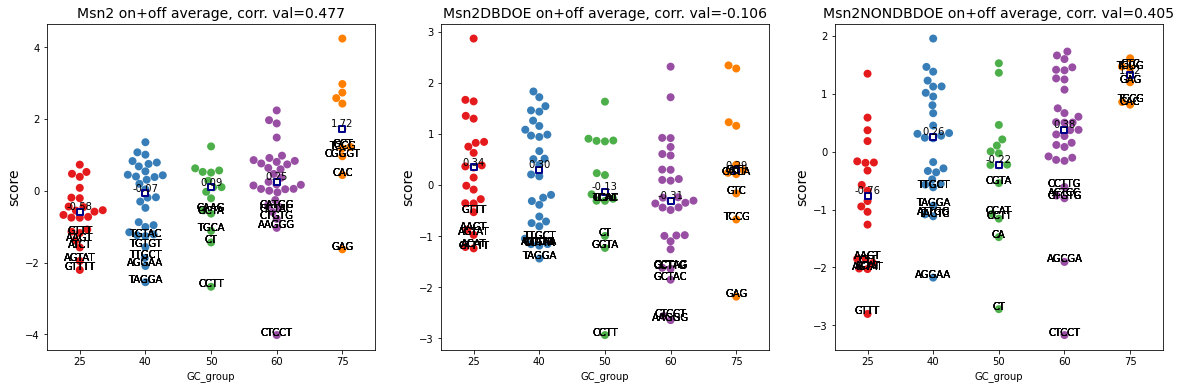

In [34]:
''' plot sequences' score by their % GC '''
''' use the average of on+off '''
 

strains = ['Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE']
curr_dict = {}
corr_list = []
fig, axs = plt.subplots(1,3,figsize=(20,6))
for strain_i, strain in enumerate(strains):
    corr_df = pd.DataFrame()
    curr_ax = np.ravel(axs)[strain_i]
    # curr_ax = axs
    curr_dict[strain] = combined_seq_dict[strain+'_'+'on'+'_screened'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'+'_screened'].query("index!='genome'"), how='inner', suffixes=('','_off'), left_index=True, right_index=True )
    curr_dict[strain]['avg_delta_median'] = curr_dict[strain].loc[:, curr_dict[strain].columns.str.contains('delta_median')].mean(axis=1)
    curr_df = curr_dict[strain]
    curr_df['GC_content'] = np.round(curr_df.index.to_series().apply(calculate_gc_content),2)
    curr_df['GC_group']   = curr_df.GC_content.apply(lambda x: 25 if x<39 else (75 if x>61 else x))
    # curr_df['groups'] = curr_df.index.map(lambda x: assign_seq_group(x)[0])
    # curr_df = curr_df.query("groups=='AGG_A' or groups=='AGG_T' or groups=='AGG_C' or groups=='AGG_G'")
    
    curr_order = [25, 40, 50, 60, 75]
    sns.swarmplot(x=curr_df.GC_group , y=curr_df.avg_delta_median, ax=curr_ax, palette='Set1', s=8, order=curr_order)
    # sns.swarmplot(x=curr_df.on_state , y=curr_df.avg_delta_median, ax=curr_ax, hue=curr_df.groups, palette='Set1', s=8)
    corr_df = pd.concat([ corr_df, curr_df.GC_group], axis=1)
    corr_df = pd.concat([ corr_df, curr_df.avg_delta_median], axis=1)
    corr_val = np.round(corr_df.corr().iloc[0,1],3)
    corr_list.append((strain,corr_val))
    
    for group_i in curr_order:
        median_value = curr_df[curr_df['GC_group'] == group_i]['avg_delta_median'].median()
        curr_ax.text(curr_order.index(group_i), median_value, f'{median_value:.2f}', ha='center', va='bottom', color='black')
        sns.scatterplot(x=[curr_order.index(group_i)], y=[median_value], marker='s', color='ivory', edgecolor='darkblue', linewidth=2, ax=curr_ax, zorder=3)
        
        curr_ax.set_title(strain+' on+off average, corr. val='+str(corr_val), fontsize=14)
        curr_ax.set_ylabel('score', fontsize=14)


        x_text_on = [curr_order.index(group_i)]
        y_text_on = curr_df.avg_delta_median
        for group_i in curr_order:
            for seq in curr_df.query("GC_group==@group_i").sort_values(by='avg_delta_median')[:5].index:
                    x_text_cor = curr_order.index(group_i)
                    y_text_cor = y_text_on[seq]
                    curr_ax.annotate(seq,  # Text to display on the dot
                                 xy=(x_text_cor, y_text_cor),  # Coordinates of the dot
                                 textcoords="data",  # Text position relative to the dot
                                 xytext=(x_text_cor, y_text_cor),  # Offset (in points) from the dot for placing the text
                                 ha='center',  # Horizontal alignment of the text
                                 color='black' ,
                                  fontsize=10)


## Figure 6D - binding score colored for AGG-N in Msn2 FL, Msn2 DBD OE and Msn2 non-DBD OE

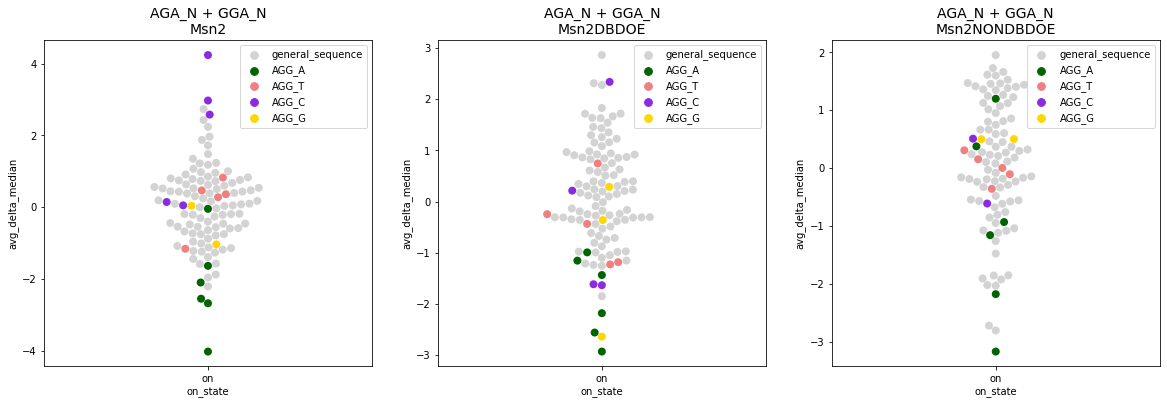

In [35]:
''' plot sequences' score and color by sequence groups '''
''' use the average of on+off '''
 
    
# grouping function
def assign_seq_group(sequence):
    ''' get a sequence as a string and assign it to 1 of 4 sequence groups:\n1. AGG_A\n2. AGG_T\n3. AGG_C
        \n4.at least 4 purines - no AGG\n5.at least 4 purines - with AGG\n6. general sequences
    function will look for the sequenece pattern and its reverse compliment (not the cyclic pattern) in the input sequence and in its cyclic options '''
#     build  a decision tree
#     a sequences can be assigned to more than one group, so it has to be put in the tree in different starting points
    group = []
    cyc_seq = sequence + sequence + sequence
      
    # AGG-N groups
    if 'AGGA' in cyc_seq or 'TCCT' in cyc_seq:
        group.append('AGG_A')
    if 'AGGT' in cyc_seq or 'ACCT' in cyc_seq:
        group.append('AGG_T')
    if 'AGGC' in cyc_seq or 'GCCT' in cyc_seq:
        group.append('AGG_C')
    if 'AGGG' in cyc_seq or 'CCCT' in cyc_seq:
        group.append('AGG_G')

    
    if len(group)==0:
        group.append('general_sequence')
    return group
    
    
    
    

strains = ['Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE']
curr_dict = {}
corr_list = []
custom_palette = {'AGG_A': 'darkgreen','AGG_C': 'blueviolet','AGG_G': 'gold','AGG_T': 'lightcoral','general_sequence':'lightgray'}
fig, axs = plt.subplots(1,3,figsize=(20,6))
for strain_i, strain in enumerate(strains):
    corr_df = pd.DataFrame()
    curr_ax = np.ravel(axs)[strain_i]

    curr_dict[strain] = combined_seq_dict[strain+'_'+'on'+'_screened'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'+'_screened'].query("index!='genome'"), how='inner', suffixes=('','_off'), left_index=True, right_index=True )
    curr_dict[strain]['avg_delta_median'] = curr_dict[strain].loc[:, curr_dict[strain].columns.str.contains('delta_median')].mean(axis=1)
    curr_df = curr_dict[strain]

    curr_df['groups'] = curr_df.index.map(lambda x: assign_seq_group(x)[0])

    sns.swarmplot(x=curr_df.on_state , y=curr_df.avg_delta_median, ax=curr_ax, hue=curr_df.groups, palette=custom_palette, s=8)


    curr_ax.set_title('AGA_N + GGA_N\n'+strain, fontsize=14)
    curr_ax.legend(loc='upper right')


# Figure 7

## load functions and set directory

In [37]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from Bio.Seq import Seq
import re
from Bio import pairwise2
import itertools
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

curr_data_path = os.path.join(original_path, 'human_genome')
os.chdir( curr_data_path )

def get_rev_comp(sequnce_list):
    past_seqs = []
    for seq in sequnce_list:
        seq_obj = Seq(seq)
        search_string = str(seq_obj.reverse_complement())
        if  search_string in past_seqs or seq in past_seqs:
            continue
        else:
            past_seqs.extend([seq,search_string])
    return past_seqs
def get_cyclic_seq(sequence):
    """ input a [sequence] and get all cyclic combiantions of it as a set
    """
    cyc_seqs = []
    seq_len = len(sequence)
    for i in range(seq_len):
        cyc_seqs.append(sequence[i+1:]+sequence[:i+1])
    return set(cyc_seqs)
def get_seq_set(sequence):
    """ emter a [sequence] and get all posiible cyclic and reverse compliments of it as a set
    """
    seq_set = []
    seq_len = len(sequence)
    seq_set.extend( get_rev_comp([ str(sequence) ]) )
    if seq_set[0] == seq_set[1]:
        seq_set.remove(seq_set[1])
        seq_set.extend(get_cyclic_seq(seq_set[0]))
    else:
        seq_set.extend(get_cyclic_seq(seq_set[0]))
        seq_set.extend(get_cyclic_seq(seq_set[1]))
    return set(seq_set)

def rep_list(curr_list):
    return len(curr_list)*[curr_list]

def lambda_count(first,second):
    return lambda x:(x.count(first) + x.count(second)) / len(x)

human_reps = pd.read_csv('fig_S3_data.csv',index_col=0)
human_reps.set_index('repeat_unit', inplace=True)
new_inds = []
for ind in human_reps.index:
    if len(ind)<2:
        new_inds.append(ind*2)
    else:
        new_inds.append(ind)
human_reps.index = new_inds

## Figure 7A - Msn2 non-DBD OE score vs. total STR length

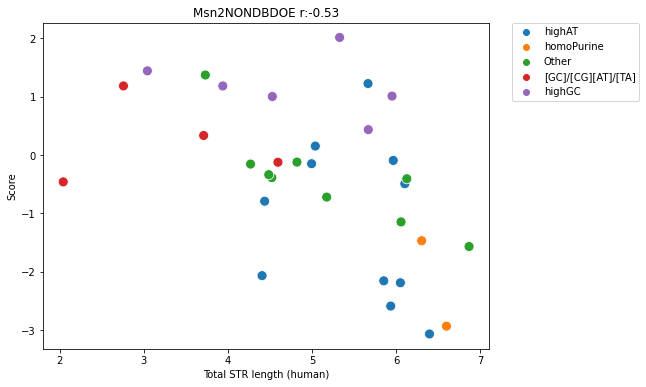

In [38]:
curr_tf = 'Msn2NONDBDOE'
# scat_order = ['highGC','[GC]/[CG][AT]/[TA]','Other']
# tfs = ['Msn2','Msn2DBDOE','Msn2NONDBDOE','Reb1','Mot3','Cbf1','freeMnase']
# data_int = ['delta_median_on','delta_median_off']
# corrs = np.empty((len(tfs),len(data_int)))

# for c,curr_data in enumerate(data_int):
fig,curr_ax = plt.subplots(1,1,figsize=(8,6))
fig.subplots_adjust(hspace=0.5,wspace=0.5)

binding_df = pd.read_csv(curr_tf+'_avg(on,off)_sorted.csv',index_col=0)
list_of_opts = []
for curr_str in binding_df.index:
    list_of_opts.append(list(get_seq_set(curr_str)))

binding_df['opt_len'] = [len(clist) for clist in list_of_opts]
for_df = []
for curr_list in list_of_opts:
    for_df.extend(rep_list(curr_list))
# list(map(rep_list,list_of_lists))
str_dict = dict(zip(np.concatenate(np.array(list_of_opts,dtype=object)),for_df))
fin_df = pd.DataFrame({key:pd.Series(value) for key,value in str_dict.items()}).T

lengths_dict = binding_df['opt_len'].to_dict()
avgs_dict = binding_df['delta_median_on'].to_dict()
fin_df['values'] = np.concatenate(binding_df.reset_index().loc[:,'index'].apply(lambda x: lengths_dict[x]*[(avgs_dict[x])]).values)
fin_df['original'] = fin_df.drop('values',axis=1).reset_index().loc[:,0].values
combined_df = pd.concat([human_reps,fin_df],axis=1)
combined_df['log_sum'] = combined_df.summed_length.apply(np.log10).values
combined_df = combined_df.loc[combined_df.summed_length.dropna().index,:].sort_values(by='values')

mfunc = lambda_count('A','T')
highAT = list((combined_df.reset_index()['index'].apply(mfunc)>0.6).values)
mfunc = lambda_count('G','C')
highGC = list((combined_df.reset_index()['index'].apply(mfunc)>0.6).values)
doubleGCAT = ['GCAT','CGAT','GCTA','CGTA']
in_str = []
for curr_str in combined_df.index:
    curr_str = curr_str*3
    in_str.append(any(substring in curr_str for substring in doubleGCAT))

mfunc = lambda_count('G','A')
homoPurinesA = (combined_df.reset_index()['index'].apply(mfunc)==1).values
mfunc = lambda_count('C','T')
homoPurinesB = (combined_df.reset_index()['index'].apply(mfunc)==1).values
homoPurines = np.logical_or(homoPurinesA,homoPurinesB)
    
STR_info = ['highGC' if b1 else '[GC]/[CG][AT]/[TA]' if b2 else 'highAT' 
            if b3 else 'homoPurine' if b4 else 'Other' for b1, b2, b3 ,b4
            in zip(highGC, in_str,highAT,homoPurines)]
combined_df['STR_info'] = STR_info
combined_df['STR_len'] = combined_df.reset_index()['index'].apply(len).values

# curr_ax = axes.ravel()[i]
# sns.scatterplot(data=combined_df,x='log_sum',y='values',hue='STR_info', s=100, ax=curr_ax, hue_order=scat_order, style='STR_len')
sns.scatterplot(data=combined_df,x='log_sum',y='values',hue='STR_info', s=100, ax=curr_ax)

curr_ax.set_title(curr_tf + ' r:' + str(np.round(combined_df.corr(method='spearman').iloc[1,2],2)))
curr_ax.set_ylabel('Score')
curr_ax.set_xlabel('Total STR length (human)')
curr_ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    # for i in combined_df.index:
            # curr_ax.annotate(i,(combined_df.log_sum[i],combined_df.loc[i,'values']))
# fig.savefig('nonDBDvhuman.pdf')

## Figure 7B - score vs. total STR length correlation

In [ ]:
curr_tf = 'Msn2'
scat_order = ['highGC','[GC]/[CG][AT]/[TA]','Other']
tfs = ['Msn2','Msn2DBDOE','Msn2NONDBDOE','Reb1','Mot3','Cbf1','freeMnase']
data_int = ['delta_median_on','delta_median_off']
corrs = np.empty((len(tfs),len(data_int)))

for c,curr_data in enumerate(data_int):
    # fig,axes = plt.subplots(3,3,figsize=(15,15))
    # fig.subplots_adjust(hspace=0.5,wspace=0.5)
    for i,curr_tf in enumerate(tfs):
        binding_df = pd.read_csv(curr_tf+'_avg(on,off)_sorted.csv',index_col=0)
        list_of_opts = []
        for curr_str in binding_df.index:
            list_of_opts.append(list(get_seq_set(curr_str)))

        binding_df['opt_len'] = [len(clist) for clist in list_of_opts]
        for_df = []
        for curr_list in list_of_opts:
            for_df.extend(rep_list(curr_list))
        # list(map(rep_list,list_of_lists))
        str_dict = dict(zip(np.concatenate(np.array(list_of_opts,dtype=object)),for_df))
        fin_df = pd.DataFrame({key:pd.Series(value) for key,value in str_dict.items()}).T

        lengths_dict = binding_df['opt_len'].to_dict()
        avgs_dict = binding_df[curr_data].to_dict()
        fin_df['values'] = np.concatenate(binding_df.reset_index().loc[:,'index'].apply(lambda x: lengths_dict[x]*[(avgs_dict[x])]).values)
        fin_df['original'] = fin_df.drop('values',axis=1).reset_index().loc[:,0].values
        combined_df = pd.concat([human_reps,fin_df],axis=1)
        combined_df['log_sum'] = combined_df.summed_length.apply(np.log10).values
        combined_df = combined_df.loc[combined_df.summed_length.dropna().index,:].sort_values(by='values')
        corrs[i,c] = np.round(combined_df.corr(method='spearman').iloc[1,2],2)

        mfunc = lambda x:(x.count('G') + x.count('C')) / len(x)
        highGC = list((combined_df.reset_index()['index'].apply(mfunc)>0.6).values)
        doubleGCAT = ['GCAT','CGAT','GCTA','CGTA']
        in_str = []
        for curr_str in combined_df.index:
            curr_str = curr_str*3
            in_str.append(any(substring in curr_str for substring in doubleGCAT))
        STR_info = ['highGC' if b1 else '[GC]/[CG][AT]/[TA]' if b2 else 'Other' for b1, b2 in zip(highGC, in_str)]
        combined_df['STR_info']=STR_info
        combined_df['STR_len'] = combined_df.reset_index()['index'].apply(len).values

#         curr_ax = axes.ravel()[i]
#         # sns.scatterplot(data=combined_df,x='log_sum',y='values',hue='STR_info', s=100, ax=curr_ax, hue_order=scat_order, style='STR_len')
#         sns.scatterplot(data=combined_df,x='log_sum',y='values',hue='STR_info', s=100, ax=curr_ax)

#         curr_ax.set_title(curr_tf + ' r:' + str(np.round(combined_df.corr(method='spearman').iloc[1,2],2)))
#         curr_ax.set_ylabel('Score')
#         curr_ax.set_xlabel('Total STR length (human)')
#         curr_ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        # for i in combined_df.index:
            # curr_ax.annotate(i,(combined_df.log_sum[i],combined_df.loc[i,'values']))
corr_df = pd.DataFrame(corrs,index=tfs,columns=['ON','OFF'])
corr_df = corr_df.loc[corr_df.mean(axis=1).sort_values().index,:]
fig,ax = plt.subplots(1,1,figsize=(2,6))
sns.heatmap(corr_df,cmap='vlag',center=0,ax=ax)
# fig.savefig('datavhuman_corrs.pdf')

## Figure 7C - fraction of promoteres

### load functions and set directory

In [47]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from Bio.Seq import Seq
import re
from Bio import pairwise2
import itertools
import io
import pyranges as pr
from scipy.stats import zscore

curr_data_path = os.path.join(original_path, 'yeast_genome')
os.chdir( curr_data_path )

tf_binding_z = zscore(pd.read_csv(curr_data_path+'/tfs_sumprom.csv'),nan_policy='omit')
prom_pos =  np.load(curr_data_path+'/promoter_pos_by_length.npy')
opn_score = pd.read_csv(curr_data_path+'/opn_mine.csv',index_col=0)
gene_id = opn_score.reset_index().drop('opn_score',axis=1)

import _pickle as cPickle
import pickle
import bz2
def decompress_pickle(file):
    '''Load any compressed pickle file.'''
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data
cerGen = decompress_pickle(curr_data_path+'/cerGenome.pbz2')
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42


### Figure code

<AxesSubplot:>

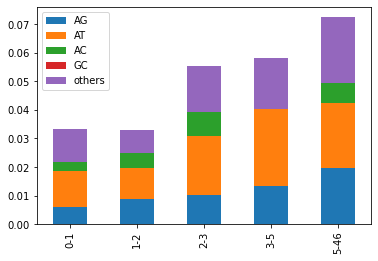

In [48]:
chr_dict = {1: 'I',
 2: 'II',
 3: 'III',
 4: 'IV',
 5: 'V',
 6: 'VI',
 7: 'VII',
 8: 'VIII',
 9: 'IX',
 10: 'X',
 11: 'XI',
 12: 'XII',
 13: 'XIII',
 14: 'XIV',
 15: 'XV',
 16: 'XVI'}

chr_dict = dict(zip(chr_dict.values(),chr_dict.keys()))
cols = ['Start','End','PeriodSize','STR_size','CopyN','PercentMatch','PercentIndels','Score','A','C','G','T','Entropy','STR','Seq']

with open('Saccer3.2.3.5.80.10.30.6.txt', 'r') as file:
    data = file.read()
    
parsed_strs = pd.DataFrame()
for i in range(1,len(data.split('Sequence'))-1):
    curr_chromo_dat = data.split('Sequence')[i]
    curr_chromosome = chr_dict[curr_chromo_dat.split('complete sequence')[0].split(' ')[-2].split(',')[0]]
    f = io.StringIO(curr_chromo_dat.split('complete sequence')[1].replace('"',''))
    curr_df = pd.read_csv(f,delim_whitespace=True,header=None,names=cols)
    curr_df['Chromosome'] = curr_df.shape[0]*[curr_chromosome]
    parsed_strs = pd.concat([parsed_strs,curr_df],axis=0)
parsed_strs = parsed_strs.reset_index().drop('index',axis=1)
parsed_strs['Length'] = parsed_strs.End.values-parsed_strs.Start.values
parsed_strs['STR_ID'] = parsed_strs.index


prom_info = pd.DataFrame(prom_pos).astype(int)
prom_info.columns = ['Chromosome','Start','End','Strand']
prom_info.Chromosome = prom_info.Chromosome+1
prom_info['prom_length'] = prom_pos[:,2] - prom_pos[:,1]
prom_info = prom_info.query('Strand!=0')
prom_info = prom_info.drop('Strand',axis=1)
prom_info['prom_length'] = prom_info['prom_length'].astype(int)

per_GC = []
for prom in prom_info.index:
    curr_locs = prom_info.loc[prom,:]
    curr_seq = cerGen['chr'+str(curr_locs['Chromosome'])][curr_locs['Start']:curr_locs['End']]
    per_GC.append((curr_seq.count('G') + curr_seq.count('C')) / len(curr_seq))
prom_info['GC'] = per_GC

sorted_opn = opn_score.reset_index().reset_index().set_index('name')
sorted_opn['opn_score'] = sorted_opn['opn_score'].replace(-np.inf, np.nan)
sorted_opn['opn_score'] = sorted_opn['opn_score'].replace(np.inf, np.nan)

sorted_opn = sorted_opn.dropna().sort_values('opn_score')
sorted_opn.reset_index(inplace=True)
sort_length = []
for curr_id in sorted_opn['index']:
    sort_length.append(prom_info.loc[curr_id,'prom_length'])
sorted_opn['prom_length'] = sort_length


combined_pr = pr.PyRanges(prom_info.reset_index()).join(pr.PyRanges(parsed_strs)).df
# print(combined_pr)
# combined_pr = combined_pr.set_index('index')
choreg_right = combined_pr.loc[combined_pr['End_b']>combined_pr['End']].index
combined_pr.loc[choreg_right,'End_b'] = combined_pr.loc[choreg_right,'End']
choreg_left = combined_pr.loc[combined_pr['Start_b']<combined_pr['Start']].index
combined_pr.loc[choreg_left,'Start_b'] = combined_pr.loc[choreg_left,'Start']
combined_pr['STR_prom_len'] = combined_pr['End_b'].values-combined_pr['Start_b'].values
combined_pr['Repeat_unit'] = combined_pr['STR_prom_len']/combined_pr['CopyN']
combined_pr = combined_pr.set_index('index').drop([526, 1487],axis=0).reset_index()
# combined_pr['Repeat_unit'] = combined_pr['Repeat_unit'].astype(int)
# combined_pr = combined_pr.reset_index()
# combined_pr
non_rep_STRs = combined_pr.loc[:,['STR_ID','STR_prom_len']].groupby('STR_ID').idxmax().values.flatten()
combined_pr = combined_pr.loc[non_rep_STRs,:]
match_thrs = 80
combined_pr = combined_pr.query("PercentMatch>@match_thrs")

fin_df = pd.DataFrame()
num_tf_bound = ((tf_binding_z>3).sum(axis=1)).loc[prom_info.index]
# num_tf_bound = num_tf_bound.loc[prom_info.index]
mean_prom_GC = []
bound_bins = [0,1,2,3,5,num_tf_bound.max()]
p_number = []
for i in range(len(bound_bins)-1):
    # print(((num_tf_bound>=bound_bins[i]) & (num_tf_bound<bound_bins[i+1])).sum())
    curr_set = num_tf_bound.loc[((num_tf_bound>=bound_bins[i]) & (num_tf_bound<bound_bins[i+1]))].index
    p_number.append(curr_set.shape[0])
    mean_prom_GC.append(prom_info.loc[curr_set,'GC'].mean())
    set_strs = list(set(combined_pr['index'].values).intersection(curr_set))
    set_strs = combined_pr.reset_index().set_index('index').loc[set_strs]
    set_strs = set_strs.iloc[set_strs.reset_index().loc[:,['index','Repeat_unit']].groupby('index').idxmax().Repeat_unit]
    set_strs = set_strs.query('PeriodSize>1')
    num_bound = num_tf_bound.loc[set_strs.index].values

    tss_dist = []
    who_str = []
    who_prom = []
    rep_unit = []
    for idx in set_strs.index:
        who_str.append(set_strs.loc[idx]['STR'])
        who_prom.append(gene_id.loc[idx]['name'])
        rep_unit.append(set_strs.loc[idx]['Repeat_unit'])
        if prom_pos[idx,3]>1:
            tss_dist.append(set_strs.loc[idx,'Start_b']-set_strs.loc[idx,'Start'])
        else:
            tss_dist.append(set_strs.loc[idx,'End']-set_strs.loc[idx,'End_b'])
    mb_summary = pd.DataFrame([who_str,num_bound,tss_dist,rep_unit],columns=[who_prom]).T
    mb_summary.columns = ['STR','TF_number','Distance_tss','number_of_reps']
    mb_summary['set'] = [str(bound_bins[i]) + '-' + str(bound_bins[i+1])]*mb_summary.shape[0]
    fin_df = pd.concat([fin_df,mb_summary])
mfunc = lambda x:(x.count('G') + x.count('C')) / len(x)
fin_df['STR_GC'] = fin_df['STR'].apply(mfunc).values
# sns.barplot(x=fin_df['set'].value_counts(sort=False).index,y=fin_df['set'].value_counts(sort=False).values/p_number)

min_rep = 2
fin_df = fin_df.query('number_of_reps>@min_rep')
count_types = pd.DataFrame()
cols = []
for i in range(len(bound_bins)-1):
    cols.append(str(bound_bins[i]) + '-' + str(bound_bins[i+1]))
    curr_bin = str(bound_bins[i]) + '-' + str(bound_bins[i+1])
    
    df_sub = fin_df.query('set==@curr_bin').copy()
    curr_STRs = df_sub['STR'].values
    num_AG = len([s for s in curr_STRs if all(c in 'AG' for c in s) or all(c in 'TC' for c in s)])
    num_AT = len([s for s in curr_STRs if all(c in 'AT' for c in s)])
    num_AC = len([s for s in curr_STRs if all(c in 'AC' for c in s) or all(c in 'GT' for c in s)])
    num_GC = len([s for s in curr_STRs if all(c in 'GC' for c in s)])
    num_others = len(curr_STRs)-num_AG-num_AT-num_AC-num_GC
    count_types = pd.concat([count_types,pd.Series(np.array([num_AG,num_AT,num_AC,num_GC,num_others])/p_number[i])],axis=1)
count_types.columns = cols
count_types.index = ['AG','AT','AC','GC','others']
count_types.T.plot(kind='bar', stacked=True)



# Figure S1

## Figure S1A - % of sequences above threshold for Cbf1, Reb1 and Mot3

/tmp/ipykernel_183852/2642729425.py:50: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
/tmp/ipykernel_183852/2642729425.py:51: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df

Text(0.5, 1.0, '% of sequences above threshold')

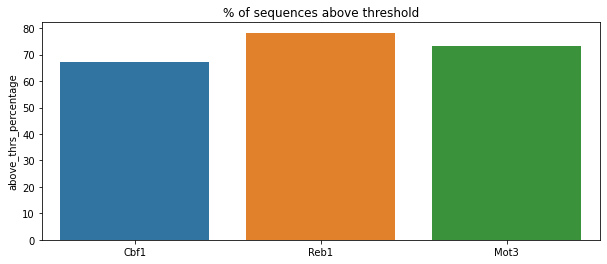

In [56]:
# load data

def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
          
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)       
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)
    if threshold!=0:
        lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

      
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows





Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE','freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
# res_dict = {}
threshold = 0
strains_list = [Msn2_strains, strains_2]
libs_list    = [Msn2_libs, libs_2]
thrs_seq_count_dict = {}

for threshold in [0,8]:
    res_dict = {}

    for strain_list_i, strains in enumerate( strains_list ):

        for strain_i, strain in enumerate(strains):

            if strain == 'freeMnase':
                os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
                rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')
                exp_num = 30
            else:
                os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
                rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')
                exp_num = 29

            for lib_i, lib in enumerate(libs_list[strain_list_i][strain_i]):
                thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len( libs_list[strain_list_i][strain_i] )] * len(strains)] 
                thsld = thsld_list_8[strain_i][lib_i]

                lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')

                if strain+'_on' not in res_dict.keys():
                    res_dict[strain] = lib_df
                    res_dict[strain+'_on'] = on_rows
                    res_dict[strain+'_off'] =  off_rows
                else:
                    res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
                    res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
                    res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])

    # count sequences in each strain for threshold 8 and threshold 0
    for strain in list(res_dict.keys())[::3]:
        thrs_seq_count_dict[strain+'_on_thrs_'+str(threshold)]  = res_dict[strain].query("on_state=='on'").shape[0]
        thrs_seq_count_dict[strain+'_off_thrs_'+str(threshold)] = res_dict[strain].query("on_state=='off'").shape[0]

read_count_df = pd.DataFrame(columns=['on_reads','off_reads','total_reads','above_thrs_reads','above_thrs_percentage'])
for strain in ['Cbf1', 'Reb1', 'Mot3']:
    read_count_df.loc[strain, 'on_reads'] = thrs_seq_count_dict[strain+'_on_thrs_0']
    read_count_df.loc[strain, 'off_reads'] = thrs_seq_count_dict[strain+'_off_thrs_0']
    
    total_reads = thrs_seq_count_dict[strain+'_on_thrs_0'] + thrs_seq_count_dict[strain+'_off_thrs_0']
    above_thrs_reads = thrs_seq_count_dict[strain+'_on_thrs_8'] + thrs_seq_count_dict[strain+'_off_thrs_8']
    
    read_count_df.loc[strain, 'total_reads'] = total_reads
    read_count_df.loc[strain, 'above_thrs_reads'] = above_thrs_reads
    read_count_df.loc[strain, 'above_thrs_percentage'] = ( above_thrs_reads / total_reads ) * 100

plt.figure(figsize=(10,4))
sns.barplot(data=read_count_df, x=read_count_df.index, y='above_thrs_percentage')
plt.title('% of sequences above threshold')

In [84]:
read_count_df
# 580+562
# 390+440
# np.round(np.array([read_count_df.loc['Cbf1','above_thrs_percentage'], read_count_df.loc['Reb1','above_thrs_percentage']]).mean(),2)
# strain = 'Reb1'
# read_count_df.loc[strain,'above_thrs_reads'] / read_count_df.loc[strain,'total_reads'] * 100


,on_reads,off_reads,total_reads,above_thrs_reads,above_thrs_percentage
Cbf1,290,290,580,390,67.241379
Reb1,281,281,562,440,78.291815
Mot3,272,272,544,398,73.161765


## Figure S1B - score vs. std error in Reb1

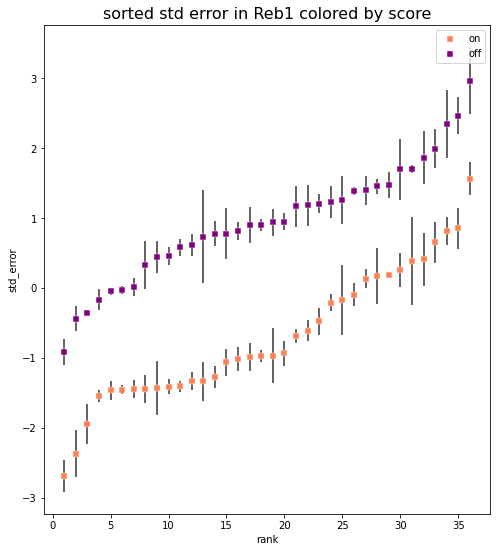

In [816]:
fig, axs = plt.subplots(1,1, figsize=(8,9) )
marker_dict = {'on':'s','off':'s'}
color_dict = {'on':'coral','off':'purple'}
strains = ['Mot3','Cbf1','Reb1']
for strain_i, strain in enumerate(strains[2:]):
    curr_ax = np.ravel(axs)[strain_i]
    for c_on_i, c_on in enumerate(['on','off']):
        curr_y =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median
        curr_x =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median.rank()
        

        curr_hue = combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').std_error
        sns.scatterplot(x= curr_x,y= curr_y, color=color_dict[c_on], marker=marker_dict[c_on], label=c_on, ax=curr_ax)
        curr_ax.errorbar(x= curr_x, y=curr_y, yerr=curr_hue, fmt='.', alpha=0.8, color='black', zorder=0)
        
        curr_ax.set_title('sorted std error in '+strain+' colored by score', fontsize=16)
        curr_ax.set_xlabel('rank')
        curr_ax.set_ylabel('std_error')


## Figure S1C - percentage of sequences passing read count threshold in Cbf1 and Reb1


/tmp/ipykernel_183852/4248989932.py:49: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
/tmp/ipykernel_183852/4248989932.py:50: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df

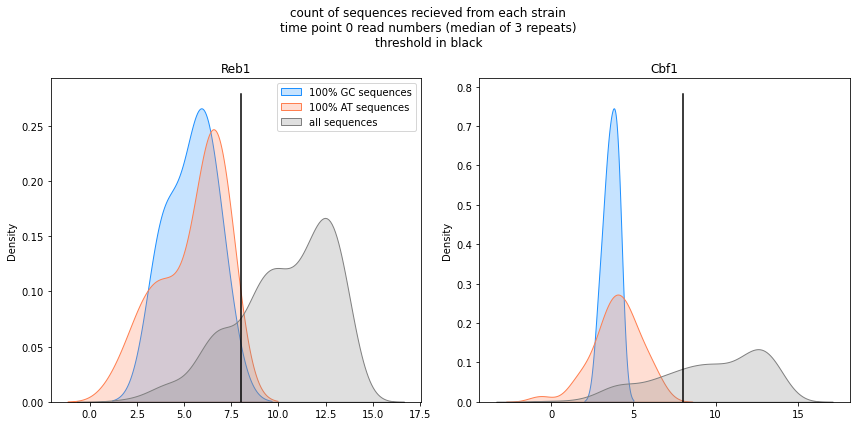

In [55]:
# load data

def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
          
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)       
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2) 
    # lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

      
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows





Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE','freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
res_dict = {}
threshold = 0
strains_list = [Msn2_strains, strains_2]
libs_list    = [Msn2_libs, libs_2]


for strain_list_i, strains in enumerate( strains_list ):
 
    for strain_i, strain in enumerate(strains):
        
        if strain == 'freeMnase':
            os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
            rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')
            exp_num = 30
        else:
            os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
            rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')
            exp_num = 29
            
        for lib_i, lib in enumerate(libs_list[strain_list_i][strain_i]):
            thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len( libs_list[strain_list_i][strain_i] )] * len(strains)] 
            thsld = thsld_list_8[strain_i][lib_i]
            
            lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')
            
            if strain+'_on' not in res_dict.keys():
                res_dict[strain] = lib_df
                res_dict[strain+'_on'] = on_rows
                res_dict[strain+'_off'] =  off_rows
            else:
                res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
                res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
                res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])


     
            
################ plot resutls ###################
fig, axs = plt.subplots(1,2, figsize=(12,6))
fig.suptitle('count of sequences recieved from each strain\ntime point 0 read numbers (median of 3 repeats)\nthreshold in black')
strains = ['Reb1', 'Cbf1']
# for strain_i, strain in enumerate(list(res_dict.keys())[::3]):
for strain_i, strain in enumerate(strains):

    curr_ax = np.ravel(axs)[strain_i]
    gc_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==100 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    at_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==0 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    all_vec = res_dict[strain].iloc[:,:3].median(axis=1).values

    sns.kdeplot( gc_vec, color='dodgerblue', fill=True, label='100% GC sequences', ax=curr_ax)
    sns.kdeplot( at_vec, color='coral', fill=True, label='100% AT sequences', ax=curr_ax)
    sns.kdeplot( all_vec, color='gray', fill=True, label='all sequences', ax=curr_ax)
    if strain_i ==0:
        curr_ax.legend()
    ymax = curr_ax.get_ylim()[1]  # Get the maximum y-value
    curr_ax.set_title(strain)
    curr_ax.plot([8,8],[0,ymax], color='black',label='threshold')
plt.tight_layout()


## Figure S1D - top bound STRs in Reb1, Cbf1 and Mot3

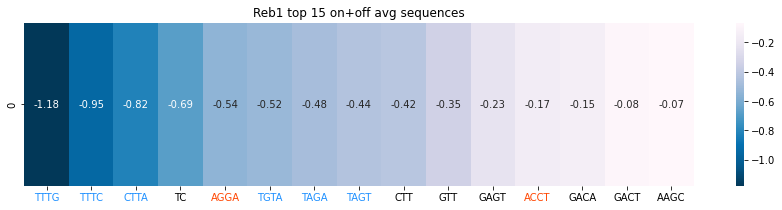

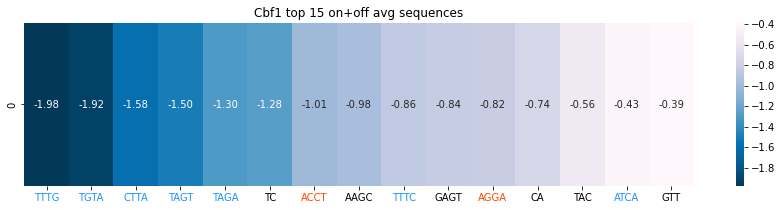

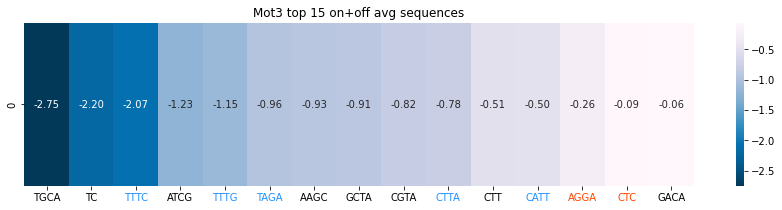

In [817]:
''' top sequences for on+off avg '''
strains = ['Reb1', 'Cbf1', 'Mot3']
for strain_i, strain in enumerate(strains):
    curr_df = combined_seq_dict[strain+'_'+'on'+'_screened'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'+'_screened'].query("index!='genome'"), how='inner', suffixes=('_on','_off'), left_index=True, right_index=True )
    curr_df = curr_df.loc[:,curr_df.columns.str.contains('delta_median')]
    curr_df['avg_delta_median'] = curr_df.mean(axis=1)
    curr_df = curr_df.sort_values(by='avg_delta_median')
    curr_df['group'] = curr_df.index.map(lambda x: assign_seq_group(x))
    curr_df['group_color'] = curr_df['group'].map(lambda x: 'orangered' if x[0] == 'AGG' else 'dodgerblue' if x[0] == 'AT_rich' else 'darkviolet' if x[0] == '3G' else 'black')
    
    plt.figure(figsize=(15,3))
    plt.title(strain+' top 15 '+'on+off avg'+' sequences')
    ax = sns.heatmap(curr_df.avg_delta_median[:15].values.reshape(1, -1), annot=True, fmt=".2f", xticklabels=curr_df.index[:15], cmap='PuBu_r')
    for tick_label, color in zip(ax.get_xticklabels(), curr_df['group_color'][:15]):
        tick_label.set_color(color)
    
    plt.show()


## Figure S1E - percentage of sequences passing read count threshold in Mot3

/tmp/ipykernel_137520/201217950.py:49: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
/tmp/ipykernel_137520/201217950.py:50: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1,

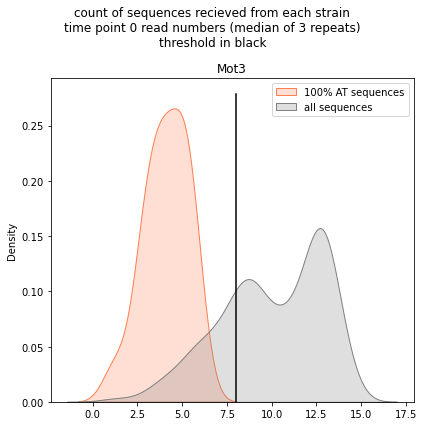

In [968]:
# load data

def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
          
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)       
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2) 
    # lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

      
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows





Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE','freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
res_dict = {}
threshold = 0
strains_list = [Msn2_strains, strains_2]
libs_list    = [Msn2_libs, libs_2]


for strain_list_i, strains in enumerate( strains_list ):
 
    for strain_i, strain in enumerate(strains):
        
        if strain == 'freeMnase':
            os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
            rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')
            exp_num = 30
        else:
            os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
            rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')
            exp_num = 29
            
        for lib_i, lib in enumerate(libs_list[strain_list_i][strain_i]):
            thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len( libs_list[strain_list_i][strain_i] )] * len(strains)] 
            thsld = thsld_list_8[strain_i][lib_i]
            
            lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')
            
            if strain+'_on' not in res_dict.keys():
                res_dict[strain] = lib_df
                res_dict[strain+'_on'] = on_rows
                res_dict[strain+'_off'] =  off_rows
            else:
                res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
                res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
                res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])


     
            
################ plot resutls ###################
fig, axs = plt.subplots(1,1, figsize=(6,6))
fig.suptitle('count of sequences recieved from each strain\ntime point 0 read numbers (median of 3 repeats)\nthreshold in black')
strains = ['Mot3']
# for strain_i, strain in enumerate(list(res_dict.keys())[::3]):
for strain_i, strain in enumerate(strains):

    curr_ax = np.ravel(axs)[strain_i]
    gc_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==100 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    at_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==0 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    all_vec = res_dict[strain].iloc[:,:3].median(axis=1).values

    sns.kdeplot( gc_vec, color='dodgerblue', fill=True, label='100% GC sequences', ax=curr_ax)
    sns.kdeplot( at_vec, color='coral', fill=True, label='100% AT sequences', ax=curr_ax)
    sns.kdeplot( all_vec, color='gray', fill=True, label='all sequences', ax=curr_ax)
    if strain_i ==0:
        curr_ax.legend()
    ymax = curr_ax.get_ylim()[1]  # Get the maximum y-value
    curr_ax.set_title(strain)
    curr_ax.plot([8,8],[0,ymax], color='black',label='threshold')
plt.tight_layout()


## Figure S1F - score vs. std error in Mot3

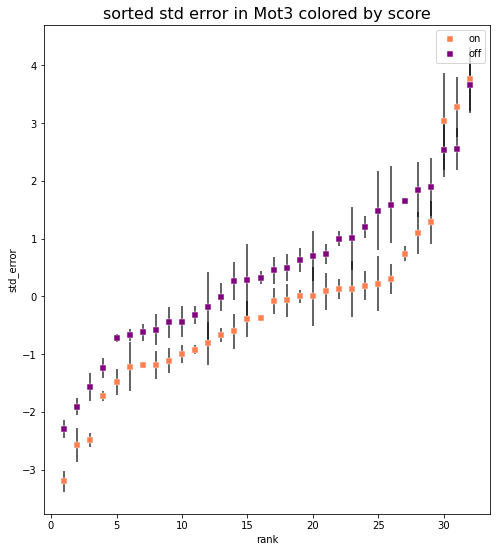

In [818]:
fig, axs = plt.subplots(1,1, figsize=(8,9) )
marker_dict = {'on':'s','off':'s'}
color_dict = {'on':'coral','off':'purple'}
strains = ['Mot3','Cbf1','Reb1']
for strain_i, strain in enumerate(strains[:1]):
    curr_ax = np.ravel(axs)[strain_i]
    for c_on_i, c_on in enumerate(['on','off']):
        curr_y =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median
        curr_x =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median.rank()
        

        curr_hue = combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').std_error
        sns.scatterplot(x= curr_x,y= curr_y, color=color_dict[c_on], marker=marker_dict[c_on], label=c_on, ax=curr_ax)
        curr_ax.errorbar(x= curr_x, y=curr_y, yerr=curr_hue, fmt='.', alpha=0.8, color='black', zorder=0)
        
        curr_ax.set_title('sorted std error in '+strain+' colored by score', fontsize=16)
        curr_ax.set_xlabel('rank')
        curr_ax.set_ylabel('std_error')


## Figure S1G - correlation between technical repeats and between activated and non activated samples in Mot3

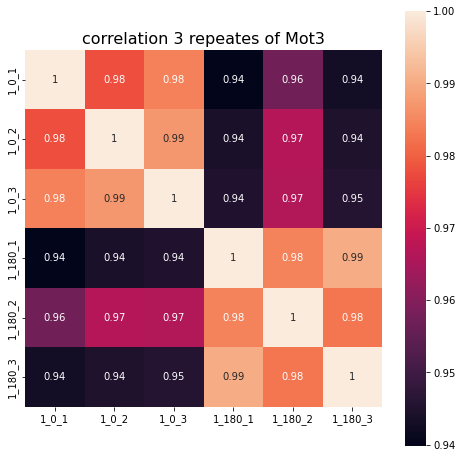

In [819]:
''' correlate 1 TF, its 3 repeates '''
strains = ['Mot3', 'Cbf1', 'Reb1', 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'freeMnase']
for strain_i, strain in enumerate(strains[:1]):
    curr_df = pd.DataFrame()
    curr_df = res_dict[strain].iloc[:,:6]
    plt.figure(figsize=(8, 8) )
    sns.heatmap(curr_df.corr(), annot=True, square=True)
    plt.title('correlation 3 repeates of ' +strain, fontsize=16)

    plt.show()

## Figure S1H - sequence distribution of mutated and intact motif sequences in Mot3

No handles with labels found to put in legend.


Mot3 0.14546629567266992


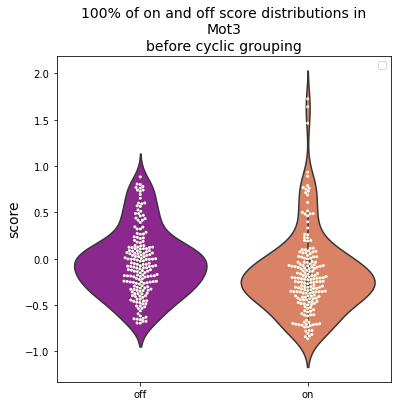

In [827]:
''' show dist before cyclic grouping '''
strains = [ 'Mot3' ]
fig, axs = plt.subplots(1,1, figsize=(6,6) )
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]

    
    ''' make a sworm plot '''
    curr_df = pd.DataFrame()
    min_percent = 2.5
    max_percent = 97.5
    mn, mx = np.percentile(res_dict[strain].query("on_state=='off'").delta_med180_med0, [min_percent, max_percent])
    curr_off = res_dict[strain].query("on_state=='off' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0        # use when showing 95 percent of results

    mn, mx = np.percentile(res_dict[strain].query("on_state=='on'").delta_med180_med0, [min_percent, max_percent])
    curr_on= res_dict[strain].query("on_state=='on' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0
    
    curr_df = pd.concat( [curr_off, curr_on ] )
    groups = ['off'] * len(curr_off) + ['on'] * len(curr_on)
    
    med_off = curr_off.median()
    med_on = curr_on.median()
    print(strain, med_off-med_on)
    
    sns.violinplot(y=curr_df, x=groups, ax=curr_ax, palette='plasma')
    sns.swarmplot(y=curr_df, x=groups, ax=curr_ax, color='ivory', s=3, zorder=3)

   

    curr_ax.legend()
    curr_ax.set_ylabel('score',fontsize=14)
    curr_ax.set_title('100% of on and off score distributions in\n'+ strain+'\nbefore cyclic grouping', fontsize=14)


# Figure S2

## Figure S2A - sequences passing read count threshold, bars, for Msn2 FL and free Mnase

/tmp/ipykernel_183852/3344180820.py:50: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
/tmp/ipykernel_183852/3344180820.py:51: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df

Text(0.5, 1.0, '% of sequences above threshold')

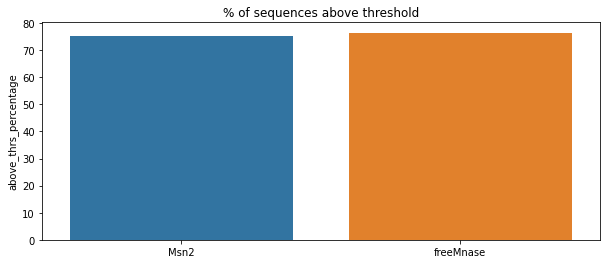

In [85]:
# load data

def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
          
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)       
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)
    if threshold!=0:
        lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

      
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows





Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE','freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
# res_dict = {}
threshold = 0
strains_list = [Msn2_strains, strains_2]
libs_list    = [Msn2_libs, libs_2]
thrs_seq_count_dict = {}

for threshold in [0,8]:
    res_dict = {}

    for strain_list_i, strains in enumerate( strains_list ):

        for strain_i, strain in enumerate(strains):

            if strain == 'freeMnase':
                os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
                rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')
                exp_num = 30
            else:
                os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
                rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')
                exp_num = 29

            for lib_i, lib in enumerate(libs_list[strain_list_i][strain_i]):
                thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len( libs_list[strain_list_i][strain_i] )] * len(strains)] 
                thsld = thsld_list_8[strain_i][lib_i]

                lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')

                if strain+'_on' not in res_dict.keys():
                    res_dict[strain] = lib_df
                    res_dict[strain+'_on'] = on_rows
                    res_dict[strain+'_off'] =  off_rows
                else:
                    res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
                    res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
                    res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])

    # count sequences in each strain for threshold 8 and threshold 0
    for strain in list(res_dict.keys())[::3]:
        thrs_seq_count_dict[strain+'_on_thrs_'+str(threshold)]  = res_dict[strain].query("on_state=='on'").shape[0]
        thrs_seq_count_dict[strain+'_off_thrs_'+str(threshold)] = res_dict[strain].query("on_state=='off'").shape[0]

read_count_df = pd.DataFrame(columns=['on_reads','off_reads','total_reads','above_thrs_reads','above_thrs_percentage'])
for strain in ['Msn2', 'freeMnase']:
    read_count_df.loc[strain, 'on_reads'] = thrs_seq_count_dict[strain+'_on_thrs_0']
    read_count_df.loc[strain, 'off_reads'] = thrs_seq_count_dict[strain+'_off_thrs_0']
    
    total_reads = thrs_seq_count_dict[strain+'_on_thrs_0'] + thrs_seq_count_dict[strain+'_off_thrs_0']
    above_thrs_reads = thrs_seq_count_dict[strain+'_on_thrs_8'] + thrs_seq_count_dict[strain+'_off_thrs_8']
    
    read_count_df.loc[strain, 'total_reads'] = total_reads
    read_count_df.loc[strain, 'above_thrs_reads'] = above_thrs_reads
    read_count_df.loc[strain, 'above_thrs_percentage'] = ( above_thrs_reads / total_reads ) * 100

plt.figure(figsize=(10,4))
sns.barplot(data=read_count_df, x=read_count_df.index, y='above_thrs_percentage')
plt.title('% of sequences above threshold')

In [92]:
read_count_df
# np.round(1280/1700*100,2)

,on_reads,off_reads,total_reads,above_thrs_reads,above_thrs_percentage
Msn2,850,850,1700,1280,75.294118
freeMnase,803,803,1606,1228,76.463263


## Figure S2B

/tmp/ipykernel_137520/1599912887.py:49: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
/tmp/ipykernel_137520/1599912887.py:50: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df

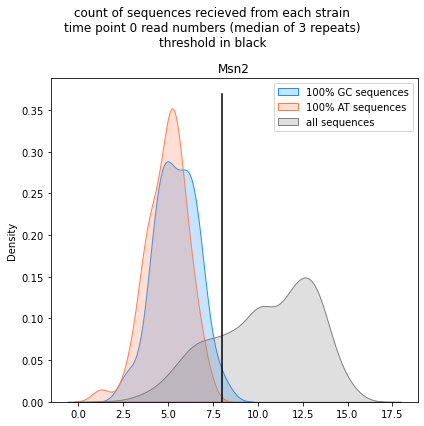

In [970]:
# load data

def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
          
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)       
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2) 
    # lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

      
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows





Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE','freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
res_dict = {}
threshold = 0
strains_list = [Msn2_strains, strains_2]
libs_list    = [Msn2_libs, libs_2]


for strain_list_i, strains in enumerate( strains_list ):
 
    for strain_i, strain in enumerate(strains):
        
        if strain == 'freeMnase':
            os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
            rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')
            exp_num = 30
        else:
            os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
            rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')
            exp_num = 29
            
        for lib_i, lib in enumerate(libs_list[strain_list_i][strain_i]):
            thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len( libs_list[strain_list_i][strain_i] )] * len(strains)] 
            thsld = thsld_list_8[strain_i][lib_i]
            
            lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')
            
            if strain+'_on' not in res_dict.keys():
                res_dict[strain] = lib_df
                res_dict[strain+'_on'] = on_rows
                res_dict[strain+'_off'] =  off_rows
            else:
                res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
                res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
                res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])


     
            
################ plot resutls ###################
fig, axs = plt.subplots(1,1, figsize=(6,6))
fig.suptitle('count of sequences recieved from each strain\ntime point 0 read numbers (median of 3 repeats)\nthreshold in black')
strains = ['Msn2']
# for strain_i, strain in enumerate(list(res_dict.keys())[::3]):
for strain_i, strain in enumerate(strains):

    curr_ax = np.ravel(axs)[strain_i]
    gc_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==100 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    at_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==0 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    all_vec = res_dict[strain].iloc[:,:3].median(axis=1).values

    sns.kdeplot( gc_vec, color='dodgerblue', fill=True, label='100% GC sequences', ax=curr_ax)
    sns.kdeplot( at_vec, color='coral', fill=True, label='100% AT sequences', ax=curr_ax)
    sns.kdeplot( all_vec, color='gray', fill=True, label='all sequences', ax=curr_ax)
    if strain_i ==0:
        curr_ax.legend()
    ymax = curr_ax.get_ylim()[1]  # Get the maximum y-value
    curr_ax.set_title(strain)
    curr_ax.plot([8,8],[0,ymax], color='black',label='threshold')
plt.tight_layout()


## Figure S2C - correlation between technical repeats and between activated and non activated samples in free Mnase

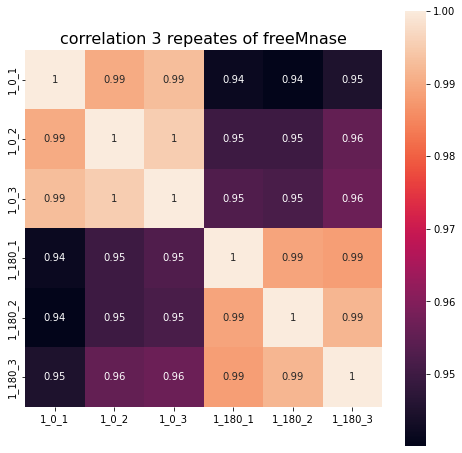

In [829]:
''' correlate 1 TF, its 3 repeates '''
strains = ['Mot3', 'Cbf1', 'Reb1', 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE', 'freeMnase']
for strain_i, strain in enumerate(strains[6:]):
    curr_df = pd.DataFrame()
    curr_df = res_dict[strain].iloc[:,:6]
    plt.figure(figsize=(8, 8) )
    sns.heatmap(curr_df.corr(), annot=True, square=True)
    plt.title('correlation 3 repeates of ' +strain, fontsize=16)

    plt.show()

## Figure S2D - score vs. std error in free Mnase

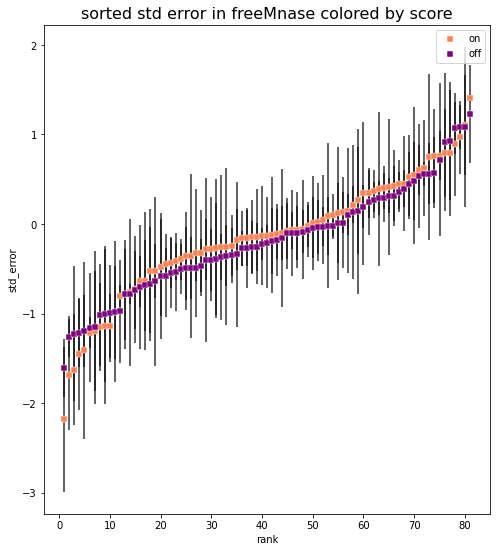

In [831]:
fig, axs = plt.subplots(1,1, figsize=(8,9) )
marker_dict = {'on':'s','off':'s'}
color_dict = {'on':'coral','off':'purple'}
strains = ['freeMnase']
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]
    for c_on_i, c_on in enumerate(['on','off']):
        curr_y =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median
        curr_x =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median.rank()
        

        curr_hue = combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').std_error
        sns.scatterplot(x= curr_x,y= curr_y, color=color_dict[c_on], marker=marker_dict[c_on], label=c_on, ax=curr_ax)
        curr_ax.errorbar(x= curr_x, y=curr_y, yerr=curr_hue, fmt='.', alpha=0.8, color='black', zorder=0)
        
        curr_ax.set_title('sorted std error in '+strain+' colored by score', fontsize=16)
        curr_ax.set_xlabel('rank')
        curr_ax.set_ylabel('std_error')


## Figure S2E - sequence distribution of mutated and intact motif sequences in Mot3

Msn2 0.42485242982489674


No handles with labels found to put in legend.


freeMnase -0.005626982581931728


No handles with labels found to put in legend.


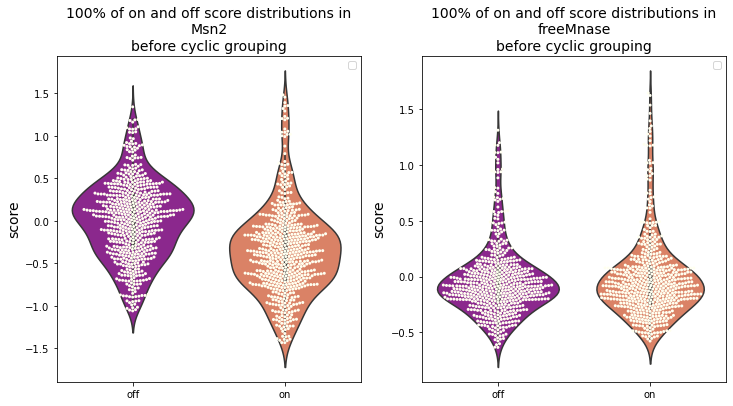

In [832]:
''' show dist before cyclic grouping '''
strains = [ 'Msn2', 'freeMnase' ]
fig, axs = plt.subplots(1,2, figsize=(12,6) )
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]

    
    ''' make a sworm plot '''
    curr_df = pd.DataFrame()
    min_percent = 2.5
    max_percent = 97.5
    mn, mx = np.percentile(res_dict[strain].query("on_state=='off'").delta_med180_med0, [min_percent, max_percent])
    curr_off = res_dict[strain].query("on_state=='off' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0        # use when showing 95 percent of results

    mn, mx = np.percentile(res_dict[strain].query("on_state=='on'").delta_med180_med0, [min_percent, max_percent])
    curr_on= res_dict[strain].query("on_state=='on' & delta_med180_med0 > @mn & delta_med180_med0 < @mx ").delta_med180_med0
    
    curr_df = pd.concat( [curr_off, curr_on ] )
    groups = ['off'] * len(curr_off) + ['on'] * len(curr_on)
    
    med_off = curr_off.median()
    med_on = curr_on.median()
    print(strain, med_off-med_on)
    
    sns.violinplot(y=curr_df, x=groups, ax=curr_ax, palette='plasma')
    sns.swarmplot(y=curr_df, x=groups, ax=curr_ax, color='ivory', s=3, zorder=3)

   

    curr_ax.legend()
    curr_ax.set_ylabel('score',fontsize=14)
    curr_ax.set_title('100% of on and off score distributions in\n'+ strain+'\nbefore cyclic grouping', fontsize=14)


# Figure S3

## Figure S3A - sequences passing read count threshold, bars, for Msn2 DBD OE and Msn2 non-DBD OE

/tmp/ipykernel_137520/1310659195.py:50: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
/tmp/ipykernel_137520/1310659195.py:51: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df

Text(0.5, 1.0, '% of sequences above threshold')

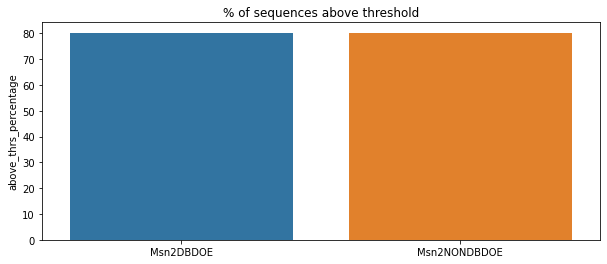

In [972]:
# load data

def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
          
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)       
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2)
    if threshold!=0:
        lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

      
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows





Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE','freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
# res_dict = {}
threshold = 0
strains_list = [Msn2_strains, strains_2]
libs_list    = [Msn2_libs, libs_2]
thrs_seq_count_dict = {}

for threshold in [0,8]:
    res_dict = {}

    for strain_list_i, strains in enumerate( strains_list ):

        for strain_i, strain in enumerate(strains):

            if strain == 'freeMnase':
                os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
                rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')
                exp_num = 30
            else:
                os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
                rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')
                exp_num = 29

            for lib_i, lib in enumerate(libs_list[strain_list_i][strain_i]):
                thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len( libs_list[strain_list_i][strain_i] )] * len(strains)] 
                thsld = thsld_list_8[strain_i][lib_i]

                lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')

                if strain+'_on' not in res_dict.keys():
                    res_dict[strain] = lib_df
                    res_dict[strain+'_on'] = on_rows
                    res_dict[strain+'_off'] =  off_rows
                else:
                    res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
                    res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
                    res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])

    # count sequences in each strain for threshold 8 and threshold 0
    for strain in list(res_dict.keys())[::3]:
        thrs_seq_count_dict[strain+'_on_thrs_'+str(threshold)]  = res_dict[strain].query("on_state=='on'").shape[0]
        thrs_seq_count_dict[strain+'_off_thrs_'+str(threshold)] = res_dict[strain].query("on_state=='off'").shape[0]

read_count_df = pd.DataFrame(columns=['on_reads','off_reads','total_reads','above_thrs_reads','above_thrs_percentage'])
for strain in ['Msn2DBDOE', 'Msn2NONDBDOE']:
    read_count_df.loc[strain, 'on_reads'] = thrs_seq_count_dict[strain+'_on_thrs_0']
    read_count_df.loc[strain, 'off_reads'] = thrs_seq_count_dict[strain+'_off_thrs_0']
    
    total_reads = thrs_seq_count_dict[strain+'_on_thrs_0'] + thrs_seq_count_dict[strain+'_off_thrs_0']
    above_thrs_reads = thrs_seq_count_dict[strain+'_on_thrs_8'] + thrs_seq_count_dict[strain+'_off_thrs_8']
    
    read_count_df.loc[strain, 'total_reads'] = total_reads
    read_count_df.loc[strain, 'above_thrs_reads'] = above_thrs_reads
    read_count_df.loc[strain, 'above_thrs_percentage'] = ( above_thrs_reads / total_reads ) * 100

plt.figure(figsize=(10,4))
sns.barplot(data=read_count_df, x=read_count_df.index, y='above_thrs_percentage')
plt.title('% of sequences above threshold')

## Figure S3B

/tmp/ipykernel_137520/1181230039.py:49: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
/tmp/ipykernel_137520/1181230039.py:50: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df

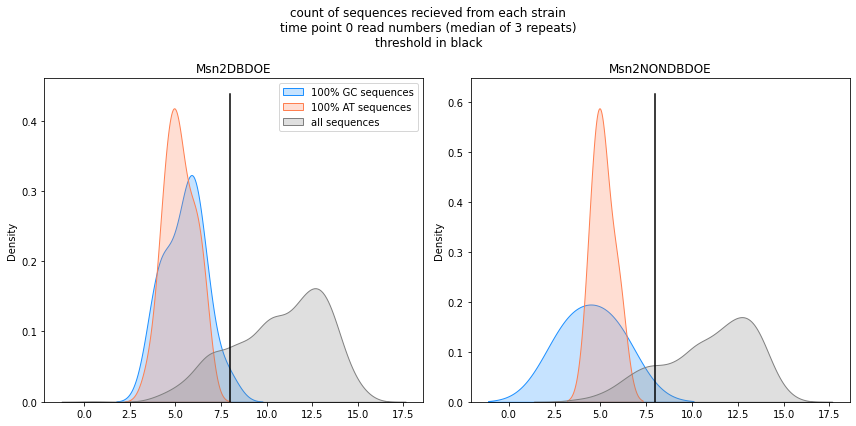

In [971]:
# load data

def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
          
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)       
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2) 
    # lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()

      
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows





Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE','freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]


norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
res_dict = {}
threshold = 0
strains_list = [Msn2_strains, strains_2]
libs_list    = [Msn2_libs, libs_2]


for strain_list_i, strains in enumerate( strains_list ):
 
    for strain_i, strain in enumerate(strains):
        
        if strain == 'freeMnase':
            os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
            rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')
            exp_num = 30
        else:
            os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
            rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')
            exp_num = 29
            
        for lib_i, lib in enumerate(libs_list[strain_list_i][strain_i]):
            thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len( libs_list[strain_list_i][strain_i] )] * len(strains)] 
            thsld = thsld_list_8[strain_i][lib_i]
            
            lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')
            
            if strain+'_on' not in res_dict.keys():
                res_dict[strain] = lib_df
                res_dict[strain+'_on'] = on_rows
                res_dict[strain+'_off'] =  off_rows
            else:
                res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
                res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
                res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])


     
            
################ plot resutls ###################
fig, axs = plt.subplots(1,2, figsize=(12,6))
fig.suptitle('count of sequences recieved from each strain\ntime point 0 read numbers (median of 3 repeats)\nthreshold in black')
strains = ['Msn2DBDOE','Msn2NONDBDOE']
# for strain_i, strain in enumerate(list(res_dict.keys())[::3]):
for strain_i, strain in enumerate(strains):

    curr_ax = np.ravel(axs)[strain_i]
    gc_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==100 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    at_vec = res_dict[strain][ res_dict[strain]['nuc_comb'].apply(calculate_gc_content)==0 ].query("nuc_comb!='genome'").iloc[:,:3].median(axis=1).values
    all_vec = res_dict[strain].iloc[:,:3].median(axis=1).values

    sns.kdeplot( gc_vec, color='dodgerblue', fill=True, label='100% GC sequences', ax=curr_ax)
    sns.kdeplot( at_vec, color='coral', fill=True, label='100% AT sequences', ax=curr_ax)
    sns.kdeplot( all_vec, color='gray', fill=True, label='all sequences', ax=curr_ax)
    if strain_i ==0:
        curr_ax.legend()
    ymax = curr_ax.get_ylim()[1]  # Get the maximum y-value
    curr_ax.set_title(strain)
    curr_ax.plot([8,8],[0,ymax], color='black',label='threshold')
plt.tight_layout()


## Figure S3C - correlation between technical repeats and between activated and non activated samples in Msn2 DBD OE and Msn2 non-DBD OE

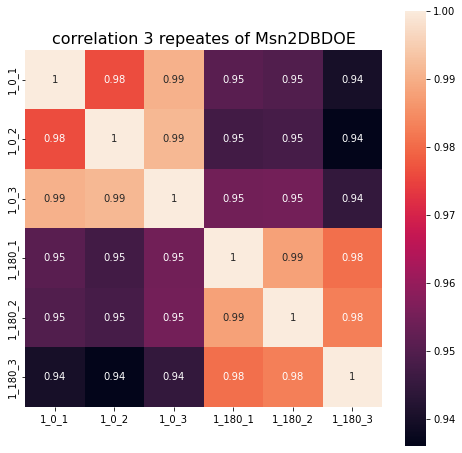

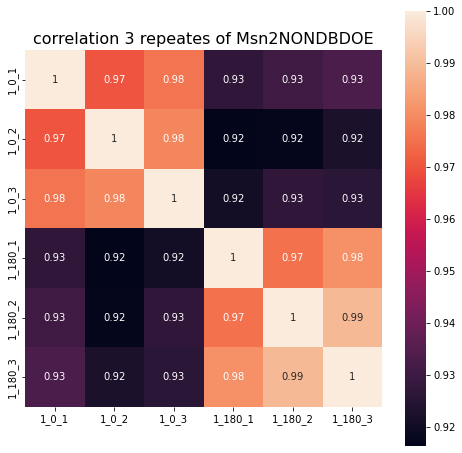

In [833]:
''' correlate 1 TF, its 3 repeates '''
strains = [ 'Msn2DBDOE', 'Msn2NONDBDOE']
for strain_i, strain in enumerate(strains):
    curr_df = pd.DataFrame()
    curr_df = res_dict[strain].iloc[:,:6]
    plt.figure(figsize=(8, 8) )
    sns.heatmap(curr_df.corr(), annot=True, square=True)
    plt.title('correlation 3 repeates of ' +strain, fontsize=16)

    plt.show()

## Figure S3D - score vs. std error in Msn2 DBD OE and Msn2 non-DBD OE

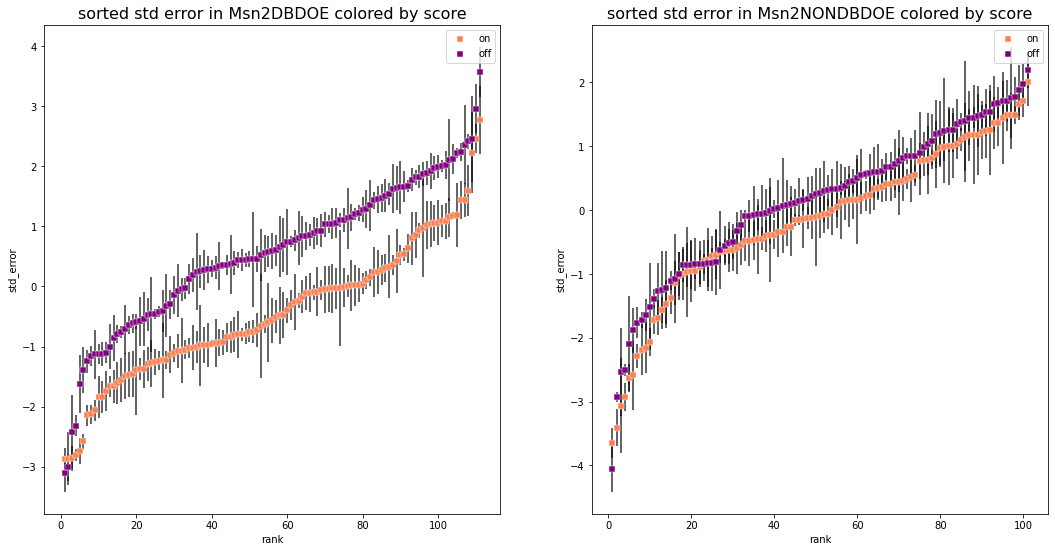

In [835]:
fig, axs = plt.subplots(1,2, figsize=(18,9) )
marker_dict = {'on':'s','off':'s'}
color_dict = {'on':'coral','off':'purple'}
strains = ['Msn2DBDOE','Msn2NONDBDOE']
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]
    for c_on_i, c_on in enumerate(['on','off']):
        curr_y =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median
        curr_x =   combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').delta_median.rank()
        

        curr_hue = combined_seq_dict[strain+'_'+c_on+'_screened'].sort_values(by='delta_median').std_error
        sns.scatterplot(x= curr_x,y= curr_y, color=color_dict[c_on], marker=marker_dict[c_on], label=c_on, ax=curr_ax)
        curr_ax.errorbar(x= curr_x, y=curr_y, yerr=curr_hue, fmt='.', alpha=0.8, color='black', zorder=0)
        
        curr_ax.set_title('sorted std error in '+strain+' colored by score', fontsize=16)
        curr_ax.set_xlabel('rank')
        curr_ax.set_ylabel('std_error')


## Figure S3E - scatter of Msn2 DBD OE and Msn2 non-DBD OE vs. free Mnase

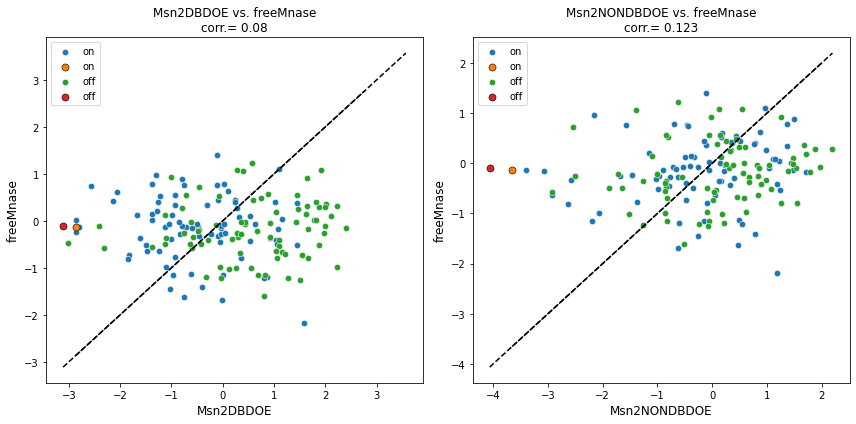

In [838]:
''' plot TF 1 vs. TF 2, omit dots with a signle sequence '''

strains = ['Msn2DBDOE','Msn2NONDBDOE', 'freeMnase']
fig, axs = plt.subplots(1, 2, figsize=(12,6) )


strain_combo_list = [(0,2),(1,2)]
for fig_i, strain_combo in enumerate(strain_combo_list):
    strain1 = strain_combo[0]
    strain2 = strain_combo[1]
    curr_ax = np.ravel(axs)[fig_i]
    for c_on in ['on','off']:
        curr_df = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened']
        samp_on = combined_seq_dict[strains[strain1]+'_'+c_on+'_screened'].delta_median
        samp_off = combined_seq_dict[strains[strain2]+'_'+c_on+'_screened'].delta_median

        genome_df = pd.DataFrame()
        genome_df.loc['genome','on'] = samp_on.genome
        genome_df.loc['genome','off'] = samp_off.genome

        # plot a scatter Tf 1 vs. TF 2

        curr_corr = np.round(pd.concat([samp_on,samp_off],axis=1).corr().iloc[0,1],3)
        sns.scatterplot(x=samp_on, y=samp_off, s=40,  ax=curr_ax, label=c_on, legend=False)
        sns.scatterplot(x=genome_df['on'], y=genome_df['off'], edgecolor='black', s=50, ax=curr_ax, label=c_on, zorder=1, legend=False)


        min_val = min(np.nanmin(samp_on), np.nanmin(samp_off))
        max_val = max(np.nanmax(samp_on), np.nanmax(samp_off))

        curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
        curr_ax.set_title(strains[strain1]+' vs. '+strains[strain2]+'\ncorr.= '+str(curr_corr), fontsize=12 )
        curr_ax.set_xlabel(strains[strain1],fontsize=12)
        curr_ax.set_ylabel(strains[strain2],fontsize=12)
        curr_ax.legend()
        plt.tight_layout()
        

plot correaltion of all samples, on and off individually

In [ ]:
''' plot all samples together '''

''' plot on and off on the same plot '''
    
for c_on in ['_on', '_off']:
    # df1 = combined_seq_dict['Msn2'+c_on+'_screened'].query("index!='genome'").rename_axis('nuc_comb')
    # df2 = combined_seq_dict['Msn2DBDOE'+c_on+'_screened'].rename_axis('nuc_comb')
    # df3 = combined_seq_dict['Msn2NONDBDOE'+c_on+'_screened'].rename_axis('nuc_comb')
    # df4 = combined_seq_dict['Med15'+c_on+'_screened'].rename_axis('nuc_comb')

    df5 = combined_seq_dict['Mot3'+c_on+'_screened'].rename_axis('nuc_comb')
    # df4 = combined_seq_dict['freeMnase'+c_on+'_screened'].query("index!='genome'").rename_axis('nuc_comb')
    df6 = combined_seq_dict['Cbf1'+c_on+'_screened'].query("index!='genome'").rename_axis('nuc_comb')
    df7 = combined_seq_dict['Reb1'+c_on+'_screened'].query("index!='genome'").rename_axis('nuc_comb')
    df8 = combined_seq_dict['Reb1'+c_on+'_screened'].query("index!='genome'").rename_axis('nuc_comb')
    

    # df_12 = df1.merge(df2, suffixes=('_Msn2'+c_on,'_Msn2DBDOE'+c_on), on=['nuc_comb','on_state'])
    # df_34 = df3.merge(df4, suffixes=('_Msn2NONDBDOE'+c_on,'_Med15'+c_on), on=['nuc_comb', 'on_state'])
    # df_56 = df5.merge(df6, suffixes=('_Mot3','_Cbf1'), on=['nuc_comb','on_state'])
    # df_78 = df7.merge(df8, suffixes=('_Reb1','_freeMnase'), on=['nuc_comb','on_state'])
    # df_12 = df1.merge(df2, suffixes=('_Msn2','_Msn2DBDOE'), on=['nuc_comb','on_state'])
    # df_34 = df3.merge(df4, suffixes=('_Msn2NONDBDOE','_freeMnase'), on=['nuc_comb','on_state'])
    df_56 = df5.merge(df6, suffixes=('_Mot3','_Cbf1'), on=['nuc_comb','on_state'])
    df_78 = df7.merge(df8, suffixes=('_Reb1','_Reb2'), on=['nuc_comb','on_state'])
    reb1_cols = [col for col in df_78.columns if not col.endswith('_Reb2')]
    if c_on == '_on':
        df_on =   df_56.merge(df_78.loc[:,reb1_cols], suffixes=(c_on, c_on), on=['nuc_comb', 'on_state'])
        # df_on =   df_on.merge(df_56, suffixes=(c_on, c_on), on=['nuc_comb', 'on_state'])
        # df_on =   df_12
    #     df_on =   df_on.merge(df_56, suffixes=(c_on, c_on), on=['nuc_comb', 'on_state'])
    #     df_on =   df_on.merge(df_78, suffixes=(c_on, c_on), on=['nuc_comb', 'on_state'])
    if c_on == '_off':
        df_off =  df_56.merge(df_78.loc[:,reb1_cols], suffixes=(c_on, c_on), on=['nuc_comb', 'on_state'])
        # df_off =   df_off.merge(df_56, suffixes=(c_on, c_on), on=['nuc_comb', 'on_state'])
        # df_off =   df_12
    #     df_off =  df_off.merge(df_56, suffixes=(c_on, c_on), on=['nuc_comb', 'on_state'])
    #     df_off =  df_off.merge(df_78, suffixes=(c_on, c_on), on=['nuc_comb', 'on_state'])

#  on and off    
df_merged = df_on.merge(df_off, suffixes=('_on', '_off'), on=['nuc_comb'])
#  on or off
# df_merged = df_off
plt.figure(figsize=(12,12))
sns.heatmap(df_merged.loc[:,df_merged.columns.str.contains('delta_median')].corr(),annot=True,square=True, annot_kws={'size': 12})
# sns.heatmap(df_on.loc[:,df_on.columns.str.contains('delta_median')].corr(),annot=True,square=True, annot_kws={'size': 12})
plt.title('correlations\ngrouped sequences\non and off results were normalized separately\n\n', fontsize=16)
plt.show()
# plt.figure(figsize=(12,12))
# sns.heatmap(df_off.loc[:,df_off.columns.str.contains('delta_median')].corr(),annot=True,square=True, annot_kws={'size': 12})
# plt.show()

plt.tight_layout()

plt.savefig('/home/labs/barkailab/matanv/CCCA/data_context_step_3/plots/figures/figure_1/ON_and_OFF_correlation.pdf')

show a scatter of the correlations above

In [ ]:
''' use grouped sequecnes and z-scores '''
# fig, axs = plt.subplots(2,3, figsize=(30,24))
# strains = ['Msn2', 'Cbf1', 'Reb1', 'freeMnase']
# for i, strain in enumerate(strains[1:]):
#     for c_on_i, c_on in enumerate(['on','off']):
#         curr_ax = np.ravel(axs)[i+c_on_i*3]
#         curr_x = df_merged.loc[:,df_merged.columns.str.contains('delta_median_'+'Msn2'+'_'+c_on)]
#         curr_y = df_merged.loc[:,df_merged.columns.str.contains('delta_median_'+strain+'_'+c_on)]
#         curr_df = curr_x.merge(curr_y, suffixes=('_Msn2','_'+strain), on=['nuc_comb'])

#         sns.scatterplot(data=curr_df,x='delta_median_Msn2_'+c_on,y='delta_median_'+strain+'_'+c_on, ax=curr_ax)
#         min_val = min(np.nanmin(curr_x), np.nanmin(curr_y))
#         max_val = max(np.nanmax(curr_x), np.nanmax(curr_y))
#         curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
#         curr_ax.set_title('Msn2 vs. '+strain+'\n'+c_on+' motif',fontsize=12)
#         curr_ax.set_xlabel('Msn2',fontsize=14)
#         curr_ax.set_ylabel(strain,fontsize=14)
        
#         x_text_on = curr_x
#         y_text_on = curr_y
#         for seq_i, seq in enumerate(curr_df.index):
#             x_text_cor = x_text_on.loc[seq]
#             y_text_cor = y_text_on.loc[seq]
#             curr_ax.annotate(seq,  # Text to display on the dot
#                          xy=(x_text_cor, y_text_cor),  # Coordinates of the dot
#                          textcoords="data",  # Text position relative to the dot
#                          xytext=(x_text_cor+0.01, y_text_cor),  # Offset (in points) from the dot for placing the text
#                          ha='left',  # Horizontal alignment of the text
#                          color='black' ,
#                          arrowprops=dict(arrowstyle='-|>', lw=0.2, color='blue',alpha=0.2), fontsize=18)
            
            
# plt.tight_layout()

''' use all sequencs before grouping and fold change valeus, not z-scores '''
fig, axs = plt.subplots(2,3, figsize=(30,24))
strains = ['Reb1', 'Msn2', 'Msn2DBDOE', 'Msn2NONDBDOE']
for i, strain in enumerate(strains[1:]):
    for c_on_i, c_on in enumerate(['on','off']):
        curr_ax = np.ravel(axs)[i+c_on_i*3]
        curr_x = res_dict['Reb1'+'_'+c_on].drop('nuc_comb',axis=1).query("delta_med180_med0<1 & nuc_comb!='genome'")
        curr_y = res_dict[strain+'_'+c_on].drop('nuc_comb',axis=1).query("delta_med180_med0<1 & nuc_comb!='genome'")
        curr_df = curr_x.merge(curr_y, suffixes=('_Reb1','_'+strain), on=['nuc_comb'])
  
        sns.scatterplot(data=curr_df,x='delta_med180_med0'+'_Reb1',y='delta_med180_med0'+'_'+strain, ax=curr_ax)
        curr_ax.set_title('Reb1 vs. '+strain+'\n'+c_on+' motif, corr.= '+str(np.round(curr_df.loc[:,curr_df.columns.str.contains('delta_med180_med0')].corr().iloc[0,1],3)))
        
        min_val = min(np.nanmin(curr_df.loc[:,'delta_med180_med0'+'_Reb1']), np.nanmin(curr_df.loc[:,'delta_med180_med0'+'_'+strain]))
        max_val = max(np.nanmax(curr_df.loc[:,'delta_med180_med0'+'_Reb1']), np.nanmax(curr_df.loc[:,'delta_med180_med0'+'_'+strain]))
        curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')
        # curr_ax.plot([min_val, max_val], [0, 0], linestyle='--', color='gray')
        # curr_ax.plot([0, 0], [min_val, max_val], linestyle='--', color='gray')

plot correaltion of all samples, combine on and off

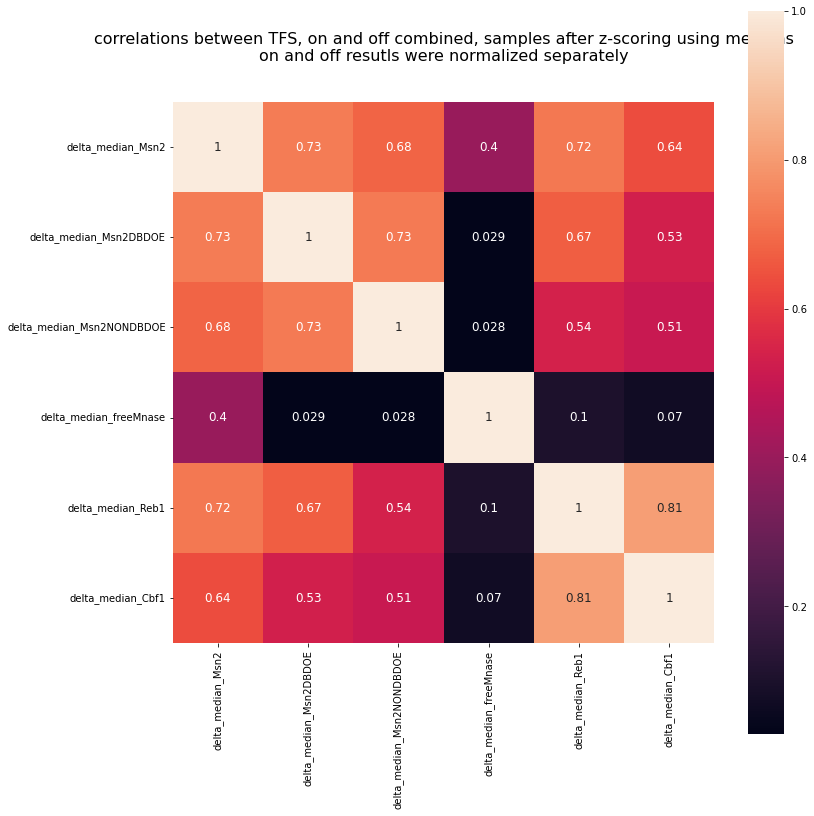

In [ ]:
''' plot all samples together '''

''' plot on and off on the same plot '''
corr_dict = {}
strains = ['Msn2','Msn2DBDOE','Msn2NONDBDOE','Reb1','Cbf1','freeMnase']
for strain in strains:
    for c_on in ['on','off']:
        corr_dict[strain+'_'+c_on] = combined_seq_dict[strain+'_'+c_on+'_screened'].rename_axis('nuc_comb')
        corr_dict[strain+'_'+c_on].index = corr_dict[strain+'_'+c_on].index.map(lambda x: x + '_'+c_on)
for strain in strains:
    corr_dict[strain] = pd.concat([corr_dict[strain+'_on'], corr_dict[strain+'_off']])
        

df_12 =     corr_dict['Msn2'].merge(corr_dict['Msn2DBDOE'], suffixes=('_Msn2','_Msn2DBDOE'), on=['nuc_comb','on_state'])
df_34 =     corr_dict['Msn2NONDBDOE'].merge(corr_dict['freeMnase'], suffixes=('_Msn2NONDBDOE','_freeMnase'), on=['nuc_comb','on_state'])
df_56 =     corr_dict['Reb1'].merge(corr_dict['Cbf1'], suffixes=('_Reb1','_Cbf1'), on=['nuc_comb','on_state'])

# if c_on == '_on':
#     df_on =   df_12.merge(df_34, suffixes=(c_on, c_on), on=['nuc_comb', 'on_state'])
#     # df_on =   df_12
# #     df_on =   df_on.merge(df_56, suffixes=(c_on, c_on), on=['nuc_comb', 'on_state'])
# #     df_on =   df_on.merge(df_78, suffixes=(c_on, c_on), on=['nuc_comb', 'on_state'])
# if c_on == '_off':
#     df_off =  df_12.merge(df_34, suffixes=(c_on, c_on), on=['nuc_comb', 'on_state'])
#     # df_off =   df_12
# #     df_off =  df_off.merge(df_56, suffixes=(c_on, c_on), on=['nuc_comb', 'on_state'])
# #     df_off =  df_off.merge(df_78, suffixes=(c_on, c_on), on=['nuc_comb', 'on_state'])

  
df_merged = df_12.merge(df_34, on=['nuc_comb'])
df_merged = df_merged.merge(df_56, on=['nuc_comb'])

plt.figure(figsize=(12,12))
sns.heatmap(df_merged.loc[:,df_merged.columns.str.contains('delta_median')].corr(),annot=True,square=True, annot_kws={'size': 12})
plt.title('correlations between TFS, on and off combined, samples after z-scoring using medians\non and off resutls were normalized separately\n\n', fontsize=16)
plt.tight_layout()

plt.savefig('/home/labs/barkailab/matanv/CCCA/data_context_step_3/plots/figures/figure_2/msn2_ON_and_OFF_correlation_with_3_TF_grouped_seq2.pdf')

draw bar graphs for all TFs to show contet and motif effect

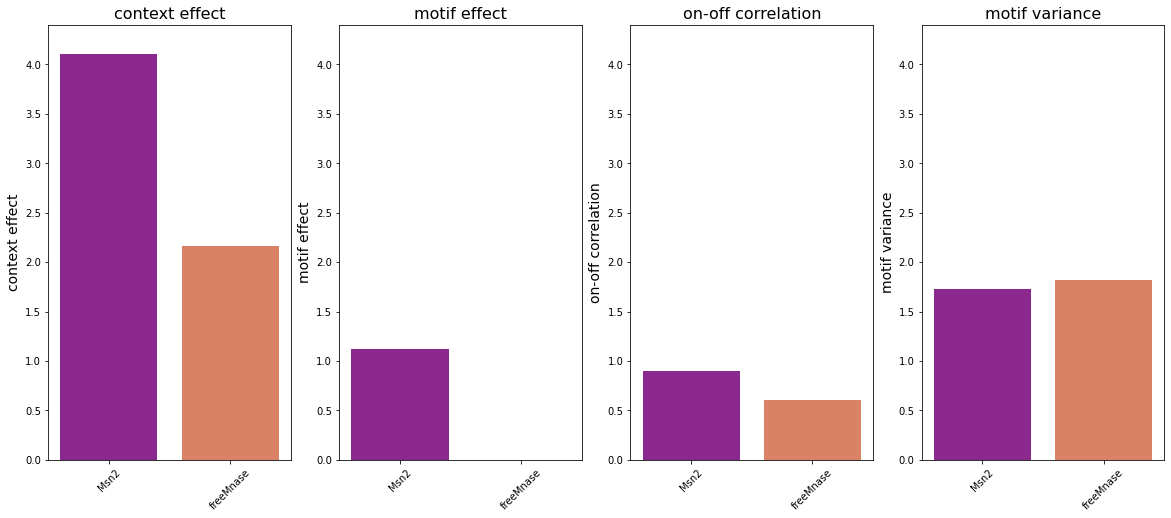

In [ ]:
strains =  ['Msn2', 'freeMnase', 'Cbf1', 'Reb1']
dist_df = pd.DataFrame(columns=['on_spread','off_spread', 'mean_spread','on_d_off_spread','bias'])
for strain in strains[:2]:
    vec_on = combined_seq_dict[strain+'_on'+'_screened'].delta_median
    vec_off = combined_seq_dict[strain+'_off'+'_screened'].delta_median
    dist_df.loc[strain,'on_spread'] =  np.percentile(vec_on,95) - np.percentile(vec_on,5)
    dist_df.loc[strain,'off_spread'] =  np.percentile(vec_off,95) - np.percentile(vec_off,5)
    dist_df.loc[strain,'mean_spread'] =  np.mean([dist_df.loc[strain,'on_spread'], dist_df.loc[strain,'off_spread']])
    dist_df.loc[strain,'on_d_off_spread'] =  np.percentile((vec_on - vec_off),95) - np.percentile((vec_on - vec_off),5)
    dist_df.loc[strain,'bias'] =  (vec_off - vec_on).median(axis=0)
    dist_df.loc[strain,'on_off_corr'] =  pd.concat([vec_on,vec_off],axis=1).corr().iloc[0,1]

fig, axs = plt.subplots(1,4,figsize=(20,8))
titles = ['context effect', 'motif effect', 'on-off correlation', 'motif variance']
# for col_i, curr_col in enumerate(dist_df.columns):
for col_i, curr_col in enumerate(['mean_spread', 'bias', 'on_off_corr', 'on_d_off_spread']):
    curr_ax = np.ravel(axs)[col_i]
    sns.barplot(x=dist_df.index, y=dist_df.loc[:,curr_col], ax=curr_ax, palette='plasma')
    curr_ax.set_title(titles[col_i], fontsize=16)
    curr_ax.tick_params(axis='x', rotation=45)
    curr_ax.set_ylabel(titles[col_i], fontsize=14)

    curr_ax.set_ylim(0, 4.4) 
plt.savefig('/home/labs/barkailab/matanv/CCCA/data_context_step_3/plots/figures/figure_2/msn2_and_freemnase_contex_effect_and_motif_effect_bars.pdf')

compute parameters of results distribution: spread, median and percentiles

In [ ]:
dist_df = pd.DataFrame(columns=['on_spread','off_spread', 'mean_spread','on_d_off_spread','bias'])
for strain in strains:
    vec_on = combined_seq_dict[strain+'_on'+'_screened'].delta_median
    vec_off = combined_seq_dict[strain+'_off'+'_screened'].delta_median
    dist_df.loc[strain,'on_spread'] =  np.percentile(vec_on,95) - np.percentile(vec_on,5)
    dist_df.loc[strain,'off_spread'] =  np.percentile(vec_off,95) - np.percentile(vec_off,5)
    dist_df.loc[strain,'mean_spread'] =  np.mean([dist_df.loc[strain,'on_spread'], dist_df.loc[strain,'off_spread']])
    dist_df.loc[strain,'on_d_off_spread'] =  np.percentile((vec_on - vec_off),95) - np.percentile((vec_on - vec_off),5)
    dist_df.loc[strain,'bias'] =  (vec_off - vec_on).median(axis=0)
    dist_df.loc[strain,'on_off_corr'] =  pd.concat([vec_on,vec_off],axis=1).corr().iloc[0,1]

fig, axs = plt.subplots(1,4,figsize=(20,8))
titles = ['context effect', 'motif effect', 'on-off correlation', 'motif variance']
# for col_i, curr_col in enumerate(dist_df.columns):
for col_i, curr_col in enumerate(['mean_spread', 'bias', 'on_off_corr', 'on_d_off_spread']):
    curr_ax = np.ravel(axs)[col_i]
    sns.barplot(x=dist_df.index, y=dist_df.loc[:,curr_col], ax=curr_ax, palette='plasma')
    curr_ax.set_title(titles[col_i], fontsize=16)
    curr_ax.tick_params(axis='x', rotation=45)
    curr_ax.set_ylabel(titles[col_i], fontsize=14)

    curr_ax.set_ylim(0, 4.4) 
fig.savefig('/home/labs/barkailab/matanv/CCCA/data_context_step_3/plots/figures/figure_1/reb1_cbf1_score_vs_error_examlpe_fig.pdf')

plot bar graphs of spread meteres

In [ ]:
dist_df = pd.DataFrame(columns=['on_spread','off_spread', 'mean_spread','on_d_off_spread','bias','on_off_corr'])
for strain in strains:
    vec_on = combined_seq_dict[strain+'_on'+'_screened'].delta_median
    vec_off = combined_seq_dict[strain+'_off'+'_screened'].delta_median
    dist_df.loc[strain,'on_spread'] =  np.percentile(vec_on,95) - np.percentile(vec_on,5)
    dist_df.loc[strain,'off_spread'] =  np.percentile(vec_off,95) - np.percentile(vec_off,5)
    dist_df.loc[strain,'mean_spread'] =  np.mean([dist_df.loc[strain,'on_spread'], dist_df.loc[strain,'off_spread']])
    dist_df.loc[strain,'on_d_off_spread'] =  np.percentile((vec_on - vec_off),95) - np.percentile((vec_on - vec_off),5)
    dist_df.loc[strain,'bias'] =  (vec_on - vec_off).median(axis=0)
    dist_df.loc[strain,'on_off_corr'] =  pd.concat([vec_on,vec_off],axis=1).corr().iloc[0,1]

fig, axs = plt.subplots(1,6,figsize=(36,5))
for col_i, curr_col in enumerate(dist_df.columns):
    curr_ax = np.ravel(axs)[col_i]
    sns.barplot(x=dist_df.index, y=dist_df.loc[:,curr_col], ax=curr_ax, palette='plasma')
    curr_ax.set_title(curr_col)
    curr_ax.tick_params(axis='x', rotation=60)
    if col_i<4:
        curr_ax.set_ylim(0, 5.5) 

scatter %GC vs. score and make a bar plot showing the correlation(%GC, score) for all TFs

-barplot is in a seperate cell

In [ ]:
''' plot %GC vs. score for each sequences '''
''' get correltion values for each TF on, off and on-off'''

strains = ['Mot3', 'Cbf1', 'Reb1', 'freeMnase']
gc_df = pd.DataFrame()
delta_df = pd.DataFrame()
for strain_i, strain in enumerate(strains):
    fig, axs = plt.subplots(1,3,figsize=(24,8))
    delta_df.loc[:,'on'] = combined_seq_dict[strain+'_on'+'_screened'].query("index!='genome'").delta_median
    delta_df.loc[:,'off'] = combined_seq_dict[strain+'_off'+'_screened'].query("index!='genome'").delta_median
    delta_df.loc[:,'on_d_off'] = combined_seq_dict[strain+'_on'+'_screened'].query("index!='genome'").delta_median - combined_seq_dict[strain+'_off'+'_screened'].delta_median
    delta_df.loc[:,'GC_content'] = combined_seq_dict[strain+'_on'+'_screened'].query("index!='genome'").index.to_series().apply(calculate_gc_content)
    for i, c_on in enumerate(['on','off','on_d_off']):
        curr_ax = axs.ravel()[i] 
        corr_df = pd.DataFrame()
        curr_df = delta_df[c_on]
        curr_gc_content = delta_df['GC_content']

        annotation_colors = 'black'
        corr_df = pd.concat([ corr_df, curr_gc_content], axis=1)
        corr_df = pd.concat([ corr_df, curr_df], axis=1)
        gc_df.loc[strain,c_on+'_corr'] = corr_df.corr().iloc[0,1]
        sns.scatterplot(x=curr_gc_content , y=curr_df,
                        color='black', marker='o', label=c_on, alpha=0.8, ax=curr_ax)
        curr_ax.legend( loc='upper left')
        curr_ax.set_title(strain+' '+c_on+' seq. score by %GC (w/o genome)\nthreshold = 8, 1 for log(reads count)\nand std_error of cyclic sequence groups\ncorrealtion = '+str(corr_df.corr()),
                          fontsize=14)
        curr_ax.set_xlabel('GC content', fontsize=14)
        curr_ax.set_ylabel('score', fontsize=14)

        x_text_on = curr_gc_content
        y_text_on = curr_df
        for seq_i, seq in enumerate(curr_df.index):
            x_text_cor = x_text_on[seq_i]
            y_text_cor = y_text_on[seq_i]
            curr_ax.annotate(seq,  # Text to display on the dot
                         xy=(x_text_cor, y_text_cor),  # Coordinates of the dot
                         textcoords="data",  # Text position relative to the dot
                         xytext=(x_text_cor+0.01, y_text_cor),  # Offset (in points) from the dot for placing the text
                         ha='left',  # Horizontal alignment of the text
                         color='black' ,
                         arrowprops=dict(arrowstyle='-|>', lw=0.2, color='blue',alpha=0.2), fontsize=14)
        

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(15,6))
fig.suptitle('%GC vs. score correlation\n', fontsize=14)
for col_i, curr_col in enumerate(gc_df.columns):
    curr_ax = np.ravel(axs)[col_i]
    sns.barplot(x=gc_df.index, y=gc_df.loc[:,curr_col], ax=curr_ax, palette='plasma')
    curr_ax.set_title(curr_col)
    curr_ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

In [ ]:
gc_percentage = np.unique(combined_seq_dict['freeMnase'+'_on'+'_screened'].query("index!='genome'").index.to_series().apply(calculate_gc_content))
corr_df = pd.DataFrame()
record_dict = {}

for c_on in ['on','off']:
    fig, axs = plt.subplots(1,len(gc_percentage), figsize=(7*len(gc_percentage),7))
    for gc_i, curr_gc in enumerate(gc_percentage):
        record_df = pd.DataFrame()
        curr_ax = np.ravel(axs)[gc_i]
        for strain1 in strains:
            for strain2 in strains:
                vec1 = combined_seq_dict[strain1+'_'+c_on+'_screened'].query("index!='genome'")
                vec1['gc_content'] = vec1.index.to_series().apply(calculate_gc_content)
                vec1 = vec1.query("gc_content==@curr_gc").delta_median

                vec2 = combined_seq_dict[strain2+'_'+c_on+'_screened'].query("index!='genome'")
                vec2['gc_content'] = vec2.index.to_series().apply(calculate_gc_content)
                vec2 = vec2.query("gc_content==@curr_gc").delta_median
                
                corr_df.loc[strain1,strain2] = pd.concat([vec1,vec2],axis=1).corr().iloc[0,1] 
                record_df.loc[strain1,strain2] = min(vec1.shape[0],vec2.shape[0])
        record_dict[curr_gc,c_on] = record_df

        sns.heatmap(corr_df,annot=True,square=True, annot_kws={'size': 12}, ax=curr_ax)
        curr_ax.set_title('binding score corr. for '+str(int(np.round(curr_gc,0)))+' %GC, '+c_on,fontsize=16)

In [ ]:
fig, axs = plt.subplots(2, int(len(list(record_dict.keys()))/2), figsize=(5*len(list(record_dict.keys())), 16))
for key_i, curr_key in enumerate(list(record_dict.keys())):
    curr_ax = np.ravel(axs)[key_i]
    sns.heatmap(record_dict[curr_key], annot=True, square=True, annot_kws={'size': 16}, ax=curr_ax)

In [ ]:
for on_i, c_on in enumerate(['on','off']):
    fig, axs = plt.subplots(1, len(strains), figsize=(36,9))
    for strain_i, strain in enumerate(strains):
        curr_ax = np.ravel(axs)[strain_i]
        a = count_patterns_vector(combined_seq_dict[strain+'_'+c_on+'_screened'].query("index!='genome'").index)
        a.set_index(combined_seq_dict[strain+'_'+c_on+'_screened'].query("index!='genome'").index)
        a['delta_median'] = combined_seq_dict[strain+'_'+c_on+'_screened'].query("index!='genome'").delta_median.values
        a= a.iloc[:,-3:]
        sns.scatterplot(x=a.pur_pyr, y=a.delta_median, ax=curr_ax)
        curr_ax.set_title( strain+' '+c_on+'\npurine pyrimidne bonds vs. score\ncorr= '+str(np.round(pd.concat([a.pur_pyr, a.delta_median], axis=1).corr().iloc[0,1], 2)), fontsize=16 )
        record_df.loc[strain,'pur_pyr_bonds_'+c_on] = np.round(pd.concat([a.pur_pyr, a.delta_median], axis=1).corr().iloc[0,1], 2)
        # curr_ax = np.ravel(axs)[strain_i+len(strains)]
        # sns.scatterplot(x=a.pur_pyr, y=a.delta_median, ax=curr_ax)
        # curr_ax.set_title( strain+' '+c_on+'\npurine pyrimidine bonds vs. score\ncorr= '+str(np.round(pd.concat([a.pur_pyr, a.delta_median], axis=1).corr().iloc[0,1], 2)), fontsize=16 )
plt.tight_layout()

In [ ]:
for on_i, c_on in enumerate(['on','off']):
    fig, axs = plt.subplots(1, len(strains), figsize=(36,9))
    for strain_i, strain in enumerate(strains):
        curr_ax = np.ravel(axs)[strain_i]
        a = pd.DataFrame()
        a['pur_stretch'] = combined_seq_dict[strain+'_'+c_on+'_screened'].query("index!='genome'").index.to_series().apply(lambda x: max(count_purines_and_pyrimidines(x))/len(x))
        a['delta_median'] = combined_seq_dict[strain+'_'+c_on+'_screened'].query("index!='genome'").delta_median.values
        sns.scatterplot(x=a.pur_stretch, y=a.delta_median, ax=curr_ax)
        curr_ax.set_title( strain+' '+c_on+'\npurine or pyrimidine stretch / nuc_comb_len vs. score\ncorr= '+str(np.round(pd.concat([a.pur_stretch, a.delta_median], axis=1).corr().iloc[0,1], 2)), fontsize=16 )
    
        record_df.loc[strain,'pur_stretch_'+c_on] = np.round(pd.concat([a.pur_stretch, a.delta_median], axis=1).corr().iloc[0,1], 2)
        
plt.tight_layout()


In [ ]:
for on_i, c_on in enumerate(['on','off']):
    fig, axs = plt.subplots(1, len(strains), figsize=(36,9))
    for strain_i, strain in enumerate(strains):
        curr_ax = np.ravel(axs)[strain_i]
        a = pd.DataFrame()
        a['coherent_triplets'] = combined_seq_dict[strain+'_'+c_on+'_screened'].query("index!='genome'").index.to_series().apply(lambda x: count_coherent_triplets(x))
        a['gc_content'] = combined_seq_dict[strain+'_'+c_on+'_screened'].query("index!='genome'").index.to_series().apply(calculate_gc_content)
        a['delta_median'] = combined_seq_dict[strain+'_'+c_on+'_screened'].query("index!='genome'").delta_median.values
        sns.scatterplot(hue=a.coherent_triplets, x=a.gc_content, y=a.delta_median, ax=curr_ax)
        curr_ax.set_title( strain+' '+c_on+'\ncoherent triplets vs. score\ncorr= '+str(np.round(pd.concat([a.coherent_triplets, a.delta_median], axis=1).corr().iloc[0,1], 2)), fontsize=16 )
        record_df.loc[strain,'coherent_triplets_'+c_on] = np.round(pd.concat([a.coherent_triplets, a.delta_median], axis=1).corr().iloc[0,1], 2)
        # x_text_on = a.gc_content
        # y_text_on = a.delta_median
        # for seq_i, seq in enumerate(a.index):
        #     x_text_cor = x_text_on[seq_i]
        #     y_text_cor = y_text_on[seq_i]
        #     if a.coherent_triplets[seq] ==1:
        #         curr_ax.annotate(seq,  # Text to display on the dot
        #                      xy=(x_text_cor, y_text_cor),  # Coordinates of the dot
        #                      textcoords="data",  # Text position relative to the dot
        #                      xytext=(x_text_cor+0.01, y_text_cor),  # Offset (in points) from the dot for placing the text
        #                      ha='left',  # Horizontal alignment of the text
        #                      color='black' ,
        #                      arrowprops=dict(arrowstyle='-|>', lw=0.2, color='blue',alpha=0.2), fontsize=14)
        
        
plt.tight_layout()


In [ ]:
# record_df = pd.DataFrame()
fig, axs = plt.subplots(2, int(len(list(record_df.columns))/2), figsize=(36,10))
axs_pos = [0, 4, 1, 5, 2, 6, 3, 7]
for col_i, col in enumerate(record_df.columns):
    curr_ax = np.ravel(axs)[axs_pos[col_i]]
    sns.barplot(x=record_df.index, y=record_df[col], ax=curr_ax, palette='plasma')
    curr_ax.set_title(col,fontsize=16)
plt.tight_layout()

In [141]:
for strain_i, strain in enumerate(strains):
    for c_on in ['on','off']:
        combined_seq_dict[strain+'_'+c_on+'_screened'].delta_median.to_csv(f'/home/labs/barkailab/matanv/CCCA/context paper/{strain}_{c_on}.csv')

# grouped sequences violins for Mot3, Cbf1 and Reb1

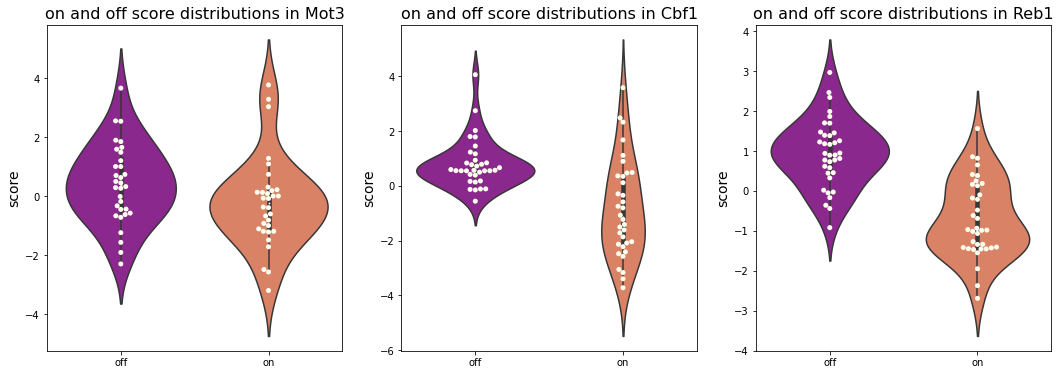

In [1337]:
''' show dist after cyclic grouping '''
strains = ['Mot3','Cbf1', 'Reb1']
fig, axs = plt.subplots(1,3, figsize=(18,6) )
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]
    curr_x = combined_seq_dict[strain+'_'+'on'+'_screened'].delta_median
    curr_y = combined_seq_dict[strain+'_'+'off'+'_screened'].delta_median
    ''' make a kde plot '''
    # sns.kdeplot(curr_x, color='coral', ax=curr_ax, fill=True, label='on')
    # sns.kdeplot(curr_y, color='purple', ax=curr_ax, fill=True, label='off')
    # curr_ax.legend()
    # curr_ax.set_xlabel('score',fontsize=14)
    # curr_ax.set_title('on and off score distributions in '+ strain, fontsize=16)
    
    ''' make a sworm plot '''
    curr_df = pd.DataFrame()
    curr_df['off'] = combined_seq_dict[strain+'_'+'off'+'_screened'].delta_median
    curr_df['on'] = combined_seq_dict[strain+'_'+'on'+'_screened'].delta_median
    sns.violinplot(data=curr_df, ax=curr_ax, palette='plasma')
    sns.swarmplot(data=curr_df, ax=curr_ax, color='ivory', s=5)
    # sns.swarmplot(curr_y, color='purple', ax=curr_ax, label='off')
    # curr_ax.legend()
    curr_ax.set_ylabel('score',fontsize=14)
    curr_ax.set_title('on and off score distributions in '+ strain, fontsize=16)
fig.savefig('/home/labs/barkailab/matanv/CCCA/data_context_step_3/plots/figures/figure_mot3/violin.pdf')

## Figure 444444 - Mot3 correlation: 3 time point 0 repeats and 3 time point 180 repeats

Text(0.5, 1.0, 'correlation between 3 repeates in Mot3')

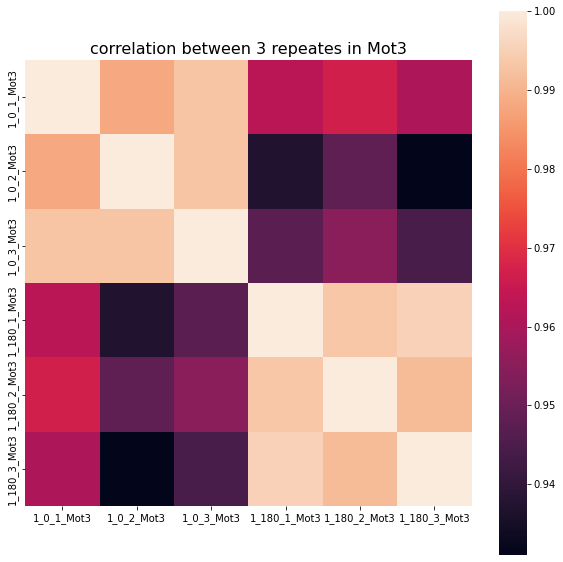

In [676]:
''' correlate Cbf1 and Reb1 together, combine on and off '''
strains = ['Mot3','Cbf1', 'Reb1']
curr_df = pd.DataFrame()
for strain_i, strain in enumerate(strains[:1]):
    if curr_df.shape[1]==0 and strain_i == 0:
        curr_df = res_dict[strain].iloc[:,:6].add_suffix('_'+strain)


plt.figure(figsize=(10, 10) )
sns.heatmap(curr_df.corr(), square=True)
plt.title('correlation between 3 repeates in '+strains[0], fontsize=16)

scatter and compare 3 repeats

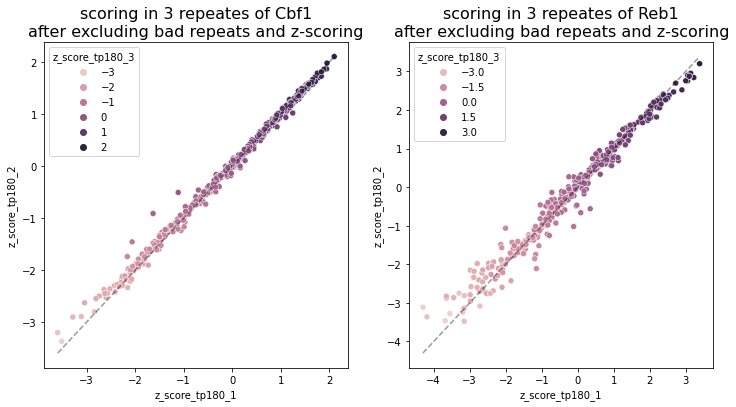

In [619]:
strains = ['Cbf1', 'Reb1']
fig, axs = plt.subplots(1,2, figsize=(12,6) )
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]
    sns.scatterplot(x= res_dict[strain].z_score_tp180_1, y= res_dict[strain].z_score_tp180_2, hue=res_dict[strain].z_score_tp180_3, ax=curr_ax)
    min_val = min(np.nanmin(res_dict[strain].z_score_tp180_1), np.nanmin(res_dict[strain].z_score_tp180_2))
    max_val = max(np.nanmax(res_dict[strain].z_score_tp180_1), np.nanmax(res_dict[strain].z_score_tp180_2))
    curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', alpha=0.4)
    curr_ax.set_title('scoring in 3 repeates of '+strain+'\nafter excluding bad repeats and z-scoring', fontsize=16)
fig.savefig('/home/labs/barkailab/matanv/CCCA/data_context_step_3/plots/figures/figure_1/reb1_cbf1_scatter_3_repeats.pdf')

# scatter all sequences, on vs. off

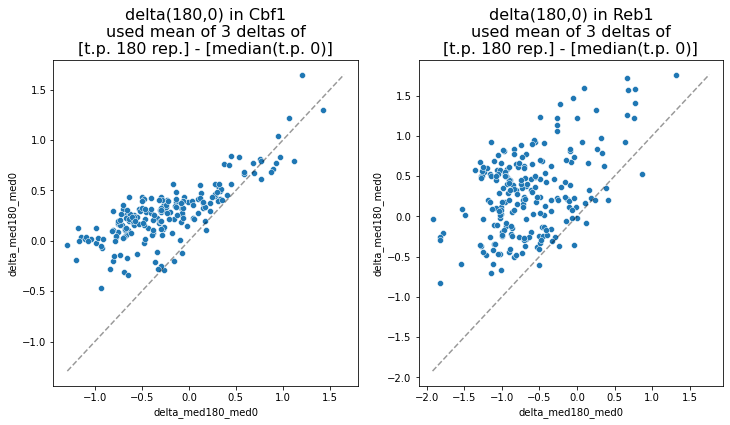

In [1076]:
strains = ['Cbf1', 'Reb1']
fig, axs = plt.subplots(1,2, figsize=(12,6) )
for strain_i, strain in enumerate(strains):
    curr_ax = np.ravel(axs)[strain_i]
        
    curr_x = res_dict[strain].query("on_state=='on'").delta_med180_med0
    curr_y = res_dict[strain].query("on_state=='off'").delta_med180_med0
    sns.scatterplot(x= curr_x, y= curr_y, ax=curr_ax)
    
    min_val = min(np.nanmin(curr_x), np.nanmin(curr_y))
    max_val = max(np.nanmax(curr_x), np.nanmax(curr_y))
    curr_ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', alpha=0.4)
    curr_ax.set_title('delta(180,0) in '+strain+'\nused mean of 3 deltas of\n[t.p. 180 rep.] - [median(t.p. 0)]', fontsize=16)

# group sequences by common features

In [1075]:
def assign_seq_group(sequence):
    ''' get a sequence as a string and assign it to 1 of 4 sequence groups:\n1. AGG\n2. A/T + 3[G,C] + A/T\n3. %AT >= 75%\n4. general sequences
    function will look for the sequenece pattern and its reverse compliment (not the cyclic pattern) in the input sequence and in its cyclic options '''
#     build  a decision tree
#     a sequences can be assigned to more than one group, so it has to be put in the tree in different starting points
    reb1_motif = 'CGGGTAA'
    cbf1_motif = 'CACGTG'
    
    group = []
    agggt_pattern = re.compile(r'[AT](GGG|CCC|GCG|CGC|GGC|CGG|CCG|GCC)[AT]')
    cyc_seq = sequence + sequence + sequence + sequence + sequence
    # if 'AGG' in cyc_seq or 'CCT' in cyc_seq:
    #     group.append('AGG')
    # if bool(agggt_pattern.search(cyc_seq)):
    #     group.append('3G')
    # if calculate_gc_content(cyc_seq) < 26:
    #     group.append('AT_rich')
    if len(group)==0:
        group.append('general_sequence')
    return group

show top sequences

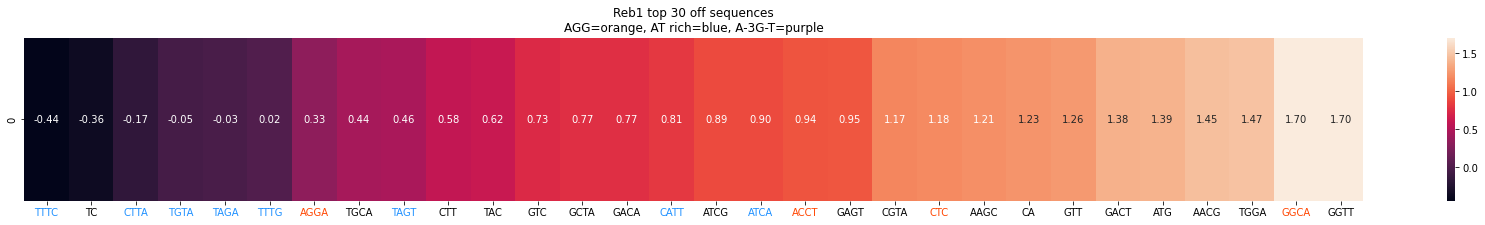

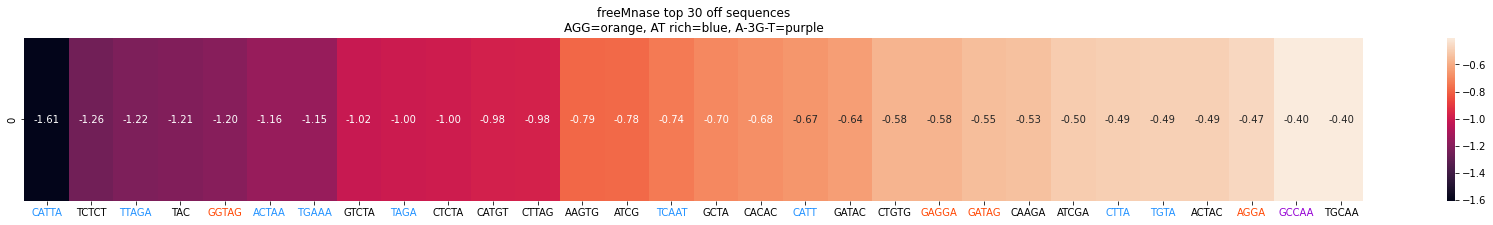

In [394]:
''' top sequences for on/off '''
c_on = 'off'
for strain_i, strain in enumerate(strains[2:]):
    curr_df = combined_seq_dict[strain+'_'+c_on+'_screened'].query("index!='genome'").sort_values(by='delta_median')
    curr_df['group'] = curr_df.index.map(lambda x: assign_seq_group(x))
    curr_df['group_color'] = curr_df['group'].map(lambda x: 'orangered' if x[0] == 'AGG' else 'dodgerblue' if x[0] == 'AT_rich' else 'darkviolet' if x[0] == '3G' else 'black')
    plt.figure(figsize=(30,3))
    plt.title(strain+' top 30 '+c_on+' sequences\nAGG=orange, AT rich=blue, A-3G-T=purple')
    ax = sns.heatmap(curr_df.delta_median[:30].values.reshape(1, -1), annot=True, fmt=".2f", xticklabels=curr_df.index[:30])
    plt.gcf().set_facecolor('white')
    for tick_label, color in zip(ax.get_xticklabels(), curr_df['group_color'][:30]):
        tick_label.set_color(color)
    
    
    
    plt.savefig('/home/labs/barkailab/matanv/CCCA/data_context_step_3/plots/figures/figure_4/30_top_'+c_on+'_seq_'+strain+'.pdf')
    plt.show()
    
''' top sequences for on+off avg '''

for strain_i, strain in enumerate(strains[3:]):
    curr_df = combined_seq_dict[strain+'_'+'on'+'_screened'].query("index!='genome'").merge(combined_seq_dict[strain+'_'+'off'+'_screened'].query("index!='genome'"), how='inner', suffixes=('_on','_off'), left_index=True, right_index=True )
    curr_df = curr_df.loc[:,curr_df.columns.str.contains('delta_median')]
    curr_df['avg_delta_median'] = curr_df.mean(axis=1)
    curr_df = curr_df.sort_values(by='avg_delta_median')
    curr_df.to_csv(f'/home/labs/barkailab/matanv/CCCA/context paper/{strain}_avg(on,off)_sorted.csv')
    # curr_df['group'] = curr_df.index.map(lambda x: assign_seq_group(x))
    # curr_df['group_color'] = curr_df['group'].map(lambda x: 'orangered' if x[0] == 'AGG' else 'dodgerblue' if x[0] == 'AT_rich' else 'darkviolet' if x[0] == '3G' else 'black')
    
#     plt.figure(figsize=(15,3))
#     plt.title(strain+' top 15 '+'on+off avg'+' sequences')
#     ax = sns.heatmap(curr_df.avg_delta_median[:15].values.reshape(1, -1), annot=True, fmt=".2f", xticklabels=curr_df.index[:15], cmap='PuBu_r')
#     for tick_label, color in zip(ax.get_xticklabels(), curr_df['group_color'][:15]):
#         tick_label.set_color(color)
    # plt.savefig('/home/labs/barkailab/matanv/CCCA/data_context_step_3/plots/figures/figure_supp/15_top_'+'on+off_avg_'+'_seq_'+strain+'.pdf')
#     plt.show()


# draw a motif logo for Reb1 and Cbf1 using YeTFasco data

In [874]:
new = """A 0.2667 0.4315 0.3917 0.1303 0.1133 0.0678 0.0053 0.0053 0.0053 0.0053 0.9883 0.9883 0.0224
T 0.2838 0.2042 0.1474 0.4428 0.1076 0.0053 0.0053 0.0053 0.0053 0.9883 0.0053 0.0053 0.3803
G 0.1225 0.1054 0.3554 0.3668 0.1964 0.0032 0.9861 0.9861 0.9861 0.0032 0.0032 0.0032 0.0941
C 0.327 0.2589 0.1054 0.06 0.5827 0.9236 0.0032 0.0032 0.0032 0.0032 0.0032 0.0032 0.5032"""
old = reb1_data
new == old

True

Text(0.5, 1.0, 'Cbf1 motif\nnuc values > 0.48')

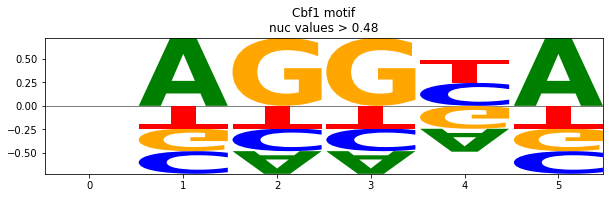

In [893]:
''' draw the motifs of Reb1 and Cbf1 '''
from io import StringIO
reb1_data = """A 0.2667 0.4315 0.3917 0.1303 0.1133 0.0678 0.0053 0.0053 0.0053 0.0053 0.9883 0.9883 0.0224
T 0.2838 0.2042 0.1474 0.4428 0.1076 0.0053 0.0053 0.0053 0.0053 0.9883 0.0053 0.0053 0.3803
G 0.1225 0.1054 0.3554 0.3668 0.1964 0.0032 0.9861 0.9861 0.9861 0.0032 0.0032 0.0032 0.0941
C 0.327 0.2589 0.1054 0.06 0.5827 0.9236 0.0032 0.0032 0.0032 0.0032 0.0032 0.0032 0.5032"""
cbf1_data = """A 0.237137513179293 0.32948399091217 0.197763685942397 0.00278860909910609 0.920734856903992 0.00089193017257065 0.0410345342413837 0.000944528528347179 0.000971387773142099 0.361357707633429 0.193994217707531 0.189881309330071
T 0.23714651560942 0.210131360717956 0.362755329873373 0.000995220949002888 0.0297507846962818 0.106285967084209 0.000957051363032551 0.943584943403775 0.0266694513116163 0.173296315849763 0.314672409307358 0.274086238938447
G 0.260938614547186 0.363396918103417 0.189327085235532 0.000995220949002888 0.048593623542822 0.00089193017257065 0.957051363032551 0.0538664336640913 0.971387773142099 0.142261470487374 0.159055906680538 0.20599694321112
C 0.264777356664102 0.0969877302664572 0.250153898948699 0.995220949002888 0.000920734856903992 0.89193017257065 0.000957051363032551 0.00160409440378642 0.000971387773142099 0.323084506029434 0.332277466304573 0.330035508520362"""
mot3_data = """A 0.329356708051715 0.96428929471504 0.01190356842832 0.01190356842832 0.011909209267805 0.96428929471504
T 0.329356708051715 0.01190356842832 0.01190356842832 0.01190356842832 0.488090790732195 0.01190356842832
G 0.0119298758448538 0.01190356842832 0.96428929471504 0.96428929471504 0.011909209267805 0.01190356842832
C 0.329356708051715 0.01190356842832 0.01190356842832 0.01190356842832 0.488090790732195 0.01190356842832"""

curr_data = mot3_data
curr_tf = 'Cbf1'

data_file = StringIO(curr_data)
df = pd.read_csv(data_file, delim_whitespace=True, header=None, index_col=0)

# Transpose the DataFrame to have the desired format
df = df.T
df = df.applymap(lambda x: 0 if x < 0.48 else x)


logomaker.Logo(df.reset_index(drop=True), center_values=True, font_name = 'Arial Rounded MT Bold')
plt.title(curr_tf+' motif\nnuc values > 0.48')
# plt.savefig('/home/labs/barkailab/matanv/CCCA/data_context_step_3/plots/figures/figure_s1/cbf1_motif.pdf')


In [938]:
os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')

def screen_for_threshold(lib_df, threshold):
    """ input is lib_df and a threshold (number) \noutput is the lib_df, after samples that their time point 0 median is below the threshold were removed\n
    checks for pairs of samples, so if sample in 'on state' was bad, it removes both the 'on' and the 'off state' samples."""
    res_df = pd.DataFrame()
    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    indices_to_keep = [[i, i+1] if i % 2 == 0 else [i-1,i] for i, value in enumerate(med_0) if (i % 2 == 0 and med_0[i]>threshold and med_0[i+1]>threshold) or 
                       (i % 2 == 1 and med_0[i-1]>threshold and med_0[i]>threshold)]
    indices_to_keep = list(np.unique(indices_to_keep))
    return lib_df.iloc[indices_to_keep,:]


def load_data(strain, strain_i, lib, lib_i, threshold, exp_num, norm_to, zscoring='mean', flip_zscore=False):
    """ load data by TF and lib. Output is 3 dfs: lib_df, on_rows, off_rows, DataFrames where rows are sequences and columns are samples
    \nin all dfs features are added as columns\nchoose z - scoring center meassure: mean, median or none, default is mean"""
    
    
    all_adapts = pd.read_csv('./libs_info/R1_adapters.fasta', header=None,index_col=0)
    lib_adapt = all_adapts.filter(regex=lib,axis=0).reset_index().applymap(lambda x: x.replace('>'+lib+'_',''))
    lib_adapt.columns = ['seq_names']
    res_files_path = './seq_count/'
    samp_info = pd.read_csv('./libs_info/samp_info.csv')
    lib_df = pd.DataFrame(index=lib_adapt["seq_names"])
    res_files = os.listdir(res_files_path)
    samp_number = samp_info.query("Strain==@strain & Library==@lib").shape[0]
    samp_list = []
    for line in samp_info.query("Strain==@strain & Library==@lib").iterrows():

        curr_patt = line[1]['Pool name']+'_S[0-9]{1,3}'+'\.'+str(line[1]['Well barcode number'])+'\.'
        curr_file = [f for f in res_files if re.search(curr_patt, f)][0]
        curr_res = pd.read_csv(os.path.join(res_files_path,curr_file), delimiter=' ',header=None,index_col=0)
        curr_res.reset_index(inplace=True)
        curr_res.columns = ['Name','Reads']
        curr_res.index = curr_res["Name"].apply(lambda x: x.replace(lib+'_',''))
        ordered_res = curr_res.loc[curr_res.index.drop('no_adapter'),"Reads"].reindex(lib_df.index)
        curr_sample_name = str(line[1]["Trans repeat"])+'_'+str(line[1]["Time point"])+'_'+str(line[1]["Time point repeat"])
        samp_list.append(curr_sample_name)
        lib_df = pd.concat([lib_df,ordered_res],axis=1)
    lib_df.columns = samp_list
          
    lib_df, _ = rm_samples(strain, lib, exp_num, lib_df)       
    lib_df = (lib_df/lib_df.sum()*norm_to).apply(np.log2) 
    # lib_df = screen_for_threshold(lib_df,threshold)
    lib_df = screen_for_nan(lib_df)
    lib_df = lib_df.drop_duplicates()


    
#     if threshold == 0:
#         # remove rows where all tp0 or all tp180 samples are nan
#         tp0_remove = lib_df[['2_0_1', '2_0_2', '2_0_3']].isna().any(axis=1)
#         tp180_remove = lib_df[['2_180_1', '2_180_2', '2_180_3']].isna().any(axis=1)
#         lib_df = lib_df[~(tp0_remove | tp180_remove)]
        
#         # remove rows with at least 1 nan
#         lib_df.dropna(inplace=True)


        
    lib_df['nuc_comb'] = lib_df.index.str.split('_').str[2]
    lib_df['nuc_comb_len'] = lib_df.index.str.split('_').str[2].str.len()
    
    lib_df['on_state'] = lib_df.index.str.split('_').str[3]
    lib_df['strain'] = [strain]*lib_df.shape[0]
    lib_df['lib'] = [lib]*lib_df.shape[0]
    lib_df['lib_i'] = [lib[-1]]*lib_df.shape[0]

    med_0 = lib_df.loc[:,lib_df.columns.str.contains('_0_')].median(axis=1)
    med_180 = lib_df.loc[:,lib_df.columns.str.contains('_180_')]
    
    delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    addition = np.add(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
    lib_df['addition'] = addition.mean(axis=1)
    lib_df['reads_sum'] = pd.concat([lib_df.loc[:,lib_df.columns.str.contains('_0_')], lib_df.loc[:,lib_df.columns.str.contains('_180_')]],axis=1).sum(axis=1)
    
    lib_df['med_0'] = med_0
    lib_df['delta_med180_med0'] = delta.mean(axis=1)
    lib_df = lib_df.set_index('nuc_comb', drop=False)
    
    flip = 1
    if flip_zscore == True:
        flip = -1

    if zscoring == 'mean':
        lib_df['z_score_tp0_1'] = stats.zscore( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = stats.zscore( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = stats.zscore( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = stats.zscore( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = stats.zscore( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = stats.zscore( lib_df['1_180_3']) *flip

        lib_df['z_score'] = stats.zscore( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = stats.zscore( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = stats.zscore( off_rows['delta_med180_med0']) *flip
        
    elif zscoring=='median':
        lib_df['z_score_tp0_1'] = median_zscoring( lib_df['1_0_1']) *flip
        lib_df['z_score_tp0_2'] = median_zscoring( lib_df['1_0_2']) *flip
        lib_df['z_score_tp0_3'] = median_zscoring( lib_df['1_0_3']) *flip

        lib_df['z_score_tp180_1'] = median_zscoring( lib_df['1_180_1']) *flip
        lib_df['z_score_tp180_2'] = median_zscoring( lib_df['1_180_2']) *flip
        lib_df['z_score_tp180_3'] = median_zscoring( lib_df['1_180_3']) *flip

        lib_df['z_score'] = median_zscoring( lib_df['delta_med180_med0']) *flip

        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
        on_rows['z_score'] = median_zscoring( on_rows['delta_med180_med0']) *flip
        off_rows['z_score'] = median_zscoring( off_rows['delta_med180_med0']) *flip
    
    elif zscoring=='none':
        on_rows = lib_df.query("on_state=='on'")
        off_rows = lib_df.query("on_state=='off'")
    return lib_df, on_rows, off_rows


gc_df = pd.DataFrame()
at_df = pd.DataFrame()
all_df = pd.DataFrame()
Msn2_strains =  ['Msn2','Msn2DBDOE','Msn2NONDBDOE','freeMnase']
Msn2_libs = [ ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'],
              ['Msn2A','Msn2B','Msn2C','Msn2D','Msn2E','Msn2F','Msn2G','Msn2H'] ]

strains_2 = ['Mot3','Cbf1','Reb1']
libs_2 =    [ ['Mot3A', 'Mot3B'], ['Cbf1A','Cbf1B'], ['Reb1A', 'Reb1B'] ]

libs = Msn2_libs
strains = Msn2_strains
norm_to = 10**6
exp_num = 29
logo_len = 5
res_df = pd.DataFrame()
res_dict = {}
threshold = 0

for strain_i, strain in enumerate(strains):
    if strain == 'freeMnase':
        os.chdir('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context')
        rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')
        exp_num = 30
    else:
        os.chdir('/home/labs/barkailab/matanv/CCCA/data_context_step_3')
        rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')
        exp_num = 29
    for lib_i, lib in enumerate(libs[strain_i]):
        thsld_list_8 = [[thsld]*rep for thsld in [threshold] for rep in [len(libs[strain_i])] * len(strains)] 
        thsld = thsld_list_8[strain_i][lib_i]
        lib_df, on_rows, off_rows = load_data(strain, strain_i, lib, lib_i, thsld, exp_num, norm_to, 'median')
        if strain+'_on' not in res_dict.keys():
            res_dict[strain] = lib_df
            res_dict[strain+'_on'] = on_rows
            res_dict[strain+'_off'] =  off_rows
        else:
            res_dict[strain] = pd.concat( [res_dict[strain], lib_df ])
            res_dict[strain+'_on'] = pd.concat( [res_dict[strain+'_on'], on_rows ])
            res_dict[strain+'_off'] = pd.concat( [res_dict[strain+'_off'], off_rows ])
            
            
        # if strain == 'Reb1':
        #     gc_df = pd.concat([ gc_df, lib_df[lib_df['nuc_comb'].apply(calculate_gc_content)==100] ])
        #     at_df = pd.concat([ at_df, lib_df[lib_df['nuc_comb'].apply(calculate_gc_content)==0] ])
        #     all_df = pd.concat([ all_df, lib_df] )
        


/tmp/ipykernel_137520/2184325749.py:72: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  delta = np.subtract(med_180, pd.DataFrame({0:med_0,1:med_0,2:med_0}))
/tmp/ipykernel_137520/2184325749.py:73: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df

In [ ]:
gc_df['tp0_median_reads'] = gc_df.iloc[:,:3].median(axis=1)
sns.kdeplot( gc_df.loc[:,'tp0_median_reads'].values, color='dodgerblue', fill=True, label='100% GC sequences' )

at_df = at_df.query("nuc_comb!='genome'")
at_df['tp0_median_reads'] = at_df.iloc[:,:3].median(axis=1)
sns.kdeplot( at_df.loc[:,'tp0_median_reads'].values, color='coral', fill=True, label='100% AT sequences' )


all_df['tp0_median_reads'] = all_df.iloc[:,:3].median(axis=1)
sns.kdeplot( all_df.loc[:,'tp0_median_reads'].values, color='gray', fill=True, label='all sequences' )
plt.legend()
plt.title('Reb1\ntime point 0 read numbers (median of 3 repeats)\nthreshold was 8 before')
plt.axvline(8, color='black',label='threshold')
plt.show()

In [939]:
# count sequences in each strain for threshold 8 and threshold 0
# thrs_seq_count_dict = {}
# for strain in list(res_dict.keys())[::3]:
#     thrs_seq_count_dict[strain+'_on_thrs_'+str(threshold)]  = res_dict[strain].query("on_state=='on'").shape[0]
#     thrs_seq_count_dict[strain+'_off_thrs_'+str(threshold)] = res_dict[strain].query("on_state=='off'").shape[0]

read_count_df = pd.DataFrame(columns=['on_reads','off_reads','total_reads','above_thrs_reads','above_thrs_percentage'])
for strain in list(res_dict.keys())[::3]:
    read_count_df.loc[strain, 'on_reads'] = thrs_seq_count_dict[strain+'_on_thrs_0']
    read_count_df.loc[strain, 'off_reads'] = thrs_seq_count_dict[strain+'_off_thrs_0']
    
    total_reads = thrs_seq_count_dict[strain+'_on_thrs_0'] + thrs_seq_count_dict[strain+'_off_thrs_0']
    above_thrs_reads = thrs_seq_count_dict[strain+'_on_thrs_8'] + thrs_seq_count_dict[strain+'_off_thrs_8']
    read_count_df.loc[strain, 'total_reads'] = total_reads
    read_count_df.loc[strain, 'above_thrs_reads'] = above_thrs_reads
    read_count_df.loc[strain, 'above_thrs_percentage'] = ( above_thrs_reads / total_reads ) * 100
read_count_df

,on_reads,off_reads,total_reads,above_thrs_reads,above_thrs_percentage
Msn2,867,864,1731,1280,73.945696
Msn2DBDOE,822,825,1647,1278,77.595628
Msn2NONDBDOE,763,768,1531,1184,77.335075
freeMnase,803,803,1606,1228,76.463263


make a resutls table of raw results:
    all library sequences with their score before processing and after processing

In [659]:
promoters = ['Aqr1','Cip1','Cwp2','Rho3','Cip1_Msn2DBDOE','Cip1_Msn2NONDBDOE','Cip1_freeMnase']
for prom in promoters:

    # load library sequences
    seq_lib_path = f'/home/labs/barkailab/matanv/CCCA/context paper/library_sequences/sequences/{prom}_libs.xls'
    lib_seq_df = pd.read_excel(seq_lib_path)
    strain = lib_seq_df['Transctiption Factor'][0]
    new_columns = res_dict[strain].columns[[0,1,2,3,4,5,8,14,21]]
    # add lib index (letters)
    r_primers = lib_seq_df['Reverse Primer Name'].unique()
    mapping_dict = {primer: chr(ord('A') + i) for i, primer in enumerate(r_primers)}
    lib_seq_df['lib_i'] = lib_seq_df['Reverse Primer Name'].map(mapping_dict)
    # get read numbers for each sequence after processing
    for seq in lib_seq_df.iterrows():
        seq_i = seq[0]
        strain = lib_seq_df['Transctiption Factor'][seq_i]
        curr_lib_i = lib_seq_df['lib_i'][seq_i]
        curr_nuc_comb = lib_seq_df['STR'][seq_i]
        motif_state = lib_seq_df['Motif state'][seq_i]
        curr_on_state = motif_state_mapping.get(motif_state)
        curr_data = res_dict[strain].query("lib_i==@curr_lib_i & nuc_comb==@curr_nuc_comb & on_state==@curr_on_state ").iloc[:,[0,1,2,3,4,5,8,14,21]]
        if curr_data.shape[0] != 0:
            lib_seq_df.loc[seq_i, new_columns] = curr_data.iloc[0]

        
    if strain == 'freeMnase':
        exp_num = 30
        rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_mnase_x_context', 'data')  # path for rm_samples function .csv
    else:
        exp_num = 29
        rm_samples_path = os.path.join('/home/labs/barkailab/matanv/CCCA/data_context_step_3', 'data')  # path for rm_samples function .csv

    for curr_lib_i in np.unique( lib_seq_df['lib_i'] ):
        if strain[:4] == 'Msn2' or strain == 'freeMnase':
            lib_num = 'Msn2'+curr_lib_i
        else:
            lib_num = strain+curr_lib_i
        lib_seq_screened_df = rm_samples_from_publishable_data(strain, lib_num, exp_num, lib_seq_df)
        lib_seq_screened_df.to_csv(f'/home/labs/barkailab/matanv/CCCA/context paper/library_sequences/sequences with scores/{strain}_libraries_and_results.csv')

In [656]:

def rm_samples_from_publishable_data(tf, lib_num, exp_num, res_table):
    '''This function removes from the result table the samples classified as bad. It gets the result table
    (before or after normalization) and the relevant tf, library number and experiment number.'''
    exp_num = int(exp_num)
    curr_lib_i = lib_num[-1]
    samples_to_remove = pd.read_csv(os.path.join(rm_samples_path, 'samples_to_remove.csv'))
    # read csv containing info about samples to remove
    curr_samples_to_rm = samples_to_remove.loc[(samples_to_remove['Lib_number'] == str(lib_num)) &
                                               (samples_to_remove['Exp_number'] == exp_num) &
                                               (samples_to_remove['TF'] == tf)]

    # get the names of samples to remove relevant to the input
    # max_tech_rep_num = max(
    #     [int(name.split('_')[-1]) for name in res_table.columns])  # number of time point repeats in the experiment
    # var_num = len(res_table)  # number of variants
    samples_to_rm_names = curr_samples_to_rm['Sample_name']  # the sample names that will be removed
    
    sample_bio_rep = np.array(
        [int(name.split('_')[0]) for name in samples_to_rm_names])  # the bio repeats of the bad samples
    sample_tps = np.array(
        [int(name.split('_')[1]) for name in samples_to_rm_names])  # the time point of the bad samples
    sample_tech_rep = np.array(
        [int(name.split('_')[-1]) for name in samples_to_rm_names])  # the technical repeats of the bad samples
    for sample_name in samples_to_rm_names:
        condition = res_table['lib_i'] == curr_lib_i
        res_table.loc[condition, sample_name] = res_table.loc[condition, sample_name].map(lambda x: x if np.isnan(x) else 'low correlation sample')
    return(res_table)
